# Building a Trading Robot
## Machine Learning Engineer Nanodegree
**Calvin Ku**
**September 27, 2016**

## Definition
### Project Overview
Problem with trading is that you never know when is the best time to buy or sell a stock, as you never know if the stock price will go up or go down in the future. This simple trading bot is an attempt to solve this problem.

Given the historical data of a stock, our chimp will tell you whether you should buy or sell or hold a particular stock (in our case, the JPM).

#### Data used in this project
The only data used in this project is the JPM historical data collected from Yahoo Finance. The data ranges from December 30, 1983 to September 27, 2016.

### Problem Statement
This project is about building a trading robot, or we can call it a trading bot. The trading bot is built to give the common user suggestions on whether to buy or sell or hold a particular stock on a particular trading day. The goal of this project is to build a trading bot that can beat a random monkey bot. Inpired by the famous saying of Princeton University professor Burton Malkiel in 1973 that "A blindfolded monkey throwing darts at a newspaper’s financial pages could select a portfolio that would do just as well as one carefully selected by experts” and the Forbes article [Any Monkey Can Beat the Market](http://www.forbes.com/sites/rickferri/2012/12/20/any-monkey-can-beat-the-market/#da3bf2d6e8b6), instead of competing on a portfolio basis, we set our battlefield on JPM.

We will use JPM as an example in this project but the same method can be applied to any stock. In the end we will evaluate our method by giving the monkey bot (which chooses the three actions equally on a random basis) and our chimp (the trading bot) 1000 dollars and see how they perform from year September 28, 2015 to the end of September 27, 2016 on JPM.


### Metrics
In this project we use the cash in hand plus the portfolio value (number of shares in hand times the market price), the total assets as the metric. We also and define the reward function to be the ratio of the difference of the assets divided by the previous assets between the current state and the previous, i.e.:
$$
R(s_i) = \frac{Cash(s_{i + 1}) + PV(s_{i + 1}) - Cash(s_i) + PV(s_i)}{Cash(s_i) + PV(s_i)}
$$

This simple metric is in line with what we want the trading bot to achieve in that our ultimate goal is to make as much profit as possible given what we have put into the market, and it doesn't matter whether it's in cash or in shares.

## Analysis
### Data Exploration
#### First look
Let's first take a glance at our data and see if there's any missing values

In [479]:
from __future__ import division

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import time
import random

pd.set_option('display.max_columns', 50)

# dfSPY = pd.read_csv('allSPY.csv', index_col='Date', parse_dates=True, na_values = ['nan'])
dfJPM = pd.read_csv('JPM.csv', index_col='Date', parse_dates=True, na_values = ['nan'])

# del dfSPY.index.name
del dfJPM.index.name
# display(dfSPY)

start_date = '1983-12-30'
end_date = '2016-09-27'

dates = pd.date_range(start_date, end_date)

dfMain = pd.DataFrame(index=dates)
# dfMain = dfMain.join(dfSPY)
dfMain = dfMain.join(dfJPM)
dfMain.dropna(inplace=True)

print("Inspect missing values:")
display(dfMain.isnull().sum())
print(len(dfMain))

Inspect missing values:


Open         0
High         0
Low          0
Close        0
Volume       0
Adj Close    0
dtype: int64

8256


and the first few lines:

In [480]:
display(dfMain.head())

,Open,High,Low,Close,Volume,Adj Close
1983-12-30,44.000008,44.500006,43.500014,44.000008,211500.0,2.602623
1984-01-03,43.937506,44.249986,43.624979,44.000008,385500.0,2.602623
1984-01-04,44.843758,45.874979,44.249986,45.874979,292500.0,2.713529
1984-01-05,46.812508,47.375008,46.250008,47.375008,344100.0,2.802256
1984-01-06,46.875014,47.375008,46.375021,46.875014,194400.0,2.772681


We can see that we have six columns: Open, High, Low, Close, Volume, Adj Close. The Adj Close is the closing price of that day adjusted for "future" dividends payout and splits. For our usage, we will need to adjust the rest of columns as well.

### Exploratory Visualization
Now let's have a look on the performance of JPM itself:

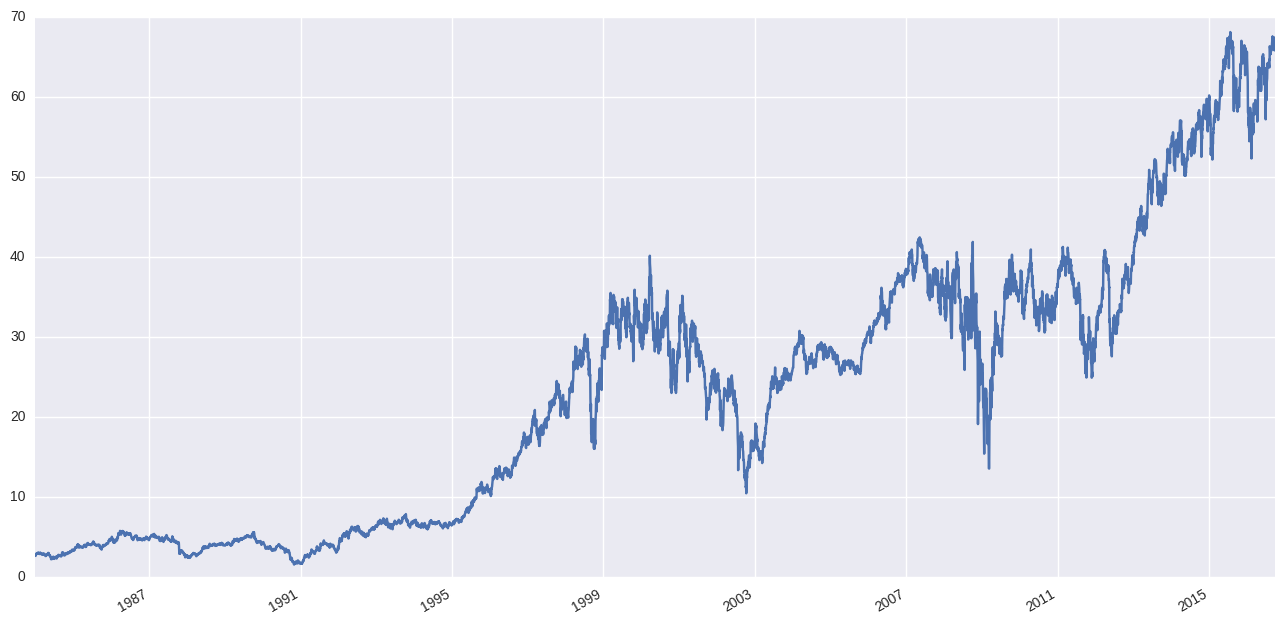

In [481]:
dfMain['Adj Close'].plot(figsize=(16, 8))

Starting from the beginning, the stock price generally has a upward trend, with a bad time from 2001 to 2003 and the crush at the end of 2008. 

### Algorithms and Techniques
#### Algorithms
The trading bot (from now on we refer to it as the *chimp*, coined with our wishful expectation that she will be smarter than the monkey trader) consists of two parts. In the first part we implement Q-learning and run it through the historical data for some number of iterations to construct the Q-table. The chimp can then go with the optimal policy by following the action of which the state-action pair has the maximum Q value. However, since the state space is vast and the coverage of the Q-table is very small, in the second part we use supervised learning to train on the Q-table and make predictions for the unseen states.

We also use K-fold cross-validation

##### Reinfocement learning
###### Q-learning
The idea of reinforcement learning is simple.
1. The chimp senses its environment (data of some sort)
2. The chimp takes an action
3. The chimp gets a reward for that action she took
4. The chimp "remembers" the association between the state-action pair and the reward, so next time when she is in the same situation, she'd carry out the action that she thinks best, under the condition that,
5. The chimp has a really good memory so she doesn't just remember the immediate reward for each state-action pair, she also remembers all the rewards that are prior to and lead to the current state-action pair so that she can maximize the total reward she gets.

One way to do this is to use a method called Q-learning. At the core of Q-learning is the Bellman equation.

In each iteration we use the Bellman equation to update the cell of our Q-table:
$$
Q(s, a) \longleftarrow (1 - \alpha) \ Q(s, a) + \alpha \ (R(s) + \gamma  \ max_{a'} Q(s', a'))
$$

where $\alpha$ is the learning rate, $R(s)$ the reward function, and $\gamma$ the discount factor.
And then the chimp will follow the policy:
$$
\pi(s) = argmax_{a}Q(s, a)
$$

Although we don't have the Q value of any state action pair to begin with, the reward function contains the "real" information and throughout the iterations that information will slowly propagate to each state-action pair. At some point the Q values will converge (hopefully), and we end up with a Q table in equilibrium.

###### Exploration-exploitation dilemma
However, there's a catch. How does the chimp know what to do before she has learned anything?

To begin with, the chimp goes out and explores the world, sensing new data as she goes, and taking actions.

One important concept of reinforcement learning is the **exploration-exploitation dilemma**. Essentially it means when we take an action, we have to choose between whether to explore new possibilities, or just to follow what we've known to be best, to the best of our knowledge. And of course, if we don't know much, then following that limited knowledge of ours wouldn't make much sense. On the other hand, if we've already known pretty much everything, then there's just not much to explore and wandering around mindlessly wouldn't make sense either.

To implement this concept, we want our chimp set out not having bias (not that she's got much anyways), so we introduce the variable $\epsilon$, which represents the possibility of the chimp taking random actions. Initially we set $\epsilon = 1$ , and gradually decreases its value as the chimp getting to know more and more about its environment.

##### Supervised learning with random forest
As stated earlier, the random forest is an ensemble method, which "ensembles" a bunch of decision trees. Each decision tree is generated by creating "nodes" with features in our dataset. 

##### Decision tree
In the training stage, a data point comes down and through the nodes of the decision tree. Each node classifies the data point and sends it to the next node. Say, for example we are classifying people to determine whether their annual income is above or below average, and one feature of our data is gender. And we will probably have values like male/female/other. Now say this data point is a female, then it will get sent down the path accordingly to the next node. The node at the bottom of the decision tree is sometimes referred to as a leaf. Our data point will end up in one of the leaves, and the label of the data point is going to mark that leaf. For example, if our data point is above income average, then we mark that leaf as "above count +1". At the end of the training, all leaves will be marked with labels above or below.

In the predicting stage, we run data down the decision tree and see which leaves they end up with. And then we assign the data the labels of the leaves accordingly.

##### Ensemble
We now know how each decision tree is constructed, and have a forest of decision trees. The last step is to get these decision trees to vote. If 10 trees say this person is above and 5 say below, we predict the person as above. 

##### Randomness of random forest
As said earlier, the decision trees are constructed with the features of our dataset. However, not all of the features are used to construct each decision tree. This is where the random part of the algorithm comes in. Most implementation employs a method called bagging, which generates $m$ sub-datasets from the feature space of the orginal dataset by sampling with replacement, where the size of the sub-datasets is $n'$, relative to the size of the feature space of the original dataset, $n$. The features of each bag are then used to construct a decision tree model.

##### Other parts of random forest
We won't cover everything about the random forest here. However it's worth noting some of the more important specifics of random forest that are not covered here:
* Binning of the continuous variables—which are done slightly differently from implementation to implementation
* Splitting methods—when constructing the decision trees we need to decide which feature to be placed on top of the tree and which to be put at the bottom. 
* Voting methods—we can decide to give each decision tree with the same voting power, or not.
* Modification of the algorithm for regression problems (recursive partitioning)

##### Supervised learning with Adaboosted Trees
###### How boosted trees works
Adaboost is an ensemble method, which "ensembles" a bunch of weak learners (any model that works better than chance; in our case we use decision trees), and train them one by one in the following manner:

1. Train one weak learner and output the predictions
2. Identify the data where the predictions of the model did worst
3. Assign more weights to the mislabel/mispredicted data (for example, we can make more copies of them in our dataset)
4. Train the next weak learner with the re-weighted data
5. Keep repeating 1~4 until we are happy
6. We combine the output of all weak learners we get from 1~6 as our final output

In this report we use the decision tree as our weak learner.

###### Decision tree
In the training stage, a data point comes down and through the nodes of the decision tree. Each node classifies the data point and sends it to the next node. Say, for example we are classifying people to determine whether their annual income is above or below average, and one feature of our data is gender. And we will probably have values like male/female/other. Now say this data point is a female, then it will get sent down the path accordingly to the next node. The node at the bottom of the decision tree is sometimes referred to as a leaf. Our data point will end up in one of the leaves, and the label of the data point is going to mark that leaf. For example, if our data point is above income average, then we mark that leaf as "above count +1". At the end of the training, all leaves will be marked with labels above or below.

In the predicting stage, we run data down the decision tree and see which leaves they end up with. And then we assign the data the labels of the leaves accordingly.

### Benchmark
We test our chimp against 100,000 random monkeys and the patient trader we have defined earlier. Since these two naive traders don't get influenced by the media or manipulated by the market makers, they are proven to perform better than the average investor. We are happy as long as our chimp can perform better than the two naive traders.

## Methodology
### Data Preprocessing
#### Adjust prices


In [482]:
display(dfMain.head())

,Open,High,Low,Close,Volume,Adj Close
1983-12-30,44.000008,44.500006,43.500014,44.000008,211500.0,2.602623
1984-01-03,43.937506,44.249986,43.624979,44.000008,385500.0,2.602623
1984-01-04,44.843758,45.874979,44.249986,45.874979,292500.0,2.713529
1984-01-05,46.812508,47.375008,46.250008,47.375008,344100.0,2.802256
1984-01-06,46.875014,47.375008,46.375021,46.875014,194400.0,2.772681


As said earlier, we need to adjust the prices of Open, High, Low, Close, Volume. This can be done by getting the adjustment fact by dividing Adj Close by Close. We then multiply the prices by this factor, and divide the volume by this factor. 

In [483]:
# Adjust Open, High, Low, Volume
dfMain['Adj Factor'] = dfMain['Adj Close'] / dfMain['Close']

dfMain['Open'] = dfMain['Open'] * dfMain['Adj Factor']
dfMain['High'] = dfMain['High'] * dfMain['Adj Factor']
dfMain['Low'] = dfMain['Low'] * dfMain['Adj Factor']
dfMain['Volume'] = dfMain['Volume'] / dfMain['Adj Factor']

dfMain.drop(['Adj Factor'], axis=1, inplace=True)
display(dfMain.head())
display(dfMain.tail())

,Open,High,Low,Close,Volume,Adj Close
1983-12-30,2.602623,2.632198,2.573048,44.000008,3.575624e+06,2.602623
1984-01-03,2.598926,2.617409,2.580440,44.000008,6.517272e+06,2.602623
1984-01-04,2.652532,2.713529,2.617410,45.874979,4.945011e+06,2.713529
1984-01-05,2.768984,2.802256,2.735712,47.375008,5.817363e+06,2.802256
1984-01-06,2.772681,2.802256,2.743106,46.875014,3.286531e+06,2.772681


,Open,High,Low,Close,Volume,Adj Close
2016-09-21,66.839996,67.129997,66.309998,66.839996,14116800.0,66.839996
2016-09-22,66.989998,67.419998,66.839996,67.389999,12781700.0,67.389999
2016-09-23,67.389999,67.900002,67.180000,67.250000,13967400.0,67.250000
2016-09-26,66.599998,66.800003,65.540001,65.779999,16408100.0,65.779999
2016-09-27,65.410004,66.410004,65.110001,66.360001,13580600.0,66.360001


#### Features engineering using volume price analysis
Volume price analysis has been around for over 100 years, and there are many legendary traders who made themselves famous (and wealthy) using it. In addition to this, the basic principle behind it kind of makes sense on its own, that:
1. Price can only be moved by volume; large spread pushed by large volume and small spread by low volume
2. If it's not the case, then there's an anomaly, and you need to be cautious

But then people, especially practioners, tend to think of it as an art rather than science, in that even though you have some clues what's going on on the market, you still don't know what the best timing is. And it takes practice and practice until you "get it". 

For we data scientists, everything is science, including art. If a human can stare at the candlesticks telling you when to buy or sell, so can a computer. Thus the following features are extracted from the raw dataset:

For volume:
* -1d Volume
* -2d Volume
* -3d Volume
* -4d Volume
* -5d Volume
* 10d Average Volume
* 21d Average Volume
* 63d Average Volume

For price:
* -1d Spread
* -2d Spread
* -3d Spread
* -4d Spread
* -5d Spread
* 10d Spread
* 21d Spread
* 63d Spread

For wick:
* -1d upperwick/lowerwick
* -2d upperwick/lowerwick
* -3d upperwick/lowerwick
* -4d upperwick/lowerwick
* -5d upperwick/lowerwick
* 10d upperwick/lowerwick
* 21d upperwick/lowerwick
* 63d upperwick/lowerwick

To implement Q-learning we need to make the variables discrete. We use 100 day maximum and 100 day average to divide the above features and get relative levels of those features.

#### Trading price
We set the trading price of each trading day to be:
$$
Trade Price = 0.3 \ Open + 0.7 \ AdjClose
$$
This information is not available to the chimp. The properties of the chimp get updated with this information when she places an order. The portfolio value also gets updated using this price.

The reason for the slight lean to the closing price is because so that when a common user tries to follow the chimp suggestion, he or she still has time to do so.

In [485]:
# Price Engineering
# Get opens
period_list = [1, 2, 3, 4, 5, 10, 21, 63, 100]
for x in period_list:
    dfMain['-' + str(x) + 'd_Open'] = dfMain['Open'].shift(x)

# Get adjCloses
period_list = [1, 2, 3, 4, 5]
for x in period_list:
    dfMain['-' + str(x) + 'd_adjClose'] = dfMain['Adj Close'].shift(x)

# Get highs
dfMain['-1d_High'] = dfMain['High'].shift()
dfMain['-2d_High'] = dfMain['High'].shift(2)
dfMain['-3d_High'] = dfMain['High'].shift(3)
dfMain['-4d_High'] = dfMain['High'].shift(4)
dfMain['-5d_High'] = dfMain['High'].shift(5)
dfMain['10d_High'] = dfMain['High'].shift().rolling(window=10).max()
dfMain['21d_High'] = dfMain['High'].shift().rolling(window=21).max()
dfMain['63d_High'] = dfMain['High'].shift().rolling(window=63).max()
dfMain['100d_High'] = dfMain['High'].shift().rolling(window=100).max()

# Get lows
dfMain['-1d_Low'] = dfMain['Low'].shift()
dfMain['-2d_Low'] = dfMain['Low'].shift(2)
dfMain['-3d_Low'] = dfMain['Low'].shift(3)
dfMain['-4d_Low'] = dfMain['Low'].shift(4)
dfMain['-5d_Low'] = dfMain['Low'].shift(5)
dfMain['10d_Low'] = dfMain['Low'].shift().rolling(window=10).min()
dfMain['21d_Low'] = dfMain['Low'].shift().rolling(window=21).min()
dfMain['63d_Low'] = dfMain['Low'].shift().rolling(window=63).min()
dfMain['100d_Low'] = dfMain['Low'].shift().rolling(window=100).min()

In [8]:
dfMain['100d_Avg_Vol'] = dfMain['Volume'].shift().rolling(window=100).mean() * 1.5
dfMain['100d_Max_Vol'] = dfMain['Volume'].shift().rolling(window=100).max()

dfMain['Abs_Spread'] = np.abs(dfMain['Adj Close'] - dfMain['Open'])
dfMain['Abs_Spread_Shift1'] = dfMain['Abs_Spread'].shift()

dfMain['100d_Avg_Spread'] = dfMain['Abs_Spread_Shift1'].rolling(window=100).mean() * 1.5
dfMain['100d_Max_Spread'] = dfMain['100d_High'] - dfMain['100d_Low']

dfMain.drop(['Abs_Spread_Shift1', 'Abs_Spread'], axis=1, inplace=True)

display(dfMain.tail())
display(dfMain.ix[datetime(2011, 12, 30)][['Open', 'Adj Close']])

,Open,High,Low,Close,Volume,Adj Close,-1d_Open,-2d_Open,-3d_Open,-4d_Open,-5d_Open,-10d_Open,-21d_Open,-63d_Open,-100d_Open,-1d_adjClose,-2d_adjClose,-3d_adjClose,-4d_adjClose,-5d_adjClose,-1d_High,-2d_High,-3d_High,-4d_High,-5d_High,10d_High,21d_High,63d_High,100d_High,-1d_Low,-2d_Low,-3d_Low,-4d_Low,-5d_Low,10d_Low,21d_Low,63d_Low,100d_Low,100d_Avg_Vol,100d_Max_Vol,100d_Avg_Spread,100d_Max_Spread
2016-09-21,66.839996,67.129997,66.309998,66.839996,14116800.0,66.839996,66.750000,66.150002,66.089996,66.290001,66.269997,67.160004,65.750000,62.463746,62.602664,66.459999,66.190002,65.820000,66.639999,66.400002,66.849998,66.639999,66.260002,66.930000,67.250000,67.680000,67.769997,67.769997,67.769997,66.239998,65.849998,65.440002,66.089996,66.209999,65.440002,65.410004,56.609318,56.609318,2.162303e+07,4.445207e+07,0.555336,11.160679
2016-09-22,66.989998,67.419998,66.839996,67.389999,12781700.0,67.389999,66.839996,66.750000,66.150002,66.089996,66.290001,67.220001,66.070000,63.207953,63.198027,66.839996,66.459999,66.190002,65.820000,66.639999,67.129997,66.849998,66.639999,66.260002,66.930000,67.680000,67.769997,67.769997,67.769997,66.309998,66.239998,65.849998,65.440002,66.089996,65.440002,65.440002,56.609318,56.609318,2.158722e+07,4.445207e+07,0.553699,11.160679
2016-09-23,67.389999,67.900002,67.180000,67.250000,13967400.0,67.250000,66.989998,66.839996,66.750000,66.150002,66.089996,67.029999,65.989998,60.012824,62.414134,67.389999,66.839996,66.459999,66.190002,65.820000,67.419998,67.129997,66.849998,66.639999,66.260002,67.430000,67.769997,67.769997,67.769997,66.839996,66.309998,66.239998,65.849998,65.440002,65.440002,65.440002,56.609318,56.609318,2.162404e+07,4.445207e+07,0.558211,11.160679
2016-09-26,66.599998,66.800003,65.540001,65.779999,16408100.0,65.779999,67.389999,66.989998,66.839996,66.750000,66.150002,66.139999,65.910004,58.256495,61.273014,67.250000,67.389999,66.839996,66.459999,66.190002,67.900002,67.419998,67.129997,66.849998,66.639999,67.900002,67.900002,67.900002,67.900002,67.180000,66.839996,66.309998,66.239998,65.849998,65.440002,65.440002,56.609318,56.609318,2.154451e+07,4.445207e+07,0.555250,11.290684
2016-09-27,65.410004,66.410004,65.110001,66.360001,13580600.0,66.360001,66.599998,67.389999,66.989998,66.839996,66.750000,66.110001,66.330002,58.732788,61.124170,65.779999,67.250000,67.389999,66.839996,66.459999,66.800003,67.900002,67.419998,67.129997,66.849998,67.900002,67.900002,67.900002,67.900002,65.540001,67.180000,66.839996,66.309998,66.239998,65.440002,65.440002,57.809971,56.609318,2.153319e+07,4.445207e+07,0.564871,11.290684


Open         29.013163
Adj Close    29.135839
Name: 2011-12-30 00:00:00, dtype: float64

In [9]:
def relative_transform(num):
    if 0 <= num < 0.25:
        return 1
    elif 0.25 <= num < 0.5:
        return 2
    elif 0.5 <= num < 0.75:
        return 3
    elif 0.75 <= num < 1:
        return 4
    elif 1 <= num:
        return 5
    elif -0.25 <= num < 0:
        return -1
    elif -0.5 <= num < -0.25:
        return -2
    elif -0.75 <= num < -0.5:
        return -3
    elif -1 <= num < -0.75:
        return -4
    elif num < -1:
        return -5
    else:
        num

# Volume Engineering
# Get volumes
dfMain['-1d_Vol'] = dfMain['Volume'].shift()
dfMain['-2d_Vol'] = dfMain['Volume'].shift(2)
dfMain['-3d_Vol'] = dfMain['Volume'].shift(3)
dfMain['-4d_Vol'] = dfMain['Volume'].shift(4)
dfMain['-5d_Vol'] = dfMain['Volume'].shift(5)

# Get avg. volumes
dfMain['10d_Avg_Vol'] = dfMain['Volume'].shift().rolling(window=10).mean()
dfMain['21d_Avg_Vol'] = dfMain['Volume'].shift().rolling(window=21).mean()
dfMain['63d_Avg_Vol'] = dfMain['Volume'].shift().rolling(window=63).mean()

# Get relative volumes 1
dfMain['-1d_Vol1'] = dfMain['-1d_Vol'] / dfMain['100d_Avg_Vol']
dfMain['-2d_Vol1'] = dfMain['-2d_Vol'] / dfMain['100d_Avg_Vol']
dfMain['-3d_Vol1'] = dfMain['-3d_Vol'] / dfMain['100d_Avg_Vol']
dfMain['-4d_Vol1'] = dfMain['-4d_Vol'] / dfMain['100d_Avg_Vol']
dfMain['-5d_Vol1'] = dfMain['-5d_Vol'] / dfMain['100d_Avg_Vol']

dfMain['-1d_Vol1'] = dfMain['-1d_Vol1'].apply(relative_transform)
dfMain['-2d_Vol1'] = dfMain['-2d_Vol1'].apply(relative_transform)
dfMain['-3d_Vol1'] = dfMain['-3d_Vol1'].apply(relative_transform)
dfMain['-4d_Vol1'] = dfMain['-4d_Vol1'].apply(relative_transform)
dfMain['-5d_Vol1'] = dfMain['-5d_Vol1'].apply(relative_transform)

# Get relative avg. volumes 1 
dfMain['10d_Avg_Vol1'] = dfMain['10d_Avg_Vol'] / dfMain['100d_Avg_Vol']
dfMain['21d_Avg_Vol1'] = dfMain['21d_Avg_Vol'] / dfMain['100d_Avg_Vol']
dfMain['63d_Avg_Vol1'] = dfMain['63d_Avg_Vol'] / dfMain['100d_Avg_Vol']

dfMain['10d_Avg_Vol1'] = dfMain['10d_Avg_Vol1'].apply(relative_transform)
dfMain['21d_Avg_Vol1'] = dfMain['21d_Avg_Vol1'].apply(relative_transform)
dfMain['63d_Avg_Vol1'] = dfMain['63d_Avg_Vol1'].apply(relative_transform)

# Get relative volumes 2
dfMain['-1d_Vol2'] = dfMain['-1d_Vol'] / dfMain['100d_Max_Vol']
dfMain['-2d_Vol2'] = dfMain['-2d_Vol'] / dfMain['100d_Max_Vol']
dfMain['-3d_Vol2'] = dfMain['-3d_Vol'] / dfMain['100d_Max_Vol']
dfMain['-4d_Vol2'] = dfMain['-4d_Vol'] / dfMain['100d_Max_Vol']
dfMain['-5d_Vol2'] = dfMain['-5d_Vol'] / dfMain['100d_Max_Vol']

dfMain['-1d_Vol2'] = dfMain['-1d_Vol2'].apply(relative_transform)
dfMain['-2d_Vol2'] = dfMain['-2d_Vol2'].apply(relative_transform)
dfMain['-3d_Vol2'] = dfMain['-3d_Vol2'].apply(relative_transform)
dfMain['-4d_Vol2'] = dfMain['-4d_Vol2'].apply(relative_transform)
dfMain['-5d_Vol2'] = dfMain['-5d_Vol2'].apply(relative_transform)

In [10]:
# Spread Engineering
# Get spread

dfMain['-1d_Spread'] = dfMain['-1d_adjClose'] - dfMain['-1d_Open']
dfMain['-2d_Spread'] = dfMain['-2d_adjClose'] - dfMain['-2d_Open']
dfMain['-3d_Spread'] = dfMain['-3d_adjClose'] - dfMain['-3d_Open']
dfMain['-4d_Spread'] = dfMain['-4d_adjClose'] - dfMain['-4d_Open']
dfMain['-5d_Spread'] = dfMain['-5d_adjClose'] - dfMain['-5d_Open']

dfMain['10d_Spread'] = dfMain['-1d_adjClose'] - dfMain['-10d_Open']
dfMain['21d_Spread'] = dfMain['-1d_adjClose'] - dfMain['-21d_Open']
dfMain['63d_Spread'] = dfMain['-1d_adjClose'] - dfMain['-63d_Open']

# Get relative spread
dfMain['-1d_Spread'] = dfMain['-1d_Spread'] / dfMain['100d_Avg_Spread']
dfMain['-2d_Spread'] = dfMain['-2d_Spread'] / dfMain['100d_Avg_Spread']
dfMain['-3d_Spread'] = dfMain['-3d_Spread'] / dfMain['100d_Avg_Spread']
dfMain['-4d_Spread'] = dfMain['-4d_Spread'] / dfMain['100d_Avg_Spread']
dfMain['-5d_Spread'] = dfMain['-5d_Spread'] / dfMain['100d_Avg_Spread']

dfMain['-1d_Spread'] = dfMain['-1d_Spread'].apply(relative_transform)
dfMain['-2d_Spread'] = dfMain['-2d_Spread'].apply(relative_transform)
dfMain['-3d_Spread'] = dfMain['-3d_Spread'].apply(relative_transform)
dfMain['-4d_Spread'] = dfMain['-4d_Spread'].apply(relative_transform)
dfMain['-5d_Spread'] = dfMain['-5d_Spread'].apply(relative_transform)

dfMain['10d_Spread'] = dfMain['10d_Spread'] / dfMain['100d_Max_Spread']
dfMain['21d_Spread'] = dfMain['21d_Spread'] / dfMain['100d_Max_Spread']
dfMain['63d_Spread'] = dfMain['63d_Spread'] / dfMain['100d_Max_Spread']

dfMain['10d_Spread'] = dfMain['10d_Spread'].apply(relative_transform)
dfMain['21d_Spread'] = dfMain['21d_Spread'].apply(relative_transform)
dfMain['63d_Spread'] = dfMain['63d_Spread'].apply(relative_transform)

display(dfMain[['-1d_Spread', '-2d_Spread', '-3d_Spread', '-4d_Spread', '-5d_Spread', '21d_Spread']].tail())

,-1d_Spread,-2d_Spread,-3d_Spread,-4d_Spread,-5d_Spread,21d_Spread
2016-09-21,-3.0,1.0,-2.0,3.0,1.0,1.0
2016-09-22,1.0,-3.0,1.0,-2.0,3.0,1.0
2016-09-23,3.0,1.0,-3.0,1.0,-2.0,1.0
2016-09-26,-2.0,3.0,1.0,-3.0,1.0,1.0
2016-09-27,-5.0,-1.0,3.0,1.0,-3.0,-1.0


In [11]:
# Get wicks
def upperwick(open, adj_close, high):
    if high > open and high > adj_close:
        return True
    else:
        return False
def lowerwick(open, adj_close, low):
    if low < open and low < adj_close:
        return True
    else:
        return False
    
for index, row in dfMain.iterrows():
    dfMain.ix[index, '-1d_upperwick_bool'] = upperwick(dfMain.ix[index, '-1d_Open'], dfMain.ix[index, '-1d_adjClose'], dfMain.ix[index, '-1d_High'])
    dfMain.ix[index, '-1d_lowerwick_bool'] = lowerwick(dfMain.ix[index, '-1d_Open'], dfMain.ix[index, '-1d_adjClose'], dfMain.ix[index, '-1d_Low'])
    
    dfMain.ix[index, '-2d_upperwick_bool'] = upperwick(dfMain.ix[index, '-2d_Open'], dfMain.ix[index, '-2d_adjClose'], dfMain.ix[index, '-2d_High'])
    dfMain.ix[index, '-2d_lowerwick_bool'] = lowerwick(dfMain.ix[index, '-2d_Open'], dfMain.ix[index, '-2d_adjClose'], dfMain.ix[index, '-2d_Low'])
    
    dfMain.ix[index, '-3d_upperwick_bool'] = upperwick(dfMain.ix[index, '-3d_Open'], dfMain.ix[index, '-3d_adjClose'], dfMain.ix[index, '-3d_High'])
    dfMain.ix[index, '-3d_lowerwick_bool'] = lowerwick(dfMain.ix[index, '-3d_Open'], dfMain.ix[index, '-3d_adjClose'], dfMain.ix[index, '-3d_Low'])
    
    dfMain.ix[index, '-4d_upperwick_bool'] = upperwick(dfMain.ix[index, '-4d_Open'], dfMain.ix[index, '-4d_adjClose'], dfMain.ix[index, '-4d_High'])
    dfMain.ix[index, '-4d_lowerwick_bool'] = lowerwick(dfMain.ix[index, '-4d_Open'], dfMain.ix[index, '-4d_adjClose'], dfMain.ix[index, '-4d_Low'])
    
    dfMain.ix[index, '-5d_upperwick_bool'] = upperwick(dfMain.ix[index, '-5d_Open'], dfMain.ix[index, '-5d_adjClose'], dfMain.ix[index, '-5d_High'])
    dfMain.ix[index, '-5d_lowerwick_bool'] = lowerwick(dfMain.ix[index, '-5d_Open'], dfMain.ix[index, '-5d_adjClose'], dfMain.ix[index, '-5d_Low'])
    
    dfMain.ix[index, '10d_upperwick_bool'] = upperwick(dfMain.ix[index, '-10d_Open'], dfMain.ix[index, '-1d_adjClose'], dfMain.ix[index, '10d_High'])
    dfMain.ix[index, '10d_lowerwick_bool'] = lowerwick(dfMain.ix[index, '-10d_Open'], dfMain.ix[index, '-1d_adjClose'], dfMain.ix[index, '10d_Low'])
    
    dfMain.ix[index, '21d_upperwick_bool'] = upperwick(dfMain.ix[index, '-21d_Open'], dfMain.ix[index, '-1d_adjClose'], dfMain.ix[index, '21d_High'])
    dfMain.ix[index, '21d_lowerwick_bool'] = lowerwick(dfMain.ix[index, '-21d_Open'], dfMain.ix[index, '-1d_adjClose'], dfMain.ix[index, '21d_Low'])
    
    dfMain.ix[index, '63d_upperwick_bool'] = upperwick(dfMain.ix[index, '-63d_Open'], dfMain.ix[index, '-1d_adjClose'], dfMain.ix[index, '63d_High'])
    dfMain.ix[index, '63d_lowerwick_bool'] = lowerwick(dfMain.ix[index, '-63d_Open'], dfMain.ix[index, '-1d_adjClose'], dfMain.ix[index, '63d_Low'])
    
    dfMain.ix[index, '100d_upperwick_bool'] = upperwick(dfMain.ix[index, '-100d_Open'], dfMain.ix[index, '-1d_adjClose'], dfMain.ix[index, '100d_High'])
    dfMain.ix[index, '100d_lowerwick_bool'] = lowerwick(dfMain.ix[index, '-100d_Open'], dfMain.ix[index, '-1d_adjClose'], dfMain.ix[index, '100d_Low'])
    
# print(dfMain.head(20))

In [12]:
# Transform upper wicks
p_spread1d_up = dfMain['-1d_Spread'] >= 0 & dfMain['-1d_upperwick_bool']
n_spread1d_up = dfMain['-1d_Spread'] < 0 & dfMain['-1d_upperwick_bool']
p_spread2d_up = dfMain['-2d_Spread'] >= 0 & dfMain['-2d_upperwick_bool']
n_spread2d_up = dfMain['-2d_Spread'] < 0 & dfMain['-2d_upperwick_bool']
p_spread3d_up = dfMain['-3d_Spread'] >= 0 & dfMain['-3d_upperwick_bool']
n_spread3d_up = dfMain['-3d_Spread'] < 0 & dfMain['-3d_upperwick_bool']
p_spread4d_up = dfMain['-4d_Spread'] >= 0 & dfMain['-4d_upperwick_bool']
n_spread4d_up = dfMain['-4d_Spread'] < 0 & dfMain['-4d_upperwick_bool']
p_spread5d_up = dfMain['-5d_Spread'] >= 0 & dfMain['-5d_upperwick_bool']
n_spread5d_up = dfMain['-5d_Spread'] < 0 & dfMain['-5d_upperwick_bool']
p_spread10d_up = dfMain['10d_Spread'] >= 0 & dfMain['10d_upperwick_bool']
n_spread10d_up = dfMain['10d_Spread'] < 0 & dfMain['10d_upperwick_bool']
p_spread21d_up = dfMain['21d_Spread'] >= 0 & dfMain['21d_upperwick_bool']
n_spread21d_up = dfMain['21d_Spread'] < 0 & dfMain['21d_upperwick_bool']
p_spread63d_up = dfMain['63d_Spread'] >= 0 & dfMain['63d_upperwick_bool']
n_spread63d_up = dfMain['63d_Spread'] < 0 & dfMain['63d_upperwick_bool']

false1d_up = np.logical_not(dfMain['-1d_upperwick_bool'])
false2d_up = np.logical_not(dfMain['-2d_upperwick_bool'])
false3d_up = np.logical_not(dfMain['-3d_upperwick_bool'])
false4d_up = np.logical_not(dfMain['-4d_upperwick_bool'])
false5d_up = np.logical_not(dfMain['-5d_upperwick_bool'])
false10d_up = np.logical_not(dfMain['10d_upperwick_bool'])
false21d_up = np.logical_not(dfMain['21d_upperwick_bool'])
false63d_up = np.logical_not(dfMain['63d_upperwick_bool'])

dfMain.loc[p_spread1d_up, '-1d_upperwick'] = dfMain.loc[p_spread1d_up, '-1d_High'] - dfMain.loc[p_spread1d_up, '-1d_adjClose']
dfMain.loc[n_spread1d_up, '-1d_upperwick'] = dfMain.loc[n_spread1d_up, '-1d_High'] - dfMain.loc[n_spread1d_up, '-1d_Open']

dfMain.loc[p_spread2d_up, '-2d_upperwick'] = dfMain.loc[p_spread2d_up, '-2d_High'] - dfMain.loc[p_spread2d_up, '-2d_adjClose']
dfMain.loc[n_spread2d_up, '-2d_upperwick'] = dfMain.loc[n_spread2d_up, '-2d_High'] - dfMain.loc[n_spread2d_up, '-2d_Open']

dfMain.loc[p_spread3d_up, '-3d_upperwick'] = dfMain.loc[p_spread3d_up, '-3d_High'] - dfMain.loc[p_spread3d_up, '-3d_adjClose']
dfMain.loc[n_spread3d_up, '-3d_upperwick'] = dfMain.loc[n_spread3d_up, '-3d_High'] - dfMain.loc[n_spread3d_up, '-3d_Open']

dfMain.loc[p_spread4d_up, '-4d_upperwick'] = dfMain.loc[p_spread4d_up, '-4d_High'] - dfMain.loc[p_spread4d_up, '-4d_adjClose']
dfMain.loc[n_spread4d_up, '-4d_upperwick'] = dfMain.loc[n_spread4d_up, '-4d_High'] - dfMain.loc[n_spread4d_up, '-4d_Open']

dfMain.loc[p_spread5d_up, '-5d_upperwick'] = dfMain.loc[p_spread5d_up, '-5d_High'] - dfMain.loc[p_spread5d_up, '-5d_adjClose']
dfMain.loc[n_spread5d_up, '-5d_upperwick'] = dfMain.loc[n_spread5d_up, '-5d_High'] - dfMain.loc[n_spread5d_up, '-5d_Open']

dfMain.loc[p_spread10d_up, '10d_upperwick'] = dfMain.loc[p_spread10d_up, '10d_High'] - dfMain.loc[p_spread10d_up, '-1d_adjClose']
dfMain.loc[n_spread10d_up, '10d_upperwick'] = dfMain.loc[n_spread10d_up, '10d_High'] - dfMain.loc[n_spread10d_up, '-10d_Open']

dfMain.loc[p_spread21d_up, '21d_upperwick'] = dfMain.loc[p_spread21d_up, '21d_High'] - dfMain.loc[p_spread21d_up, '-1d_adjClose']
dfMain.loc[n_spread21d_up, '21d_upperwick'] = dfMain.loc[n_spread21d_up, '21d_High'] - dfMain.loc[n_spread21d_up, '-21d_Open']

dfMain.loc[p_spread63d_up, '63d_upperwick'] = dfMain.loc[p_spread63d_up, '63d_High'] - dfMain.loc[p_spread63d_up, '-1d_adjClose']
dfMain.loc[n_spread63d_up, '63d_upperwick'] = dfMain.loc[n_spread63d_up, '63d_High'] - dfMain.loc[n_spread63d_up, '-63d_Open']

# Get relative upperwick length
dfMain.loc[dfMain['-1d_upperwick_bool'], '-1d_upperwick'] = dfMain.loc[dfMain['-1d_upperwick_bool'], '-1d_upperwick'] / dfMain.loc[dfMain['-1d_upperwick_bool'], '100d_Avg_Spread']
dfMain.loc[dfMain['-2d_upperwick_bool'], '-2d_upperwick'] = dfMain.loc[dfMain['-2d_upperwick_bool'], '-2d_upperwick'] / dfMain.loc[dfMain['-2d_upperwick_bool'], '100d_Avg_Spread']
dfMain.loc[dfMain['-3d_upperwick_bool'], '-3d_upperwick'] = dfMain.loc[dfMain['-3d_upperwick_bool'], '-3d_upperwick'] / dfMain.loc[dfMain['-3d_upperwick_bool'], '100d_Avg_Spread']
dfMain.loc[dfMain['-4d_upperwick_bool'], '-4d_upperwick'] = dfMain.loc[dfMain['-4d_upperwick_bool'], '-4d_upperwick'] / dfMain.loc[dfMain['-4d_upperwick_bool'], '100d_Avg_Spread']
dfMain.loc[dfMain['-5d_upperwick_bool'], '-5d_upperwick'] = dfMain.loc[dfMain['-5d_upperwick_bool'], '-5d_upperwick'] / dfMain.loc[dfMain['-5d_upperwick_bool'], '100d_Avg_Spread']

dfMain.loc[dfMain['10d_upperwick_bool'], '10d_upperwick'] = dfMain.loc[dfMain['10d_upperwick_bool'], '10d_upperwick'] / dfMain.loc[dfMain['10d_upperwick_bool'], '100d_Max_Spread']
dfMain.loc[dfMain['21d_upperwick_bool'], '21d_upperwick'] = dfMain.loc[dfMain['21d_upperwick_bool'], '21d_upperwick'] / dfMain.loc[dfMain['21d_upperwick_bool'], '100d_Max_Spread']
dfMain.loc[dfMain['63d_upperwick_bool'], '63d_upperwick'] = dfMain.loc[dfMain['63d_upperwick_bool'], '63d_upperwick'] / dfMain.loc[dfMain['63d_upperwick_bool'], '100d_Max_Spread']

# Transform upperwick ratio to int
dfMain.loc[dfMain['-1d_upperwick_bool'], '-1d_upperwick'] = dfMain.loc[dfMain['-1d_upperwick_bool'], '-1d_upperwick'].apply(relative_transform)
dfMain.loc[dfMain['-2d_upperwick_bool'], '-2d_upperwick'] = dfMain.loc[dfMain['-2d_upperwick_bool'], '-2d_upperwick'].apply(relative_transform)
dfMain.loc[dfMain['-3d_upperwick_bool'], '-3d_upperwick'] = dfMain.loc[dfMain['-3d_upperwick_bool'], '-3d_upperwick'].apply(relative_transform)
dfMain.loc[dfMain['-4d_upperwick_bool'], '-4d_upperwick'] = dfMain.loc[dfMain['-4d_upperwick_bool'], '-4d_upperwick'].apply(relative_transform)
dfMain.loc[dfMain['-5d_upperwick_bool'], '-5d_upperwick'] = dfMain.loc[dfMain['-5d_upperwick_bool'], '-5d_upperwick'].apply(relative_transform)

dfMain.loc[dfMain['10d_upperwick_bool'], '10d_upperwick'] = dfMain.loc[dfMain['10d_upperwick_bool'], '10d_upperwick'].apply(relative_transform)
dfMain.loc[dfMain['21d_upperwick_bool'], '21d_upperwick'] = dfMain.loc[dfMain['21d_upperwick_bool'], '21d_upperwick'].apply(relative_transform)
dfMain.loc[dfMain['63d_upperwick_bool'], '63d_upperwick'] = dfMain.loc[dfMain['63d_upperwick_bool'], '63d_upperwick'].apply(relative_transform)

# Assign 0 to no-upperwick days
dfMain.loc[false1d_up, '-1d_upperwick'] = 0
dfMain.loc[false2d_up, '-2d_upperwick'] = 0
dfMain.loc[false3d_up, '-3d_upperwick'] = 0
dfMain.loc[false4d_up, '-4d_upperwick'] = 0
dfMain.loc[false5d_up, '-5d_upperwick'] = 0
dfMain.loc[false10d_up, '10d_upperwick'] = 0
dfMain.loc[false21d_up, '21d_upperwick'] = 0
dfMain.loc[false63d_up, '63d_upperwick'] = 0

In [13]:
# Transform lower wicks
p_spread1d_lw = dfMain['-1d_Spread'] >= 0 & dfMain['-1d_lowerwick_bool']
n_spread1d_lw = dfMain['-1d_Spread'] < 0 & dfMain['-1d_lowerwick_bool']
p_spread2d_lw = dfMain['-2d_Spread'] >= 0 & dfMain['-2d_lowerwick_bool']
n_spread2d_lw = dfMain['-2d_Spread'] < 0 & dfMain['-2d_lowerwick_bool']
p_spread3d_lw = dfMain['-3d_Spread'] >= 0 & dfMain['-3d_lowerwick_bool']
n_spread3d_lw = dfMain['-3d_Spread'] < 0 & dfMain['-3d_lowerwick_bool']
p_spread4d_lw = dfMain['-4d_Spread'] >= 0 & dfMain['-4d_lowerwick_bool']
n_spread4d_lw = dfMain['-4d_Spread'] < 0 & dfMain['-4d_lowerwick_bool']
p_spread5d_lw = dfMain['-5d_Spread'] >= 0 & dfMain['-5d_lowerwick_bool']
n_spread5d_lw = dfMain['-5d_Spread'] < 0 & dfMain['-5d_lowerwick_bool']
p_spread10d_lw = dfMain['10d_Spread'] >= 0 & dfMain['10d_lowerwick_bool']
n_spread10d_lw = dfMain['10d_Spread'] < 0 & dfMain['10d_lowerwick_bool']
p_spread21d_lw = dfMain['21d_Spread'] >= 0 & dfMain['21d_lowerwick_bool']
n_spread21d_lw = dfMain['21d_Spread'] < 0 & dfMain['21d_lowerwick_bool']
p_spread63d_lw = dfMain['63d_Spread'] >= 0 & dfMain['63d_lowerwick_bool']
n_spread63d_lw = dfMain['63d_Spread'] < 0 & dfMain['63d_lowerwick_bool']

false1d_lw = np.logical_not(dfMain['-1d_lowerwick_bool'])
false2d_lw = np.logical_not(dfMain['-2d_lowerwick_bool'])
false3d_lw = np.logical_not(dfMain['-3d_lowerwick_bool'])
false4d_lw = np.logical_not(dfMain['-4d_lowerwick_bool'])
false5d_lw = np.logical_not(dfMain['-5d_lowerwick_bool'])
false10d_lw = np.logical_not(dfMain['10d_lowerwick_bool'])
false21d_lw = np.logical_not(dfMain['21d_lowerwick_bool'])
false63d_lw = np.logical_not(dfMain['63d_lowerwick_bool'])

# Get lowerwick length
dfMain.loc[p_spread1d_lw, '-1d_lowerwick'] = dfMain.loc[p_spread1d_lw, '-1d_Open'] - dfMain.loc[p_spread1d_lw, '-1d_Low']
dfMain.loc[n_spread1d_lw, '-1d_lowerwick'] = dfMain.loc[n_spread1d_lw, '-1d_adjClose'] - dfMain.loc[n_spread1d_lw, '-1d_Low']

dfMain.loc[p_spread2d_lw, '-2d_lowerwick'] = dfMain.loc[p_spread2d_lw, '-2d_Open'] - dfMain.loc[p_spread2d_lw, '-2d_Low']
dfMain.loc[n_spread2d_lw, '-2d_lowerwick'] = dfMain.loc[n_spread2d_lw, '-2d_adjClose'] - dfMain.loc[n_spread2d_lw, '-2d_Low']

dfMain.loc[p_spread3d_lw, '-3d_lowerwick'] = dfMain.loc[p_spread3d_lw, '-3d_Open'] - dfMain.loc[p_spread3d_lw, '-3d_Low']
dfMain.loc[n_spread3d_lw, '-3d_lowerwick'] = dfMain.loc[n_spread3d_lw, '-3d_adjClose'] - dfMain.loc[n_spread3d_lw, '-3d_Low']

dfMain.loc[p_spread4d_lw, '-4d_lowerwick'] = dfMain.loc[p_spread4d_lw, '-4d_Open'] - dfMain.loc[p_spread4d_lw, '-4d_Low']
dfMain.loc[n_spread4d_lw, '-4d_lowerwick'] = dfMain.loc[n_spread4d_lw, '-4d_adjClose'] - dfMain.loc[n_spread4d_lw, '-4d_Low']

dfMain.loc[p_spread5d_lw, '-5d_lowerwick'] = dfMain.loc[p_spread5d_lw, '-5d_Open'] - dfMain.loc[p_spread5d_lw, '-5d_Low']
dfMain.loc[n_spread5d_lw, '-5d_lowerwick'] = dfMain.loc[n_spread5d_lw, '-5d_adjClose'] - dfMain.loc[n_spread5d_lw, '-5d_Low']

dfMain.loc[p_spread10d_lw, '10d_lowerwick'] = dfMain.loc[p_spread10d_lw, '-10d_Open'] - dfMain.loc[p_spread10d_lw, '10d_Low']
dfMain.loc[n_spread10d_lw, '10d_lowerwick'] = dfMain.loc[n_spread10d_lw, '-1d_adjClose'] - dfMain.loc[n_spread10d_lw, '10d_Low']

dfMain.loc[p_spread21d_lw, '21d_lowerwick'] = dfMain.loc[p_spread21d_lw, '-21d_Open'] - dfMain.loc[p_spread21d_lw, '21d_Low']
dfMain.loc[n_spread21d_lw, '21d_lowerwick'] = dfMain.loc[n_spread21d_lw, '-1d_adjClose'] - dfMain.loc[n_spread21d_lw, '21d_Low']

dfMain.loc[p_spread63d_lw, '63d_lowerwick'] = dfMain.loc[p_spread63d_lw, '-63d_Open'] - dfMain.loc[p_spread63d_lw, '63d_Low']
dfMain.loc[n_spread63d_lw, '63d_lowerwick'] = dfMain.loc[n_spread63d_lw, '-1d_adjClose'] - dfMain.loc[n_spread63d_lw, '63d_Low']

# Get relative lowerwick length
dfMain.loc[dfMain['-1d_lowerwick_bool'], '-1d_lowerwick'] = dfMain.loc[dfMain['-1d_lowerwick_bool'], '-1d_lowerwick'] / dfMain.loc[dfMain['-1d_lowerwick_bool'], '100d_Avg_Spread']
dfMain.loc[dfMain['-2d_lowerwick_bool'], '-2d_lowerwick'] = dfMain.loc[dfMain['-2d_lowerwick_bool'], '-2d_lowerwick'] / dfMain.loc[dfMain['-2d_lowerwick_bool'], '100d_Avg_Spread']
dfMain.loc[dfMain['-3d_lowerwick_bool'], '-3d_lowerwick'] = dfMain.loc[dfMain['-3d_lowerwick_bool'], '-3d_lowerwick'] / dfMain.loc[dfMain['-3d_lowerwick_bool'], '100d_Avg_Spread']
dfMain.loc[dfMain['-4d_lowerwick_bool'], '-4d_lowerwick'] = dfMain.loc[dfMain['-4d_lowerwick_bool'], '-4d_lowerwick'] / dfMain.loc[dfMain['-4d_lowerwick_bool'], '100d_Avg_Spread']
dfMain.loc[dfMain['-5d_lowerwick_bool'], '-5d_lowerwick'] = dfMain.loc[dfMain['-5d_lowerwick_bool'], '-5d_lowerwick'] / dfMain.loc[dfMain['-5d_lowerwick_bool'], '100d_Avg_Spread']

dfMain.loc[dfMain['10d_lowerwick_bool'], '10d_lowerwick'] = dfMain.loc[dfMain['10d_lowerwick_bool'], '10d_lowerwick'] / dfMain.loc[dfMain['10d_lowerwick_bool'], '100d_Max_Spread']
dfMain.loc[dfMain['21d_lowerwick_bool'], '21d_lowerwick'] = dfMain.loc[dfMain['21d_lowerwick_bool'], '21d_lowerwick'] / dfMain.loc[dfMain['21d_lowerwick_bool'], '100d_Max_Spread']
dfMain.loc[dfMain['63d_lowerwick_bool'], '63d_lowerwick'] = dfMain.loc[dfMain['63d_lowerwick_bool'], '63d_lowerwick'] / dfMain.loc[dfMain['63d_lowerwick_bool'], '100d_Max_Spread']

# Tranform lowerwick ratio to int
dfMain.loc[dfMain['-1d_lowerwick_bool'], '-1d_lowerwick'] = dfMain.loc[dfMain['-1d_lowerwick_bool'], '-1d_lowerwick'].apply(relative_transform)
dfMain.loc[dfMain['-2d_lowerwick_bool'], '-2d_lowerwick'] = dfMain.loc[dfMain['-2d_lowerwick_bool'], '-2d_lowerwick'].apply(relative_transform)
dfMain.loc[dfMain['-3d_lowerwick_bool'], '-3d_lowerwick'] = dfMain.loc[dfMain['-3d_lowerwick_bool'], '-3d_lowerwick'].apply(relative_transform)
dfMain.loc[dfMain['-4d_lowerwick_bool'], '-4d_lowerwick'] = dfMain.loc[dfMain['-4d_lowerwick_bool'], '-4d_lowerwick'].apply(relative_transform)
dfMain.loc[dfMain['-5d_lowerwick_bool'], '-5d_lowerwick'] = dfMain.loc[dfMain['-5d_lowerwick_bool'], '-5d_lowerwick'].apply(relative_transform)

dfMain.loc[dfMain['10d_lowerwick_bool'], '10d_lowerwick'] = dfMain.loc[dfMain['10d_lowerwick_bool'], '10d_lowerwick'].apply(relative_transform)
dfMain.loc[dfMain['21d_lowerwick_bool'], '21d_lowerwick'] = dfMain.loc[dfMain['21d_lowerwick_bool'], '21d_lowerwick'].apply(relative_transform)
dfMain.loc[dfMain['63d_lowerwick_bool'], '63d_lowerwick'] = dfMain.loc[dfMain['63d_lowerwick_bool'], '63d_lowerwick'].apply(relative_transform)

# Assign 0 to no-lowerwick days
dfMain.loc[false1d_lw, '-1d_lowerwick'] = 0
dfMain.loc[false2d_lw, '-2d_lowerwick'] = 0
dfMain.loc[false3d_lw, '-3d_lowerwick'] = 0
dfMain.loc[false4d_lw, '-4d_lowerwick'] = 0
dfMain.loc[false5d_lw, '-5d_lowerwick'] = 0
dfMain.loc[false10d_lw, '10d_lowerwick'] = 0
dfMain.loc[false21d_lw, '21d_lowerwick'] = 0
dfMain.loc[false63d_lw, '63d_lowerwick'] = 0

In [14]:
# dfMain.dropna(inplace=True)
display(dfMain[['-1d_lowerwick', '-2d_lowerwick', '-3d_lowerwick', '-4d_lowerwick', '-5d_lowerwick', '10d_lowerwick', '21d_lowerwick', '63d_lowerwick']].isnull().sum())

-1d_lowerwick    65
-2d_lowerwick    65
-3d_lowerwick    65
-4d_lowerwick    64
-5d_lowerwick    63
10d_lowerwick    82
21d_lowerwick    74
63d_lowerwick    34
dtype: int64

In [15]:
display(dfMain.tail())

,Open,High,Low,Close,Volume,Adj Close,-1d_Open,-2d_Open,-3d_Open,-4d_Open,-5d_Open,-10d_Open,-21d_Open,-63d_Open,-100d_Open,-1d_adjClose,-2d_adjClose,-3d_adjClose,-4d_adjClose,-5d_adjClose,-1d_High,-2d_High,-3d_High,-4d_High,-5d_High,...,-5d_lowerwick_bool,10d_upperwick_bool,10d_lowerwick_bool,21d_upperwick_bool,21d_lowerwick_bool,63d_upperwick_bool,63d_lowerwick_bool,100d_upperwick_bool,100d_lowerwick_bool,-1d_upperwick,-2d_upperwick,-3d_upperwick,-4d_upperwick,-5d_upperwick,10d_upperwick,21d_upperwick,63d_upperwick,-1d_lowerwick,-2d_lowerwick,-3d_lowerwick,-4d_lowerwick,-5d_lowerwick,10d_lowerwick,21d_lowerwick,63d_lowerwick
2016-09-21,66.839996,67.129997,66.309998,66.839996,14116800.0,66.839996,66.750000,66.150002,66.089996,66.290001,66.269997,67.160004,65.750000,62.463746,62.602664,66.459999,66.190002,65.820000,66.639999,66.400002,66.849998,66.639999,66.260002,66.930000,67.250000,...,True,True,True,True,True,True,True,True,True,1.0,4.0,2.0,3.0,5.0,1.0,1.0,1.0,2.0,3.0,3.0,2.0,1.0,1.0,1.0,3.0
2016-09-22,66.989998,67.419998,66.839996,67.389999,12781700.0,67.389999,66.839996,66.750000,66.150002,66.089996,66.290001,67.220001,66.070000,63.207953,63.198027,66.839996,66.459999,66.190002,65.820000,66.639999,67.129997,66.849998,66.639999,66.260002,66.930000,...,True,True,True,True,True,True,True,True,True,3.0,1.0,4.0,2.0,3.0,1.0,1.0,1.0,4.0,2.0,3.0,3.0,2.0,1.0,1.0,3.0
2016-09-23,67.389999,67.900002,67.180000,67.250000,13967400.0,67.250000,66.989998,66.839996,66.750000,66.150002,66.089996,67.029999,65.989998,60.012824,62.414134,67.389999,66.839996,66.459999,66.190002,65.820000,67.419998,67.129997,66.849998,66.639999,66.260002,...,True,True,True,True,True,True,True,True,True,1.0,3.0,1.0,4.0,2.0,1.0,1.0,1.0,2.0,4.0,2.0,3.0,3.0,1.0,1.0,2.0
2016-09-26,66.599998,66.800003,65.540001,65.779999,16408100.0,65.779999,67.389999,66.989998,66.839996,66.750000,66.150002,66.139999,65.910004,58.256495,61.273014,67.250000,67.389999,66.839996,66.459999,66.190002,67.900002,67.419998,67.129997,66.849998,66.639999,...,True,True,True,True,True,True,True,True,True,4.0,1.0,3.0,1.0,4.0,1.0,1.0,1.0,1.0,2.0,4.0,2.0,3.0,1.0,1.0,1.0
2016-09-27,65.410004,66.410004,65.110001,66.360001,13580600.0,66.360001,66.599998,67.389999,66.989998,66.839996,66.750000,66.110001,66.330002,58.732788,61.124170,65.779999,67.250000,67.389999,66.839996,66.459999,66.800003,67.900002,67.419998,67.129997,66.849998,...,True,True,True,True,True,True,True,True,True,2.0,4.0,1.0,3.0,1.0,1.0,1.0,1.0,2.0,1.0,2.0,4.0,2.0,1.0,1.0,1.0


In [16]:
dfMain['Trade Price'] = dfMain['Open'] * 0.3 + dfMain['Adj Close'] * 0.7
print(dfMain[['Trade Price', 'Open', 'Adj Close']].head())

            Trade Price      Open  Adj Close
1983-12-30     2.602623  2.602623   2.602623
1984-01-03     2.601514  2.598926   2.602623
1984-01-04     2.695230  2.652532   2.713529
1984-01-05     2.792274  2.768984   2.802256
1984-01-06     2.772681  2.772681   2.772681


In [17]:
display(dfMain.columns)

Index([u'Open', u'High', u'Low', u'Close', u'Volume', u'Adj Close',
       u'-1d_Open', u'-2d_Open', u'-3d_Open', u'-4d_Open',
       ...
       u'63d_upperwick', u'-1d_lowerwick', u'-2d_lowerwick', u'-3d_lowerwick',
       u'-4d_lowerwick', u'-5d_lowerwick', u'10d_lowerwick', u'21d_lowerwick',
       u'63d_lowerwick', u'Trade Price'],
      dtype='object', length=106)

In [18]:
dfMain.drop(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', \
             '-1d_Vol', '-2d_Vol', '-3d_Vol', '-4d_Vol', '-5d_Vol', '10d_Avg_Vol', '21d_Avg_Vol', '63d_Avg_Vol', \
             '-1d_Open', '-2d_Open', '-3d_Open', '-4d_Open', '-5d_Open', '-10d_Open', '-21d_Open', '-63d_Open', '-100d_Open',  \
             '-1d_adjClose', '-2d_adjClose', '-3d_adjClose', '-4d_adjClose', '-5d_adjClose', \
             '-1d_High', '-2d_High', '-3d_High', '-4d_High', '-5d_High', '10d_High', '21d_High', '63d_High', '100d_High',  \
             '-1d_Low', '-2d_Low', '-3d_Low', '-4d_Low', '-5d_Low', '10d_Low', '21d_Low', '63d_Low', '100d_Low',  \
             '100d_Avg_Vol', '100d_Max_Vol', '100d_Avg_Spread', '100d_Max_Spread', \
             '-1d_upperwick_bool', '-2d_upperwick_bool', '-3d_upperwick_bool', '-4d_upperwick_bool', '-5d_upperwick_bool', '10d_upperwick_bool', '21d_upperwick_bool', '63d_upperwick_bool', '100d_upperwick_bool', \
             '-1d_lowerwick_bool', '-2d_lowerwick_bool', '-3d_lowerwick_bool', '-4d_lowerwick_bool', '-5d_lowerwick_bool', '10d_lowerwick_bool', '21d_lowerwick_bool', '63d_lowerwick_bool', '100d_lowerwick_bool'], \
            axis=1, inplace=True)

In [19]:
display(dfMain.columns)
dfMain.ix[:,:-1]

dfMain.dropna(inplace=True)

print(dfMain.isnull().sum())

display(dfMain.head())

Index([u'-1d_Vol1', u'-2d_Vol1', u'-3d_Vol1', u'-4d_Vol1', u'-5d_Vol1',
       u'10d_Avg_Vol1', u'21d_Avg_Vol1', u'63d_Avg_Vol1', u'-1d_Vol2',
       u'-2d_Vol2', u'-3d_Vol2', u'-4d_Vol2', u'-5d_Vol2', u'-1d_Spread',
       u'-2d_Spread', u'-3d_Spread', u'-4d_Spread', u'-5d_Spread',
       u'10d_Spread', u'21d_Spread', u'63d_Spread', u'-1d_upperwick',
       u'-2d_upperwick', u'-3d_upperwick', u'-4d_upperwick', u'-5d_upperwick',
       u'10d_upperwick', u'21d_upperwick', u'63d_upperwick', u'-1d_lowerwick',
       u'-2d_lowerwick', u'-3d_lowerwick', u'-4d_lowerwick', u'-5d_lowerwick',
       u'10d_lowerwick', u'21d_lowerwick', u'63d_lowerwick', u'Trade Price'],
      dtype='object')

-1d_Vol1         0
-2d_Vol1         0
-3d_Vol1         0
-4d_Vol1         0
-5d_Vol1         0
10d_Avg_Vol1     0
21d_Avg_Vol1     0
63d_Avg_Vol1     0
-1d_Vol2         0
-2d_Vol2         0
-3d_Vol2         0
-4d_Vol2         0
-5d_Vol2         0
-1d_Spread       0
-2d_Spread       0
-3d_Spread       0
-4d_Spread       0
-5d_Spread       0
10d_Spread       0
21d_Spread       0
63d_Spread       0
-1d_upperwick    0
-2d_upperwick    0
-3d_upperwick    0
-4d_upperwick    0
-5d_upperwick    0
10d_upperwick    0
21d_upperwick    0
63d_upperwick    0
-1d_lowerwick    0
-2d_lowerwick    0
-3d_lowerwick    0
-4d_lowerwick    0
-5d_lowerwick    0
10d_lowerwick    0
21d_lowerwick    0
63d_lowerwick    0
Trade Price      0
dtype: int64


,-1d_Vol1,-2d_Vol1,-3d_Vol1,-4d_Vol1,-5d_Vol1,10d_Avg_Vol1,21d_Avg_Vol1,63d_Avg_Vol1,-1d_Vol2,-2d_Vol2,-3d_Vol2,-4d_Vol2,-5d_Vol2,-1d_Spread,-2d_Spread,-3d_Spread,-4d_Spread,-5d_Spread,10d_Spread,21d_Spread,63d_Spread,-1d_upperwick,-2d_upperwick,-3d_upperwick,-4d_upperwick,-5d_upperwick,10d_upperwick,21d_upperwick,63d_upperwick,-1d_lowerwick,-2d_lowerwick,-3d_lowerwick,-4d_lowerwick,-5d_lowerwick,10d_lowerwick,21d_lowerwick,63d_lowerwick,Trade Price
1984-05-23,1.0,5.0,1.0,2.0,1.0,2.0,2.0,3.0,1.0,2.0,1.0,1.0,1.0,-5.0,-5.0,4.0,-4.0,-2.0,-3.0,-2.0,-3.0,3.0,0.0,2.0,2.0,0.0,0.0,3.0,2.0,5.0,0.0,0.0,2.0,3.0,1.0,1.0,1.0,2.498467
1984-05-24,2.0,1.0,5.0,1.0,2.0,2.0,2.0,3.0,1.0,1.0,2.0,1.0,1.0,-5.0,-5.0,-5.0,4.0,-4.0,-3.0,-3.0,-3.0,4.0,3.0,0.0,2.0,2.0,1.0,2.0,2.0,0.0,5.0,0.0,0.0,2.0,0.0,0.0,0.0,2.504116
1984-05-25,5.0,2.0,1.0,5.0,1.0,5.0,3.0,3.0,5.0,1.0,1.0,1.0,1.0,-3.0,-5.0,-5.0,-5.0,4.0,-2.0,-3.0,-3.0,5.0,4.0,3.0,0.0,2.0,1.0,2.0,2.0,2.0,0.0,5.0,0.0,0.0,1.0,1.0,1.0,2.489427
1984-05-29,2.0,5.0,2.0,1.0,5.0,5.0,3.0,3.0,1.0,5.0,1.0,1.0,1.0,-2.0,-3.0,-5.0,-5.0,-5.0,-2.0,-3.0,-3.0,4.0,5.0,4.0,3.0,0.0,1.0,2.0,2.0,4.0,2.0,0.0,5.0,0.0,1.0,1.0,1.0,2.422755
1984-05-30,2.0,2.0,5.0,2.0,1.0,5.0,3.0,3.0,1.0,1.0,5.0,1.0,1.0,-5.0,-2.0,-3.0,-5.0,-5.0,-2.0,-3.0,-3.0,2.0,4.0,5.0,4.0,3.0,1.0,1.0,1.0,5.0,4.0,2.0,0.0,5.0,1.0,1.0,1.0,2.267943


In [15]:
# data_full = dfMain
# data_full.to_csv('old_data_full.csv')
data_full = pd.DataFrame.from_csv('old_data_full.csv')

In [16]:
display(data_full.head())
display(data_full.tail())

,-1d_Vol1,-2d_Vol1,-3d_Vol1,-4d_Vol1,-5d_Vol1,10d_Avg_Vol1,21d_Avg_Vol1,63d_Avg_Vol1,-1d_Vol2,-2d_Vol2,-3d_Vol2,-4d_Vol2,-5d_Vol2,-1d_Spread,-2d_Spread,-3d_Spread,-4d_Spread,-5d_Spread,10d_Spread,21d_Spread,63d_Spread,-1d_upperwick,-2d_upperwick,-3d_upperwick,-4d_upperwick,-5d_upperwick,10d_upperwick,21d_upperwick,63d_upperwick,-1d_lowerwick,-2d_lowerwick,-3d_lowerwick,-4d_lowerwick,-5d_lowerwick,10d_lowerwick,21d_lowerwick,63d_lowerwick,Trade Price
1984-05-23,1.0,5.0,1.0,2.0,1.0,2.0,2.0,3.0,1.0,2.0,1.0,1.0,1.0,-5.0,-5.0,4.0,-4.0,-2.0,-3.0,-2.0,-3.0,3.0,0.0,2.0,2.0,0.0,0.0,3.0,2.0,5.0,0.0,0.0,2.0,3.0,1.0,1.0,1.0,2.498467
1984-05-24,2.0,1.0,5.0,1.0,2.0,2.0,2.0,3.0,1.0,1.0,2.0,1.0,1.0,-5.0,-5.0,-5.0,4.0,-4.0,-3.0,-3.0,-3.0,4.0,3.0,0.0,2.0,2.0,1.0,2.0,2.0,0.0,5.0,0.0,0.0,2.0,0.0,0.0,0.0,2.504116
1984-05-25,5.0,2.0,1.0,5.0,1.0,5.0,3.0,3.0,5.0,1.0,1.0,1.0,1.0,-3.0,-5.0,-5.0,-5.0,4.0,-2.0,-3.0,-3.0,5.0,4.0,3.0,0.0,2.0,1.0,2.0,2.0,2.0,0.0,5.0,0.0,0.0,1.0,1.0,1.0,2.489427
1984-05-29,2.0,5.0,2.0,1.0,5.0,5.0,3.0,3.0,1.0,5.0,1.0,1.0,1.0,-2.0,-3.0,-5.0,-5.0,-5.0,-2.0,-3.0,-3.0,4.0,5.0,4.0,3.0,0.0,1.0,2.0,2.0,4.0,2.0,0.0,5.0,0.0,1.0,1.0,1.0,2.422755
1984-05-30,2.0,2.0,5.0,2.0,1.0,5.0,3.0,3.0,1.0,1.0,5.0,1.0,1.0,-5.0,-2.0,-3.0,-5.0,-5.0,-2.0,-3.0,-3.0,2.0,4.0,5.0,4.0,3.0,1.0,1.0,1.0,5.0,4.0,2.0,0.0,5.0,1.0,1.0,1.0,2.267943


,-1d_Vol1,-2d_Vol1,-3d_Vol1,-4d_Vol1,-5d_Vol1,10d_Avg_Vol1,21d_Avg_Vol1,63d_Avg_Vol1,-1d_Vol2,-2d_Vol2,-3d_Vol2,-4d_Vol2,-5d_Vol2,-1d_Spread,-2d_Spread,-3d_Spread,-4d_Spread,-5d_Spread,10d_Spread,21d_Spread,63d_Spread,-1d_upperwick,-2d_upperwick,-3d_upperwick,-4d_upperwick,-5d_upperwick,10d_upperwick,21d_upperwick,63d_upperwick,-1d_lowerwick,-2d_lowerwick,-3d_lowerwick,-4d_lowerwick,-5d_lowerwick,10d_lowerwick,21d_lowerwick,63d_lowerwick,Trade Price
2016-09-21,2.0,3.0,5.0,3.0,3.0,3.0,3.0,3.0,1.0,2.0,3.0,2.0,2.0,-3.0,1.0,-2.0,3.0,1.0,-1.0,1.0,2.0,1.0,4.0,2.0,3.0,5.0,1.0,1.0,1.0,2.0,3.0,3.0,2.0,1.0,1.0,1.0,3.0,66.839996
2016-09-22,3.0,2.0,3.0,5.0,3.0,3.0,3.0,3.0,2.0,1.0,2.0,3.0,2.0,1.0,-3.0,1.0,-2.0,3.0,-1.0,1.0,2.0,3.0,1.0,4.0,2.0,3.0,1.0,1.0,1.0,4.0,2.0,3.0,3.0,2.0,1.0,1.0,3.0,67.269999
2016-09-23,3.0,3.0,2.0,3.0,5.0,3.0,3.0,3.0,2.0,2.0,1.0,2.0,3.0,3.0,1.0,-3.0,1.0,-2.0,1.0,1.0,3.0,1.0,3.0,1.0,4.0,2.0,1.0,1.0,1.0,2.0,4.0,2.0,3.0,3.0,1.0,1.0,2.0,67.292000
2016-09-26,3.0,3.0,3.0,2.0,3.0,3.0,3.0,3.0,2.0,2.0,2.0,1.0,2.0,-2.0,3.0,1.0,-3.0,1.0,1.0,1.0,4.0,4.0,1.0,3.0,1.0,4.0,1.0,1.0,1.0,1.0,2.0,4.0,2.0,3.0,1.0,1.0,1.0,66.025999
2016-09-27,4.0,3.0,3.0,3.0,2.0,3.0,3.0,3.0,2.0,2.0,2.0,2.0,1.0,-5.0,-1.0,3.0,1.0,-3.0,-1.0,-1.0,3.0,2.0,4.0,1.0,3.0,1.0,1.0,1.0,1.0,2.0,1.0,2.0,4.0,2.0,1.0,1.0,1.0,66.075002


In [17]:
start_date = datetime(2012, 9, 28)
print("{0} Trade Price: {1}".format(start_date, data_full.ix[start_date, 'Trade Price']))
print("{0} Trade Price: {1}".format(start_date + timedelta(days=728), data_full.ix[start_date + timedelta(days=728), 'Trade Price']))

train_phase_data = data_full.ix[start_date:start_date + timedelta(days=728), :]
print(len(train_phase_data))

2012-09-28 00:00:00 Trade Price: 36.2441538211
2014-09-26 00:00:00 Trade Price: 57.2382086323
501


## Implementation
The problem with time series data in contrast to cross-sectional ones is that we cannot rely on conventional methods such as cross-validation or the usual 4:3:3 train-cv-test testing framework, as all of these methods are based on the assumption that all our data are drawn from the same population and a careful selection of a sample (samples) with proper modelling can say a lot about the entire population (and of course, about the other carefully drawn samples). However, we are not so lucky when it comes to dealing with time series data, mostly because:

1. Most if not all of the time our model really isn't the underlying model, that is, the data doesn't really come from the model we use. So it works only for really limit range of time and as the time series gets longer the difference between our model on the training set and the underlying model starts to show.

2. Essentially the system we are looking at is a time-dependent one so the underlying model itself most likely changes from time to time (unless we're talking about some grand unified model that can model the whole universe), in which case, assuming one model structure will work on the entire period of data is just wishful thinking.

### Training-testing framework
As said above, we will thus employ a training-testing framework that rolls as time goes. In our case, we keep 2 years of data for training, and use the model to predict for 1 month, and since we are probably more interested in the performance of the JPM of the past year we will proceed as following:

1. Use data from September 29, 2014 to September 28, 2015 as our validation dataset, and
2. Use data from September 28, 2015 to September 27, 2016 as our test dataset
3. Use two years of data prior to prediction period as our training set. Thus for our validation dataset we use data starting from the batch from September 28, 2012 to September 26, 2014, and September 28, 2013 to September 27, 2015 for our test dataset. Each training data batch will predict for the next 21 trading days.

### Parameters for Q learning
We start off setting our parameters as follows:

* Discount factor: $\gamma = 0.75$
* Learning rate: $\alpha = \frac{1}{t}$, where $t$ is the number of time a state-action pair gets updated
* Eploitation-exploration ratio: $\epsilon = \epsilon -$ `iter_number`
* Number of iteration: `iter_number = 1000`

### Other assumptions

1. **Trading price—**as mentioned earlier, we assume the trading price to be 30% of the Adjusted Open plus 70% of the Adjusted Close, as a simulation of someone trading closer the closing time

2. **No transaction cost—**this can simplify the problem so that we can focus on modelling

3. **Two actions**—we limit ourselves to only two actions, buy and sell. Again since there's no transaction cost, buying when there's no cash is equivalent to hold (and similar for the sell case). By limiting the size of the action space it's easier for our Q value to converge


### Benchmarks for the three phases
As mentioned above, we will use a roll-forward training framework to build our Chimp. Since we will start off building our models for the validation dataset, we might as well use the first two-year data batch (from September 28, 2012 to September 27, 2014) to get an idea of the "money-making ability" of our Chimp. Thus we shall divide this section in three as follows:

1. Training phase
2. Validation phase
3. Test phase

We will set up our two benchmarks for the three phases for comparison. For data analysis purpose, we will also train our Chimp on the entire dataset to get the psudo-best actions/Q values for each day in our time frame.

#### Training phase
This training section essentially serves as a proof of concept that our Chimp can really maximize her profit given enough of exposure to the data. It also demonstrates the potential profit one can make in the period of time.

##### The Patient Trader
If we were given 1000 dollars from May 23, 1984 and went all in, holding until June 30, 2016, 
we would have made 26430.6 dollars (principal included) at the end of September. This can be verified from below:

###### Start
$Cash_{init} = 1000.00$

$Share_{init} = 0$

$PV_{init} = 0$

$Trading \ Price_{init} = 36.2442$

----------------

$Share_{start} = floor(\frac{1000.00}{36.2442}) = 27$

$PV_{start} = 36.24 \cdot 27 = 978.59$

$Cash_{start} = Cash_{init} - PV_{start} = 1000.00 - 978.59 = 21.41$

$Total \ Assets_{start} = Cash_{start} + PV_{start} = 21.41 + 978.59 = 1000.00$

###### End
$Cash_{end} = 21.41$

$Share_{end} = 27$

$Trading \ Price_{end} = 57.24$

----------------

$PV_{end} = 57.24 \cdot 27 = 1545.48$

$Total \ Assets_{start}  = Cash_{end} + PV_{end} = 21.41 + 1545.48 = 1566.89$

We can calculate the annual ROI by solving the following equation for $r$:
$$
(1 + r)^{501/252} = 1.5669
$$

$$
\Longrightarrow r = 0.253443 \approx 25.34\%
$$

#### The Monkey
We use a `MonkeyBot` class which will place one and only one order randomly everyday. We iterate it through the time frame we choose 10,000 times and we get the following distribution:


In [18]:
import random
import time
from copy import deepcopy

class MonkeyBot(object):
    def __init__(self, dfEnv, cash=1000, share=0, pv=0, now_yes_share=0):
        self.cash = cash
        self.share = share
        self.pv = pv
        self.pv_history_list = []
        self.env = deepcopy(dfEnv)

    def buy(self, stock_price):
        num_affordable = int(self.cash // stock_price)
        self.cash = self.cash - stock_price * num_affordable
        self.share = self.share + num_affordable
        self.pv = stock_price * self.share

    def sell(self, stock_price):
        self.cash = self.cash + stock_price * self.share
        self.pv = 0
        self.share = 0

    def hold(self, stock_price):
        self.pv = stock_price * self.share

    def reset(self):
        self.cash = 1000
        self.share = 0
        self.pv = 0

    def yes_share(self):
        # Represent chimp asset in state_action
        if self.share > 0:
            return 1
        else:
            return 0

    def make_decision(self, x):
        random_choice = random.choice([1, 2])

        if random_choice == 0:
            self.hold(x)
        elif random_choice == 1:
            self.buy(x)
        else:
            self.sell(x)

        return self.pv # for frame-wise operation

    def simulate(self, iters):
        for i in range(iters):
            self.env['Monkey PV'] = self.env['Trade Price'].apply(self.make_decision)
            self.pv_history_list.append(self.env.ix[-1, 'Monkey PV'] + self.cash)
            self.reset()
        


10000 iterations took 15.5599868298 seconds


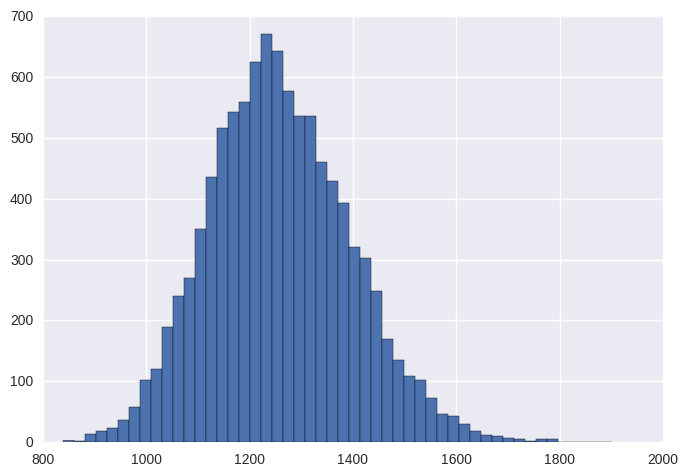

In [19]:
monkey = MonkeyBot(train_phase_data)

start_time = time.time()
iters = 10000

monkey.simulate(iters)
plt.hist(monkey.pv_history_list, bins=50)

print("{0} iterations took {1} seconds".format(iters, time.time() - start_time))

In [20]:
display(pd.Series(monkey.pv_history_list).describe())

count    10000.000000
mean      1258.526213
std        136.991791
min        838.930528
25%       1163.145032
50%       1250.525405
75%       1347.620228
max       1902.236973
dtype: float64


where the mean is 7306.83 and the median is 4962.58. Using the median (due to the high skewness), to get the ROI we can simply do the same calculation again as we did for the patient trader:

$$
(1 + r)^{501/252} = 1.2505$$

$$
\Longrightarrow r = 0.1190963 \approx 11.90\%
$$

#### The Chimp
Now comes our chimp. Across the 3500 rounds of iterations we linearly decrease the chance of our chimp going random (from 1 to 0.001) so that she can explore the data a bit to form her own opinion. With each iteration we can see that the chimp is making more and more profit along the way. 

In [46]:
from collections import defaultdict
from datetime import datetime, timedelta
from copy import deepcopy
from sklearn.ensemble import RandomForestRegressor

class ChimpBot(MonkeyBot):
    """An agent that learns to drive in the smartcab world."""
    # valid_actions = ['Buy', 'Sell', 'Hold']
    valid_actions = ['Buy', 'Sell']

    num_trial = 500
    trial_counter = 0 # For getting the trial number

    random_rounds = 1500 # Number of rounds where the bot chooses to go monkey

    trial_meta_info = {} # For monitoring what happens in each trial

    epsilon = 1
    gamma = 0.75
    random_reward = [0]

    random_counter = 0
    policy_counter = 0

    track_key1 = {'Sell': 0, 'Buy': 0, 'Hold': 0}
    track_key2 = {'Sell': 0, 'Buy': 0, 'Hold': 0}

    track_random_decision = {'Sell': 0, 'Buy': 0, 'Hold': 0}

    reset_counter = 0

    def __init__(self, dfEnv, cash=1000, share=0, pv=0, now_yes_share=0):
        super(ChimpBot, self).__init__(dfEnv, cash, share, pv, now_yes_share)
        # sets self.cash = 1000
        # sets self.share = 0
        # sets self.pv = 0
        # sets self.pv_history_list = []
        # sets self.env = dfEnv
        # implements buy(self, stock_price)
        # implements sell(self, stock_price)
        # implements hold(self)

        self.iter_env = self.env.iterrows()
        self.now_env_index, self.now_row = self.iter_env.next()

        self.now_yes_share = 0
        self.now_action = ''
        # self.now_q = 0

        self.prev_cash = self.cash
        self.prev_share = self.share
        self.prev_pv = self.pv

        self.q_df_columns = list(self.env.columns)
        self.q_df_columns.pop()
        self.q_df_columns.extend(['Yes Share', 'Action', 'Q Value'])
        self.q_df = pd.DataFrame(columns=self.q_df_columns)
        self.q_dict = defaultdict(lambda: (0, 0)) # element of q_dict is (state, act): (q_value, t)
        self.q_dict_analysis = defaultdict(lambda: (0, 0))

        self.negative_reward = 0
        self.n_reward_hisotry = []
        self.net_reward = 0

        self.reset_counter = 0

        # Smartcab use only
        # self.penalty = False
        # self.num_step = 0 # Number of steps for each trial; get reset each time a new trial begins

    def make_q_df(self):
        result_dict = defaultdict(list)

        for index, row in self.q_dict.iteritems():
            for i in range(len(self.q_dict.keys()[0])):
                column_name = 'col' + str(i + 1)
                result_dict[column_name].append(index[i])
            result_dict['Q'].append(self.q_dict[index][0])

        self.q_df = pd.DataFrame(result_dict)
        q_df_column_list = ['col1', 'col2', 'col3', 'col4', 'col5', 'col6', 'col7', 'col8', 'col9', 'col10', 'col11', 'col12', 'col13', 'col14', 'col15', 'col16', 'col17', 'col18', 'col19', 'col20', 'col21', 'col22', 'col23', 'col24', 'col25', 'col26', 'col27', 'col28', 'col29', 'col30', 'col31', 'col32', 'col33', 'col34', 'col35', 'col36', 'col37', 'col38', 'col39', 'Q']
        self.q_df = self.q_df[q_df_column_list]

        def transfer_action(x):
            if x == 'Buy':
                return 1
            elif x == 'Sell':
                return 2
            elif x == 'Hold':
                return 0
            else:
                raise ValueError("Wrong action!")

        def str_float_int(x):
            return int(float(x))

        arr_int = np.vectorize(str_float_int)

        self.q_df['col39'] = self.q_df['col39'].apply(transfer_action)
        self.q_df.ix[:, :-1] = self.q_df.ix[:, :-1].apply(arr_int)

    def split_q_df(self):
        self.q_df_X = self.q_df.ix[:, :-1]
        self.q_df_y = self.q_df.ix[:, -1]
        # self.X_train, self.X_test, self.y_train, self.y_test = cross_validation.train_test_split(self.q_df_X, self.q_df_y, test_size=0.1, random_state=0)

    def train_on_q_df(self):
        reg = RandomForestRegressor(n_estimators=128, max_features='sqrt', n_jobs=-1, random_state=0)
        self.q_reg = reg
        self.q_reg = self.q_reg.fit(self.q_df_X, self.q_df_y)

    def update_q_model(self):
        print("Updating Q model...")
        start_time = time.time()
        self.make_q_df()
        self.split_q_df()
        self.train_on_q_df()
#         print("Update took {} seconds".format(time.time() - start_time))

    def from_state_action_predict_q(self, state_action):
        state_action = [state_action]

        pred_q = self.q_reg.predict(state_action)

        return pred_q

    def yes_share(self):
        # Represent chimp asset in state_action
        if self.share > 0:
            return 1
        else:
            return 0

    def max_q(self, now_row):
        def transfer_action(x):
            if x == 'Buy':
                return 1
            elif x == 'Sell':
                return 2
            elif x == 'Hold':
                return 0
            else:
                raise ValueError("Wrong action!")

        def str_float_int(x):
            return int(float(x))

        now_row2 = list(now_row)
        now_row2.append(self.now_yes_share)
        max_q = ''
        q_compare_dict = {}

        if len(now_row2) > 38:
            raise ValueError("Got ya bastard! @ MaxQ")

        # Populate the q_dict
        for act in set(self.valid_actions):
            now_row2.append(act)
            now_row_key = tuple(now_row2)

            _ = self.q_dict[now_row_key]

            # # K-Q Algorithm
            # if np.random.choice(2, p = [0.9, 0.1]) == 1 and len(self.q_dict) > 30000:
            # if _[1] == 0 and np.random.choice(2, p = [0.7, 0.3]) == 1 and len(self.q_dict) > 30000:
            try:
                self.q_reg
            except AttributeError:
                pass
                # print('No q_reg yet...going with default.')
            else:
                if _[1] == 0:
                    # print("Dreaming mode...")
                    # start_time = time.time()
                    # self.update_q_model()

                    single_X = np.array(now_row_key)
                    # print(single_X)
                    arr_int = np.vectorize(str_float_int)
                    single_X[-1] = transfer_action(single_X[-1])
                    single_X = arr_int(single_X)
                    single_X = single_X.reshape(1, -1)
                    pred_q = self.q_reg.predict(single_X)
                    dreamed_q = (1 - (1 / (self.q_dict[now_row_key][1] + 1))) * self.q_dict[now_row_key][0] + (1 / (self.q_dict[now_row_key][1] + 1)) * pred_q[0]
                    self.q_dict[now_row_key] = (dreamed_q, self.q_dict[now_row_key][1] + 1)
                    # print("Q-dreamed: {0} for Act: {1}, taking {2} seconds.".format(self.q_dict[now_row_key], act, time.time() - start_time))

            # print(act, self.q_dict[now_row_key])

            q_compare_dict[now_row_key] = self.q_dict[now_row_key]
            now_row2.pop()

        try:
            max(q_compare_dict.iteritems(), key=lambda x:x[1])
        except ValueError:
            print("Wrong Q Value in Q Compare Dict!")
        else:
            key, qAndT = max(q_compare_dict.iteritems(), key=lambda x:x[1])
            # print("Action: {0}, with Q-value: {1}".format(key[-1], qAndT[0]))
            return key[-1], qAndT[0], qAndT[1]

    def q_update(self):
        # print("Data Index: {}".format(self.now_env_index))
        now_states = list(self.now_row)
        # now_states = list(now_states)
        now_states.pop() # disregard the Trade Price

        prev_states = list(self.prev_states)

        if len(prev_states) > 37:
            raise ValueError("Got ya bastard! @ Q_Update...something wrong with the self.prev_states!!!")

        prev_states.append(self.prev_yes_share)
        prev_states.append(self.prev_action)
        prev_states_key = tuple(prev_states)

        if len(prev_states_key) > 39:
            raise ValueError("Got ya bastard! @ Q_Update")

        q_temp = self.q_dict[prev_states_key]

        q_temp0 = (1 - (1 / (q_temp[1] + 1))) * q_temp[0] + (1 / (q_temp[1] + 1)) * (self.reward + self.gamma * self.max_q(now_states)[1])

        if prev_states_key[:-1] == ('Low', 'Low', 'Average', 'Average', 'Low', 'Average', 'Average', 'Average', 'Low', 'Low', 'Low', 'Low', 'Low', 'Very Low', 'Very Low', 'Very Low', 'Very Low', 'N-Very Low', 'Low', 'Average', 'N-Very Low', 'Very Low', 'Very Low', 'Very Low', 'Very Low', 'Very Low', 'Very Low', 'Very Low', 'Low', 'Very Low', 'Very Low', 'Very Low', 'Very Low', 'Very Low', 'Very Low', 'Very Low', 'High', 'Yes'):
            self.track_key1[prev_states_key[-1]] += 1
        elif prev_states_key[:-1] == ('Low', 'Low', 'Average', 'Average', 'Low', 'Average', 'Average', 'Average', 'Low', 'Low', 'Low', 'Low', 'Low', 'Very Low', 'Very Low', 'Very Low', 'Very Low', 'N-Very Low', 'Low', 'Average', 'N-Very Low', 'Very Low', 'Very Low', 'Very Low', 'Very Low', 'Very Low', 'Very Low', 'Very Low', 'Low', 'Very Low', 'Very Low', 'Very Low', 'Very Low', 'Very Low', 'Very Low', 'Very Low', 'High', 'No'):
            self.track_key2[prev_states_key[-1]] += 1
        # elif prev_states_key[:-1] == ('Very High', 'Very High', 'Very High', 'Very High', 'Very High', 'Very High', 'Average', 'High', 'Average', 'Average', 'Average', 'Low', 'Average', 'Very Low', 'Low', 'N-Very Low', 'N-Very Low', 'N-Very Low', 'N-Very Low', 'Very Low', 'Very Low', 'Average', 'Very Low', 'Low', 'Low', 'Low', 'Very Low', 'Very Low', 'Very Low', 'Very Low', 'Very Low', 'Very Low', 'Low', 'Very Low', 'Low', 'Very Low', 'Average', 'No'):
        #     self.track_key2[prev_states_key[-1]] += 1

        self.q_dict[prev_states_key] = (q_temp0, q_temp[1] + 1)
        # For analysis purpose
        self.q_dict_analysis[prev_states_key] = (q_temp0, self.prev_env_index)
        # print("Now Action: {}".format())
        # print(prev_states_key)
        return (self.q_dict[prev_states_key])

    def policy(self, now_row):
        return self.max_q(now_row)[0]

    def reset(self):
        # Portfolio change over iterations
        self.pv_history_list.append(self.pv + self.cash)

        self.iter_env = self.env.iterrows()
        self.now_env_index, self.now_row = self.iter_env.next()

        self.cash = 1000
        self.share = 0
        self.pv = 0

        self.prev_cash = self.cash
        self.prev_share = self.share
        self.prev_pv = self.pv

        if self.epsilon - 1/self.random_rounds > 0.001: # Epislon threshold: 0.01
            self.random_counter += 1
            self.epsilon = self.epsilon - 1/self.random_rounds
        else:
            self.epsilon = 0.001 # Epislon threshold: 0.1
            self.policy_counter += 1

        self.net_reward = 0

        self.reset_counter += 1

        if self.reset_counter % 1500 == 0:
            self.update_q_model()

        # self.num_step = 0 # Recalculate the steps for the new trial
        # self.penalty = False
        # self.fail = False

    def make_decision(self, now_row):
        return self.policy(now_row)

    def update(self):
        # Update state
        now_states = list(self.now_row)

        if len(now_states) > 38:
            print(now_states)
            raise ValueError("Got ya bastard! @ Q_Update...something wrong with the self.now_row!!!")

        # now_states = list(now_states)
        # print(type(self.now_row))
        now_states.pop() # disregard the Trade Price

        if len(now_states) > 37:
            print(now_states)
            raise ValueError("Got ya bastard! @ Q_Update...something wrong with now_states after pop!!!")

        # Exploitation-exploration decisioning
        random.seed(datetime.now())
        self.decision = np.random.choice(2, p = [self.epsilon, 1 - self.epsilon]) # decide to go random or with the policy
        # self.decision = 0 # Force random mode

        # print("Random decision: {0}, Epislon: {1}".format(self.decision, self.epsilon))
        # print("What the FUCK?!")
        if self.decision == 0: # if zero, go random
            random.seed(datetime.now())
            action = random.choice(self.valid_actions)
            if tuple(now_states) == ('Low', 'Low', 'Average', 'Average', 'Low', 'Average', 'Average', 'Average', 'Low', 'Low', 'Low', 'Low', 'Low', 'Very Low', 'Very Low', 'Very Low', 'Very Low', 'N-Very Low', 'Low', 'Average', 'N-Very Low', 'Very Low', 'Very Low', 'Very Low', 'Very Low', 'Very Low', 'Very Low', 'Very Low', 'Low', 'Very Low', 'Very Low', 'Very Low', 'Very Low', 'Very Low', 'Very Low', 'Very Low', 'High'):
                self.track_random_decision[action] += 1
        else: # else go with the policy
            # print("now_states: {}".format(now_states))
            self.now_yes_share = self.yes_share()
            action = self.make_decision(now_states)

        if len(now_states) > 37:
            print(now_states)
            raise ValueError("Got ya bastard! @ Q_Update...something wrong with now_states after make_decision!!!")

        # print("Now Action Real: {}".format(action))
        # Execute action and get reward
        if action == 'Buy':
            # print(self.now_row)
            self.buy(self.now_row[-1])
        elif action == 'Sell':
            # print(self.now_row)
            self.sell(self.now_row[-1])
        elif action == 'Hold':
            # print(self.now_row)
            self.hold(self.now_row[-1])
        else:
            raise ValueError("Wrong action man!")

        try:
            self.prev_states
        except AttributeError:
            print("Running the first time...no prevs exist.")
        else:
            self.reward = ((self.cash - self.prev_cash) + (self.pv - self.prev_pv)) / (self.prev_cash + self.prev_pv)
            self.q_update()

        self.prev_states = now_states

        if len(now_states) > 37:
            raise ValueError("Got ya bastard! @ Q_Update...something wrong with the now_states!!!")

        self.now_action = action
        self.prev_action = action
        self.prev_yes_share = self.now_yes_share
        self.prev_env_index = deepcopy(self.now_env_index)
        self.prev_cash = self.cash
        self.prev_share = self.share
        self.prev_pv = self.pv

        # if len(self.q_dict) > 20000:
        #     self.update_q_model()

        try:
            self.now_env_index, self.now_row = self.iter_env.next()
        except StopIteration:
            pass
            # print("End of data.")
        else:
            pass

        # if reward < 0:
        #     self.penalty = True

        try:
            _ = self.reward
        except AttributeError:
            print("No reward yet...0 assigned.")
            self.reward = 0
        # print "ChimpBot.update(): Action: {0} at Price: {1}, Cash: {2}, Num_Share: {3}, Cash + PV = {4}, Reward = {5}".format(action, self.now_row[-1], self.cash, self.share, self.cash + self.pv, self.reward)  # [debug]
        # print('Portfolio + Cash: {}'.format(self.cash + self.pv))
        # print("================================")



In [47]:
train_phase_data.head()

,-1d_Vol1,-2d_Vol1,-3d_Vol1,-4d_Vol1,-5d_Vol1,10d_Avg_Vol1,21d_Avg_Vol1,63d_Avg_Vol1,-1d_Vol2,-2d_Vol2,-3d_Vol2,-4d_Vol2,-5d_Vol2,-1d_Spread,-2d_Spread,-3d_Spread,-4d_Spread,-5d_Spread,10d_Spread,21d_Spread,63d_Spread,-1d_upperwick,-2d_upperwick,-3d_upperwick,-4d_upperwick,-5d_upperwick,10d_upperwick,21d_upperwick,63d_upperwick,-1d_lowerwick,-2d_lowerwick,-3d_lowerwick,-4d_lowerwick,-5d_lowerwick,10d_lowerwick,21d_lowerwick,63d_lowerwick,Trade Price
2012-09-28,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,-5.0,4.0,-5.0,-1.0,2.0,2.0,2.0,3.0,0.0,2.0,2.0,1.0,1.0,1.0,2.0,3.0,1.0,1.0,1.0,1.0,1.0,2.0,36.244154
2012-10-01,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,-5.0,4.0,-1.0,2.0,2.0,1.0,2.0,3.0,0.0,2.0,1.0,1.0,1.0,2.0,2.0,3.0,1.0,1.0,1.0,1.0,1.0,36.675015
2012-10-02,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,-5.0,-1.0,2.0,2.0,4.0,1.0,2.0,3.0,0.0,1.0,1.0,1.0,1.0,2.0,2.0,3.0,1.0,1.0,1.0,1.0,36.713530
2012-10-03,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,-2.0,1.0,1.0,2.0,1.0,-1.0,2.0,2.0,1.0,4.0,1.0,2.0,3.0,1.0,1.0,1.0,3.0,1.0,2.0,2.0,3.0,1.0,1.0,1.0,36.862860
2012-10-04,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,1.0,1.0,1.0,1.0,-2.0,1.0,1.0,2.0,1.0,2.0,3.0,1.0,1.0,4.0,1.0,2.0,1.0,1.0,1.0,3.0,3.0,1.0,2.0,2.0,1.0,1.0,1.0,37.558589


In [48]:
# Start simulation for the chimp
num_iter = 1500
day_count = 0
pv_history_list = []

chimp = ChimpBot(train_phase_data)

start_time = time.time()

for i in range(num_iter):
    for l in range(len(chimp.env)):
        chimp.update()
    pv_history_list.append(chimp.cash + chimp.pv)
    chimp.reset()

print("{0} rounds of training took {1} seconds".format(num_iter, time.time() - start_time))

print(pv_history_list[-1])

# Convert Q-Table to Dataframe from trained chimp (full)
result_dict = defaultdict(list)
for index, row in chimp.q_dict_analysis.iteritems():
    for i in range(len(chimp.q_dict_analysis.keys()[0])):
        column_name = 'col' + str(i + 1)
        result_dict[column_name].append(index[i])
    result_dict['Q'].append(chimp.q_dict_analysis[index][0])
    result_dict['Date'].append(chimp.q_dict_analysis[index][1])

train_phase_q_df = pd.DataFrame(result_dict)

Running the first time...no prevs exist.
No reward yet...0 assigned.
Updating Q model...
1500 rounds of training took 182.782536983 seconds
8018.99062878


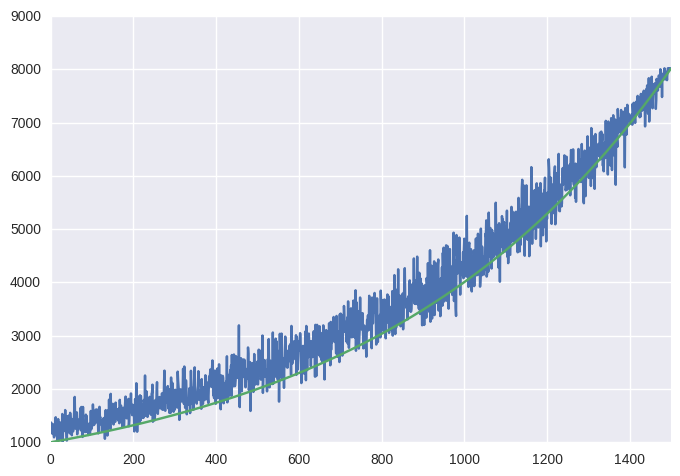

In [49]:
pd.Series(pv_history_list).plot()
x = np.arange(1500)
# delta = np.random.uniform(-10,10, size=(1500,))
y = 1000 * np.exp((np.log(8.019) / 1500) * x)
plt.plot(x, y)
plt.show()

However, we can also see that the Q values are in no way near to convergence. This is due to the vastness of the state-action space. Unfortuntely we do not have enough resource to see them converge. Still, this gives us a clear idea that her policy function though not optimzal, is indeed improving fast.

Just for fun, let's look at the annual ROI:

$$
(1 + r)^{501/252} = 8.0189
$$

$$
	\Longrightarrow r = 1.849472 \approx 184.95\%
$$

Now it's time to find out if we can somewhat generalize this in the new data.

In [54]:
# September 29, 2014 to September 27, 2015

start_date = datetime(2014, 9, 29)
print("{0} Trade Price: {1}".format(start_date, data_full.ix[start_date, 'Trade Price']))
print("{0} Trade Price: {1}".format(start_date + timedelta(days=364), data_full.ix[start_date + timedelta(days=364), 'Trade Price']))

validation_phase_data = data_full.ix[start_date:start_date + timedelta(days=364), :]
print(len(validation_phase_data))


2014-09-29 00:00:00 Trade Price: 57.000705733
2015-09-28 00:00:00 Trade Price: 58.5391251133
252


#### Validation phase
##### The Patient Trader
###### Start
$Cash_{init} = 1000.00$

$Share_{init} = 0$

$PV_{init} = 0$

$Trading \ Price_{init} = 57.00$

----------------

$Share_{start} = floor(\frac{1000.00}{57.00}) = 17$

$PV_{start} = 57.00 \cdot 17 = 969.00$

$Cash_{start} = Cash_{init} - PV_{start} = 1000.00 - 969.00 = 31.00$

$Total \ Assets_{start} = Cash_{start} + PV_{start} = 31.00 + 969.00 = 1000.00$

##### End
###### Final Condition
$Cash_{end} = 31.00$
$Share_{end} = 17$
$Trading \ Price_{end} = 58.54$

----------------

$PV_{end} = 58.54 \cdot 17 = 995.18$

$Total \ Assets_{start}  = Cash_{end} + PV_{end} = 31.00 + 995.18 = 1026.18$

We can calculate the annual ROI by solving the following equation for $r$:
$$
(1 + r)^{252/252} = 1.0262
$$

$$
\Longrightarrow r = 0.0262 \approx 2.62\%
$$

#### The Monkey

10000 iterations took 11.3841061592 seconds


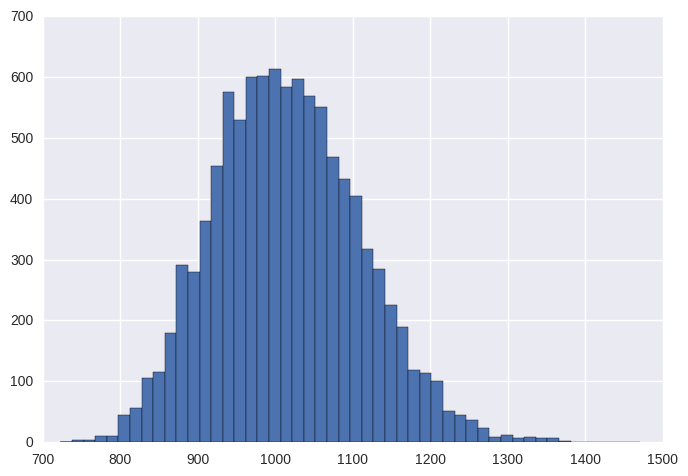

In [58]:
monkey_validation = MonkeyBot(validation_phase_data)

start_time = time.time()
iters = 10000

monkey_validation.simulate(iters)
plt.hist(monkey_validation.pv_history_list, bins=50)

print("{0} iterations took {1} seconds".format(iters, time.time() - start_time))

In [59]:
statistics = pd.Series(monkey_validation.pv_history_list)
print(statistics.describe())

count    10000.000000
mean      1015.513510
std         94.566167
min        722.455412
25%        947.137485
50%       1010.579794
75%       1078.274456
max       1470.529413
dtype: float64


We can calculate the annual ROI by solving the following equation for $r$:
$$
(1 + r)^{252/252} = 1.0106
$$

$$
\Longrightarrow r = 0.0106 \approx 1.06\%
$$

#### The Chimp

In [197]:
# Start simulation for the chimp ------ for analytics purpose
num_iter = 1500
day_count = 0
pv_history_list = []

chimp_analytics = ChimpBot(data_full)

start_time = time.time()

for i in range(num_iter):
    for l in range(len(chimp_analytics.env)):
        chimp_analytics.update()
    pv_history_list.append(chimp_analytics.cash + chimp_analytics.pv)
    chimp_analytics.reset()

print("{0} rounds of training took {1} seconds".format(num_iter, time.time() - start_time))

print(pv_history_list[-1])

# Convert Q-Table to Dataframe from trained chimp (full)
result_dict = defaultdict(list)
for index, row in chimp_analytics.q_dict_analysis.iteritems():
    for i in range(len(chimp_analytics.q_dict_analysis.keys()[0])):
        column_name = 'col' + str(i + 1)
        result_dict[column_name].append(index[i])
    result_dict['Q'].append(chimp_analytics.q_dict_analysis[index][0])
    result_dict['Date'].append(chimp_analytics.q_dict_analysis[index][1])

full_q_df = pd.DataFrame(result_dict)

Running the first time...no prevs exist.
No reward yet...0 assigned.
Updating Q model...
1500 rounds of training took 3080.55156112 seconds
2.28406234621e+26


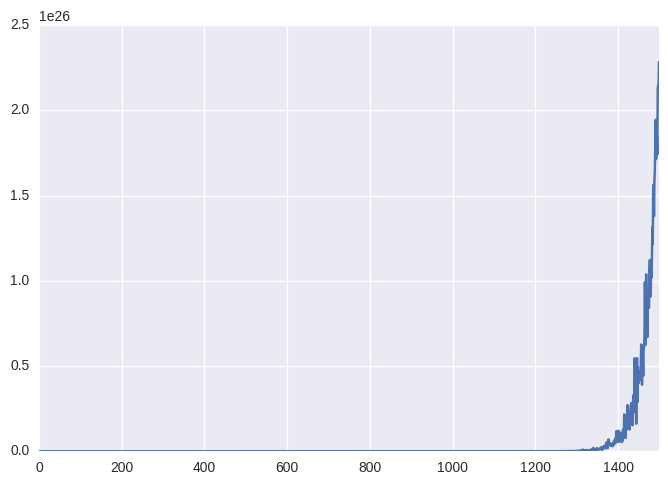

In [198]:
pd.Series(pv_history_list).plot()
# x = np.arange(1500)
# delta = np.random.uniform(-10,10, size=(1500,))
# y = 1000 * np.exp((np.log(8.019) / 1500) * x)
# plt.plot(x, y)
# plt.show()

In [199]:
column_list = ['col1', 'col2', 'col3', 'col4', 'col5', 'col6', 'col7', 'col8', 'col9', 'col10', 'col11', 'col12', 'col13', 'col14', 'col15', 'col16', 'col17', 'col18', 'col19', 'col20', 'col21', 'col22', 'col23', 'col24', 'col25', 'col26', 'col27', 'col28', 'col29', 'col30', 'col31', 'col32', 'col33', 'col34', 'col35', 'col36', 'col37', 'col38', 'col39', 'Date', 'Q']
full_q_df = full_q_df[column_list]
full_q_df.sort_values('Date', inplace=True)
full_q_df.reset_index(inplace=True)
del full_q_df['index']

full_q_df.reset_index(inplace=True)
del full_q_df['index']

full_q_df.set_index(full_q_df['Date'], inplace=True)
del full_q_df.index.name
del full_q_df['Date']

print(len(full_q_df))
display(full_q_df.head())

32624


,col1,col2,col3,col4,col5,col6,col7,col8,col9,col10,col11,col12,col13,col14,col15,col16,col17,col18,col19,col20,col21,col22,col23,col24,col25,col26,col27,col28,col29,col30,col31,col32,col33,col34,col35,col36,col37,col38,col39,Q
1984-05-23,1.0,5.0,1.0,2.0,1.0,2.0,2.0,3.0,1.0,2.0,1.0,1.0,1.0,-5.0,-5.0,4.0,-4.0,-2.0,-3.0,-2.0,-3.0,3.0,0.0,2.0,2.0,0.0,0.0,3.0,2.0,5.0,0.0,0.0,2.0,3.0,1.0,1.0,1.0,1,Buy,0.006097
1984-05-23,1.0,5.0,1.0,2.0,1.0,2.0,2.0,3.0,1.0,2.0,1.0,1.0,1.0,-5.0,-5.0,4.0,-4.0,-2.0,-3.0,-2.0,-3.0,3.0,0.0,2.0,2.0,0.0,0.0,3.0,2.0,5.0,0.0,0.0,2.0,3.0,1.0,1.0,1.0,0,Buy,0.008225
1984-05-23,1.0,5.0,1.0,2.0,1.0,2.0,2.0,3.0,1.0,2.0,1.0,1.0,1.0,-5.0,-5.0,4.0,-4.0,-2.0,-3.0,-2.0,-3.0,3.0,0.0,2.0,2.0,0.0,0.0,3.0,2.0,5.0,0.0,0.0,2.0,3.0,1.0,1.0,1.0,1,Sell,0.004043
1984-05-23,1.0,5.0,1.0,2.0,1.0,2.0,2.0,3.0,1.0,2.0,1.0,1.0,1.0,-5.0,-5.0,4.0,-4.0,-2.0,-3.0,-2.0,-3.0,3.0,0.0,2.0,2.0,0.0,0.0,3.0,2.0,5.0,0.0,0.0,2.0,3.0,1.0,1.0,1.0,0,Sell,0.004438
1984-05-24,2.0,1.0,5.0,1.0,2.0,2.0,2.0,3.0,1.0,1.0,2.0,1.0,1.0,-5.0,-5.0,-5.0,4.0,-4.0,-3.0,-3.0,-3.0,4.0,3.0,0.0,2.0,2.0,1.0,2.0,2.0,0.0,5.0,0.0,0.0,2.0,0.0,0.0,0.0,0,Buy,0.002913


In [264]:
# validation_phase_q_df.to_csv("old_q_df_full.csv")
full_q_df = pd.DataFrame.from_csv("old_q_df_full.csv")

In [265]:
display(full_q_df.head())

,col1,col2,col3,col4,col5,col6,col7,col8,col9,col10,col11,col12,col13,col14,col15,col16,col17,col18,col19,col20,col21,col22,col23,col24,col25,col26,col27,col28,col29,col30,col31,col32,col33,col34,col35,col36,col37,col38,col39,Q
1984-05-23,1.0,5.0,1.0,2.0,1.0,2.0,2.0,3.0,1.0,2.0,1.0,1.0,1.0,-5.0,-5.0,4.0,-4.0,-2.0,-3.0,-2.0,-3.0,3.0,0.0,2.0,2.0,0.0,0.0,3.0,2.0,5.0,0.0,0.0,2.0,3.0,1.0,1.0,1.0,1,Buy,0.006097
1984-05-23,1.0,5.0,1.0,2.0,1.0,2.0,2.0,3.0,1.0,2.0,1.0,1.0,1.0,-5.0,-5.0,4.0,-4.0,-2.0,-3.0,-2.0,-3.0,3.0,0.0,2.0,2.0,0.0,0.0,3.0,2.0,5.0,0.0,0.0,2.0,3.0,1.0,1.0,1.0,0,Buy,0.008225
1984-05-23,1.0,5.0,1.0,2.0,1.0,2.0,2.0,3.0,1.0,2.0,1.0,1.0,1.0,-5.0,-5.0,4.0,-4.0,-2.0,-3.0,-2.0,-3.0,3.0,0.0,2.0,2.0,0.0,0.0,3.0,2.0,5.0,0.0,0.0,2.0,3.0,1.0,1.0,1.0,1,Sell,0.004043
1984-05-23,1.0,5.0,1.0,2.0,1.0,2.0,2.0,3.0,1.0,2.0,1.0,1.0,1.0,-5.0,-5.0,4.0,-4.0,-2.0,-3.0,-2.0,-3.0,3.0,0.0,2.0,2.0,0.0,0.0,3.0,2.0,5.0,0.0,0.0,2.0,3.0,1.0,1.0,1.0,0,Sell,0.004438
1984-05-24,2.0,1.0,5.0,1.0,2.0,2.0,2.0,3.0,1.0,1.0,2.0,1.0,1.0,-5.0,-5.0,-5.0,4.0,-4.0,-3.0,-3.0,-3.0,4.0,3.0,0.0,2.0,2.0,1.0,2.0,2.0,0.0,5.0,0.0,0.0,2.0,0.0,0.0,0.0,0,Buy,0.002913


In [274]:
def action_to_int(string):
    if string == 'Buy':
        return 1
    elif string == 'Sell':
        return 2
    else:
        return string

full_q_df['col39'] = full_q_df['col39'].apply(action_to_int)

In [394]:
# Set date range
analysis_start_date = datetime(2014, 9, 29)
analysis_end_date = datetime(2014, 10, 29)
analysis_q_df = full_q_df[analysis_start_date:analysis_end_date]

(u, ) = data_full.index.get_indexer_for([analysis_start_date])
(v, ) = data_full.index.get_indexer_for([analysis_end_date])

print(u, w)
date_range = data_full.index[u:v + 1]

print(len(date_range))
print("Number of dates: {}".format(len(date_range)))

# best_actions = []

# for date in date_range:  
#     max_q = [0, -1]
#     for i, r in validation_phase_q_df.ix[date].iterrows():
# #         print(r['col39'], r['Q'])
#         if r['Q'] > max_q[1]:
#             max_q = [r['col39'], r['Q']]
#     best_actions.append(max_q[0])

print("Number of actions: {}".format(len(best_actions)))

(7652, 7652)
23
Number of dates: 23
Number of actions: 7


In [288]:
u

7652

In [381]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score

start_time = time.time()

accs = []

training_sizes = 48
testing_size = 7

# Loop through all batches in validation dataset
(u, ) = data_full.index.get_indexer_for([validation_phase_data.index[0]])
for d in range(u, u + testing_size * (252 // testing_size), testing_size):
    acc_num_train_months = []
    
#     Dates in the batch
    date_range = data_full.iloc[d:d + testing_size].index
#     print(date_range)
    
    # Loop through all sizes of training sets
    for num_train_month in range(1, training_sizes + 1):  
#     for num_train_month in range(1, 240 + 1):
        # Prepare Training/Testing Datasets
        X_train = full_q_df.iloc[d - (int(21 * num_train_month)):d, :-1]
        y_train = full_q_df.iloc[d - (int(21 * num_train_month)):d, -1]
        X_test = full_q_df.ix[date_range, :-1]
        y_test = full_q_df.ix[date_range, -1]

        # Fit data and make predictions
        reg = RandomForestRegressor(n_estimators=1500, max_features='sqrt', oob_score=True, n_jobs=-1, random_state=0)
        reg.fit(X_train, y_train)

        y_pred = reg.predict(X_test)
        y_fit = reg.predict(X_train)

        pred_q = y_pred
        actions = X_test['col39']
        data = {'Action': actions, 'Q': pred_q}
        df_pred = pd.DataFrame(data=data, index=y_test.index)

        pred_actions = []

        for date in date_range:  
            max_q = [0, -1]
            for i, r in df_pred.ix[date].iterrows():
                if r['Q'] > max_q[1]:
                    max_q = [r['Action'], r['Q']]
            pred_actions.append(max_q[0])
            
        best_actions = []

        for date in date_range:
            max_q = [0, -1]
            for i, r in full_q_df.ix[date].iterrows():
                if r['Q'] > max_q[1]:
                    max_q = [r['col39'], r['Q']]
            best_actions.append(max_q[0])

        acc_num_train_months.append(accuracy_score(best_actions, pred_actions))
    accs.append(np.array(acc_num_train_months))
    print("Batch {} completed.".format(d + 1 - u))
    harmonic_means = np.power(reduce(lambda x,y: x*y, accs), (1/len(accs)))
    arithmetic_means = reduce(lambda x,y: x+y, accs) / len(accs)
    print("Harmonic Means Max: {}".format((np.argmax(harmonic_means) + 1, np.max(harmonic_means))))
    print("Arithemtic Means Max: {}".format((np.argmax(arithmetic_means) + 1, np.max(arithmetic_means))))
    
print("Grid search best num_train_year took {} seconds:".format(time.time() - start_time))

Batch 7653 completed.
Harmonic Means Max: (25, 0.8571428571428571)
Arithemtic Means Max: (25, 0.8571428571428571)
Batch 7660 completed.
Harmonic Means Max: (9, 0.78246079643595157)
Arithemtic Means Max: (9, 0.7857142857142857)
Batch 7667 completed.
Harmonic Means Max: (25, 0.80660231046945297)
Arithemtic Means Max: (25, 0.80952380952380942)
Batch 7674 completed.
Harmonic Means Max: (25, 0.7400057326032432)
Arithemtic Means Max: (25, 0.75)
Batch 7681 completed.
Harmonic Means Max: (25, 0.61175067666809246)
Arithemtic Means Max: (25, 0.65714285714285714)
Batch 7688 completed.
Harmonic Means Max: (25, 0.60483796086441666)
Arithemtic Means Max: (25, 0.64285714285714279)
Batch 7695 completed.
Harmonic Means Max: (25, 0.57579163488765939)
Arithemtic Means Max: (25, 0.61224489795918369)
Batch 7702 completed.
Harmonic Means Max: (25, 0.52750147301486938)
Arithemtic Means Max: (25, 0.5714285714285714)
Batch 7709 completed.
Harmonic Means Max: (25, 0.566353661558614)
Arithemtic Means Max: (25, 0

In [374]:
# testing_size = 21
# Harmonic Means Max: (7, 0.56689442248955335)
# Arithemtic Means Max: (7, 0.57142857142857129)

36


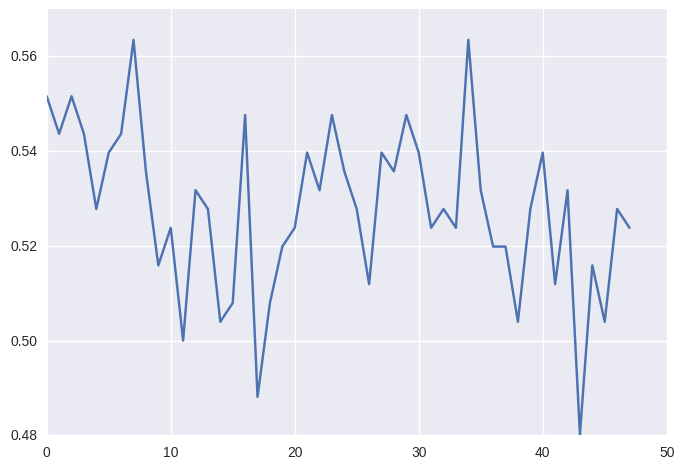

In [391]:
print(len(accs))
plt.plot(arithmetic_means[:])

In [328]:
print(np.percentile(monkey_validation.pv_history_list, 57))

1028.69169603


In [362]:
from collections import defaultdict
from datetime import datetime, timedelta
from copy import deepcopy
from sklearn.ensemble import RandomForestRegressor

class ChimpBot(MonkeyBot):
    """An agent that learns to drive in the smartcab world."""
    # valid_actions = ['Buy', 'Sell', 'Hold']
    valid_actions = ['Buy', 'Sell']

    num_trial = 500
    trial_counter = 0 # For getting the trial number

    random_rounds = 1500 # Number of rounds where the bot chooses to go monkey

    trial_meta_info = {} # For monitoring what happens in each trial

    epsilon = 1
    gamma = 0.75
    random_reward = [0]

    random_counter = 0
    policy_counter = 0

    track_key1 = {'Sell': 0, 'Buy': 0, 'Hold': 0}
    track_key2 = {'Sell': 0, 'Buy': 0, 'Hold': 0}

    track_random_decision = {'Sell': 0, 'Buy': 0, 'Hold': 0}

    reset_counter = 0

    def __init__(self, dfEnv, cash=1000, share=0, pv=0, now_yes_share=0):
        super(ChimpBot, self).__init__(dfEnv, cash, share, pv, now_yes_share)
        # sets self.cash = 1000
        # sets self.share = 0
        # sets self.pv = 0
        # sets self.pv_history_list = []
        # sets self.env = dfEnv
        # implements buy(self, stock_price)
        # implements sell(self, stock_price)
        # implements hold(self)

        self.iter_env = self.env.iterrows()
        self.now_env_index, self.now_row = self.iter_env.next()

        self.now_yes_share = 0
        self.now_action = ''
        # self.now_q = 0

        self.prev_cash = self.cash
        self.prev_share = self.share
        self.prev_pv = self.pv

        self.q_df_columns = list(self.env.columns)
        self.q_df_columns.pop()
        self.q_df_columns.extend(['Yes Share', 'Action', 'Q Value'])
        self.q_df = pd.DataFrame(columns=self.q_df_columns)
        self.q_dict = defaultdict(lambda: (0, 0)) # element of q_dict is (state, act): (q_value, t)
        self.q_dict_analysis = defaultdict(lambda: (0, 0))

        self.action_list = []
        
        self.negative_reward = 0
        self.n_reward_hisotry = []
        self.net_reward = 0

        self.reset_counter = 0

        # Smartcab use only
        # self.penalty = False
        # self.num_step = 0 # Number of steps for each trial; get reset each time a new trial begins

    def make_q_df(self):
        result_dict = defaultdict(list)

        for index, row in self.q_dict.iteritems():
            for i in range(len(self.q_dict.keys()[0])):
                column_name = 'col' + str(i + 1)
                result_dict[column_name].append(index[i])
            result_dict['Q'].append(self.q_dict[index][0])

        self.q_df = pd.DataFrame(result_dict)
        q_df_column_list = ['col1', 'col2', 'col3', 'col4', 'col5', 'col6', 'col7', 'col8', 'col9', 'col10', 'col11', 'col12', 'col13', 'col14', 'col15', 'col16', 'col17', 'col18', 'col19', 'col20', 'col21', 'col22', 'col23', 'col24', 'col25', 'col26', 'col27', 'col28', 'col29', 'col30', 'col31', 'col32', 'col33', 'col34', 'col35', 'col36', 'col37', 'col38', 'col39', 'Q']
        self.q_df = self.q_df[q_df_column_list]

        def transfer_action(x):
            if x == 'Buy':
                return 1
            elif x == 'Sell':
                return 2
            elif x == 'Hold':
                return 0
            else:
                raise ValueError("Wrong action!")

        def str_float_int(x):
            return int(float(x))

        arr_int = np.vectorize(str_float_int)

        self.q_df['col39'] = self.q_df['col39'].apply(transfer_action)
        self.q_df.ix[:, :-1] = self.q_df.ix[:, :-1].apply(arr_int)

    def split_q_df(self):
        self.q_df_X = self.q_df.ix[:, :-1]
        self.q_df_y = self.q_df.ix[:, -1]
        # self.X_train, self.X_test, self.y_train, self.y_test = cross_validation.train_test_split(self.q_df_X, self.q_df_y, test_size=0.1, random_state=0)

    def train_on_q_df(self):
        reg = RandomForestRegressor(n_estimators=128, max_features='sqrt', n_jobs=-1, random_state=0)
        self.q_reg = reg
        self.q_reg = self.q_reg.fit(self.q_df_X, self.q_df_y)

    def update_q_model(self):
        print("Updating Q model...")
        start_time = time.time()
        self.make_q_df()
        self.split_q_df()
        self.train_on_q_df()
#         print("Update took {} seconds".format(time.time() - start_time))

    def from_state_action_predict_q(self, state_action):
        state_action = [state_action]

        pred_q = self.q_reg.predict(state_action)

        return pred_q

    def yes_share(self):
        # Represent chimp asset in state_action
        if self.share > 0:
            return 1
        else:
            return 0

    def max_q(self, now_row):
        def transfer_action(x):
            if x == 'Buy':
                return 1
            elif x == 'Sell':
                return 2
            elif x == 'Hold':
                return 0
            else:
                raise ValueError("Wrong action!")

        def str_float_int(x):
            return int(float(x))

        now_row2 = list(now_row)
        now_row2.append(self.now_yes_share)
        max_q = ''
        q_compare_dict = {}

        if len(now_row2) > 38:
            raise ValueError("Got ya bastard! @ MaxQ")

        # Populate the q_dict
        for act in set(self.valid_actions):
            now_row2.append(act)
            now_row_key = tuple(now_row2)

            _ = self.q_dict[now_row_key]

            # # K-Q Algorithm
            # if np.random.choice(2, p = [0.9, 0.1]) == 1 and len(self.q_dict) > 30000:
            # if _[1] == 0 and np.random.choice(2, p = [0.7, 0.3]) == 1 and len(self.q_dict) > 30000:
            try:
                self.q_reg
            except AttributeError:
                pass
                # print('No q_reg yet...going with default.')
            else:
                if _[1] == 0:
                    # print("Dreaming mode...")
                    # start_time = time.time()
                    # self.update_q_model()

                    single_X = np.array(now_row_key)
                    # print(single_X)
                    arr_int = np.vectorize(str_float_int)
                    single_X[-1] = transfer_action(single_X[-1])
                    single_X = arr_int(single_X)
                    single_X = single_X.reshape(1, -1)
                    pred_q = self.q_reg.predict(single_X)
                    dreamed_q = (1 - (1 / (self.q_dict[now_row_key][1] + 1))) * self.q_dict[now_row_key][0] + (1 / (self.q_dict[now_row_key][1] + 1)) * pred_q[0]
                    self.q_dict[now_row_key] = (dreamed_q, self.q_dict[now_row_key][1] + 1)
                    # print("Q-dreamed: {0} for Act: {1}, taking {2} seconds.".format(self.q_dict[now_row_key], act, time.time() - start_time))

            # print(act, self.q_dict[now_row_key])

            q_compare_dict[now_row_key] = self.q_dict[now_row_key]
            now_row2.pop()

        try:
            max(q_compare_dict.iteritems(), key=lambda x:x[1])
        except ValueError:
            print("Wrong Q Value in Q Compare Dict!")
        else:
            key, qAndT = max(q_compare_dict.iteritems(), key=lambda x:x[1])
            # print("Action: {0}, with Q-value: {1}".format(key[-1], qAndT[0]))
            return key[-1], qAndT[0], qAndT[1]

    def q_update(self):
        # print("Data Index: {}".format(self.now_env_index))
        now_states = list(self.now_row)
        # now_states = list(now_states)
        now_states.pop() # disregard the Trade Price

        prev_states = list(self.prev_states)

        if len(prev_states) > 37:
            raise ValueError("Got ya bastard! @ Q_Update...something wrong with the self.prev_states!!!")

        prev_states.append(self.prev_yes_share)
        prev_states.append(self.prev_action)
        prev_states_key = tuple(prev_states)

        if len(prev_states_key) > 39:
            raise ValueError("Got ya bastard! @ Q_Update")

        q_temp = self.q_dict[prev_states_key]

        q_temp0 = (1 - (1 / (q_temp[1] + 1))) * q_temp[0] + (1 / (q_temp[1] + 1)) * (self.reward + self.gamma * self.max_q(now_states)[1])

        if prev_states_key[:-1] == ('Low', 'Low', 'Average', 'Average', 'Low', 'Average', 'Average', 'Average', 'Low', 'Low', 'Low', 'Low', 'Low', 'Very Low', 'Very Low', 'Very Low', 'Very Low', 'N-Very Low', 'Low', 'Average', 'N-Very Low', 'Very Low', 'Very Low', 'Very Low', 'Very Low', 'Very Low', 'Very Low', 'Very Low', 'Low', 'Very Low', 'Very Low', 'Very Low', 'Very Low', 'Very Low', 'Very Low', 'Very Low', 'High', 'Yes'):
            self.track_key1[prev_states_key[-1]] += 1
        elif prev_states_key[:-1] == ('Low', 'Low', 'Average', 'Average', 'Low', 'Average', 'Average', 'Average', 'Low', 'Low', 'Low', 'Low', 'Low', 'Very Low', 'Very Low', 'Very Low', 'Very Low', 'N-Very Low', 'Low', 'Average', 'N-Very Low', 'Very Low', 'Very Low', 'Very Low', 'Very Low', 'Very Low', 'Very Low', 'Very Low', 'Low', 'Very Low', 'Very Low', 'Very Low', 'Very Low', 'Very Low', 'Very Low', 'Very Low', 'High', 'No'):
            self.track_key2[prev_states_key[-1]] += 1
        # elif prev_states_key[:-1] == ('Very High', 'Very High', 'Very High', 'Very High', 'Very High', 'Very High', 'Average', 'High', 'Average', 'Average', 'Average', 'Low', 'Average', 'Very Low', 'Low', 'N-Very Low', 'N-Very Low', 'N-Very Low', 'N-Very Low', 'Very Low', 'Very Low', 'Average', 'Very Low', 'Low', 'Low', 'Low', 'Very Low', 'Very Low', 'Very Low', 'Very Low', 'Very Low', 'Very Low', 'Low', 'Very Low', 'Low', 'Very Low', 'Average', 'No'):
        #     self.track_key2[prev_states_key[-1]] += 1

        self.q_dict[prev_states_key] = (q_temp0, q_temp[1] + 1)
        # For analysis purpose
        self.q_dict_analysis[prev_states_key] = (q_temp0, self.prev_env_index)
        # print("Now Action: {}".format())
        # print(prev_states_key)
        return (self.q_dict[prev_states_key])

    def policy(self, now_row):
        return self.max_q(now_row)[0]

    def reset(self):
        # Portfolio change over iterations
        self.pv_history_list.append(self.pv + self.cash)

        self.iter_env = self.env.iterrows()
        self.now_env_index, self.now_row = self.iter_env.next()

        self.cash = 1000
        self.share = 0
        self.pv = 0

        self.prev_cash = self.cash
        self.prev_share = self.share
        self.prev_pv = self.pv

        if self.epsilon - 1/self.random_rounds > 0.001: # Epislon threshold: 0.01
            self.random_counter += 1
            self.epsilon = self.epsilon - 1/self.random_rounds
        else:
            self.epsilon = 0.001 # Epislon threshold: 0.1
            self.policy_counter += 1

        self.net_reward = 0

        self.reset_counter += 1

        if self.reset_counter % 1500 == 0:
            self.update_q_model()

        # self.num_step = 0 # Recalculate the steps for the new trial
        # self.penalty = False
        # self.fail = False

    def make_decision(self, now_row):
        return self.policy(now_row)

    def update(self):
        # Update state
        now_states = list(self.now_row)

        if len(now_states) > 38:
            print(now_states)
            raise ValueError("Got ya bastard! @ Q_Update...something wrong with the self.now_row!!!")

        # now_states = list(now_states)
        # print(type(self.now_row))
        now_states.pop() # disregard the Trade Price

        if len(now_states) > 37:
            print(now_states)
            raise ValueError("Got ya bastard! @ Q_Update...something wrong with now_states after pop!!!")

        # Exploitation-exploration decisioning
        random.seed(datetime.now())
        self.decision = np.random.choice(2, p = [self.epsilon, 1 - self.epsilon]) # decide to go random or with the policy
        # self.decision = 0 # Force random mode

        # print("Random decision: {0}, Epislon: {1}".format(self.decision, self.epsilon))
        # print("What the FUCK?!")
        if self.decision == 0: # if zero, go random
            random.seed(datetime.now())
            action = random.choice(self.valid_actions)
            if tuple(now_states) == ('Low', 'Low', 'Average', 'Average', 'Low', 'Average', 'Average', 'Average', 'Low', 'Low', 'Low', 'Low', 'Low', 'Very Low', 'Very Low', 'Very Low', 'Very Low', 'N-Very Low', 'Low', 'Average', 'N-Very Low', 'Very Low', 'Very Low', 'Very Low', 'Very Low', 'Very Low', 'Very Low', 'Very Low', 'Low', 'Very Low', 'Very Low', 'Very Low', 'Very Low', 'Very Low', 'Very Low', 'Very Low', 'High'):
                self.track_random_decision[action] += 1
        else: # else go with the policy
            # print("now_states: {}".format(now_states))
            self.now_yes_share = self.yes_share()
            action = self.make_decision(now_states)

        if len(now_states) > 37:
            print(now_states)
            raise ValueError("Got ya bastard! @ Q_Update...something wrong with now_states after make_decision!!!")

        # print("Now Action Real: {}".format(action))
        # Execute action and get reward
        if action == 'Buy':
            # print(self.now_row)
            self.buy(self.now_row[-1])
        elif action == 'Sell':
            # print(self.now_row)
            self.sell(self.now_row[-1])
        elif action == 'Hold':
            # print(self.now_row)
            self.hold(self.now_row[-1])
        else:
            raise ValueError("Wrong action man!")

        self.action_list.append(action)
        
        try:
            self.prev_states
        except AttributeError:
            print("Running the first time...no prevs exist.")
        else:
            self.reward = ((self.cash - self.prev_cash) + (self.pv - self.prev_pv)) / (self.prev_cash + self.prev_pv)
            self.q_update()

        self.prev_states = now_states

        if len(now_states) > 37:
            raise ValueError("Got ya bastard! @ Q_Update...something wrong with the now_states!!!")

        self.now_action = action
        self.prev_action = action
        self.prev_yes_share = self.now_yes_share
        self.prev_env_index = deepcopy(self.now_env_index)
        self.prev_cash = self.cash
        self.prev_share = self.share
        self.prev_pv = self.pv

        # if len(self.q_dict) > 20000:
        #     self.update_q_model()

        try:
            self.now_env_index, self.now_row = self.iter_env.next()
        except StopIteration:
            pass
            # print("End of data.")
        else:
            pass

        # if reward < 0:
        #     self.penalty = True

        try:
            _ = self.reward
        except AttributeError:
            print("No reward yet...0 assigned.")
            self.reward = 0
        # print "ChimpBot.update(): Action: {0} at Price: {1}, Cash: {2}, Num_Share: {3}, Cash + PV = {4}, Reward = {5}".format(action, self.now_row[-1], self.cash, self.share, self.cash + self.pv, self.reward)  # [debug]
        # print('Portfolio + Cash: {}'.format(self.cash + self.pv))
        # print("================================")



In [383]:
pv_history_list = []
action_lists = []
q_df = None

def main_simulate():
# Initiating data and the chimp
    start_date = validation_phase_data.index[0]
    end_date = validation_phase_data.index[-1]
    
    global data_full
    dfFull = data_full
    train_size = 21 * 8
    batch_size = 7
    date_range = validation_phase_data.index[:] # Using 7 months of data to predict one month
    print(date_range)
    
    batch_count = 0
        
    cash = 1000
    share = 0
    pv = 0
    now_yes_share = 0

    for batch in range(len(validation_phase_data) // batch_size):
        
#     for date in date_range:
        batch_count += 1
        print("Batch {}".format(batch_count))

        try:
            dfTest = dfFull.ix[validation_phase_data.index[batch * batch_size]:validation_phase_data.index[batch * batch_size + batch_size - 1]]
        except IndexError:
            dfTest = dfFull.ix[validation_phase_data.index[batch * batch_size]:validation_phase_data.index[-1]]
        
        (u,) = dfFull.index.get_indexer_for([validation_phase_data.index[batch * batch_size]])

        dfTrain = dfFull.iloc[u - (train_size):u]

        chimp_train = ChimpBot(dfTrain)

        for i in range(1500):
            for l in range(len(chimp_train.env)):
                # print("Train Round {0}-{1}".format(i + 1, l + 1))
                chimp_train.update()
            chimp_train.reset()

        # Test the Chimp!
        q_df = deepcopy(chimp_train.q_df)
        q_dict = deepcopy(chimp_train.q_dict)
        q_reg = deepcopy(chimp_train.q_reg)

        try:
            _ = chimp_test
        except NameError:
            print("First time running...")
        else:
            cash = chimp_test.cash
            share = chimp_test.share
            pv = chimp_test.pv
            now_yes_share = chimp_test.now_yes_share

        chimp_test = ChimpBot(dfTest, cash=cash, share=share, pv=pv, now_yes_share=now_yes_share)

        chimp_test.q_df = deepcopy(q_df)
        chimp_test.q_dict = deepcopy(q_dict)
        chimp_test.q_reg = deepcopy(q_reg)
        chimp_test.epsilon = 0

        # Pass the cheatsheet to the next chimp
        try:
            chimp_test.prev_states = prev_states
            chimp_test.now_action = now_action
            chimp_test.prev_action = prev_action
            chimp_test.prev_yes_share = prev_yes_share
            chimp_test.reward = reward
            chimp_test.prev_cash = prev_cash
            chimp_test.prev_share = prev_share
            chimp_test.prev_pv = prev_pv
            chimp_test.prev_env_index = prev_env_index

        except UnboundLocalError:
            print("No cheatsheet to pass over yet...no worries!")

        for l in range(len(chimp_test.env)):
            # print("Train Round {0}-{1}".format(i + 1, l + 1))
            chimp_test.update()
                
        # Create cheatsheet for the next chimp
        prev_states = chimp_test.prev_states
        now_action = chimp_test.now_action
        prev_action = chimp_test.prev_action
        prev_yes_share = chimp_test.prev_yes_share
        prev_env_index = chimp_test.prev_env_index
        reward = chimp_test.reward
        prev_cash = chimp_test.prev_cash
        prev_share = chimp_test.prev_share
        prev_pv = chimp_test.prev_pv

        global action_lists
        action_lists.append(chimp_test.action_list)
        
        global pv_history_list
        pv_history_list.append(chimp_test.cash + chimp_test.pv)
        
        if (batch + 1) % 3 == 0:
            print(pv_history_list)
        
    print(pv_history_list)        

In [384]:
start_time = time.time()
main_simulate()
print("\nSimulation for Validation set took {} seconds.".format(time.time() - start_time))

DatetimeIndex(['2014-09-29', '2014-09-30', '2014-10-01', '2014-10-02',
               '2014-10-03', '2014-10-06', '2014-10-07', '2014-10-08',
               '2014-10-09', '2014-10-10',
               ...
               '2015-09-15', '2015-09-16', '2015-09-17', '2015-09-18',
               '2015-09-21', '2015-09-22', '2015-09-23', '2015-09-24',
               '2015-09-25', '2015-09-28'],
              dtype='datetime64[ns]', length=252, freq=None)
Batch 1
Running the first time...no prevs exist.
No reward yet...0 assigned.
Updating Q model...
First time running...
No cheatsheet to pass over yet...no worries!
Running the first time...no prevs exist.
No reward yet...0 assigned.
Batch 2
Running the first time...no prevs exist.
No reward yet...0 assigned.
Updating Q model...
Batch 3
Running the first time...no prevs exist.
No reward yet...0 assigned.
Updating Q model...
[1009.3874410244001, 962.10700506190017, 987.71673413190035]
Batch 4
Running the first time...no prevs exist.
No reward ye

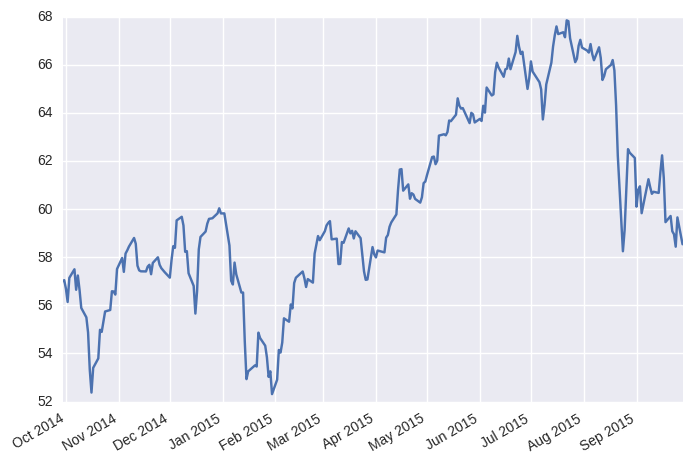

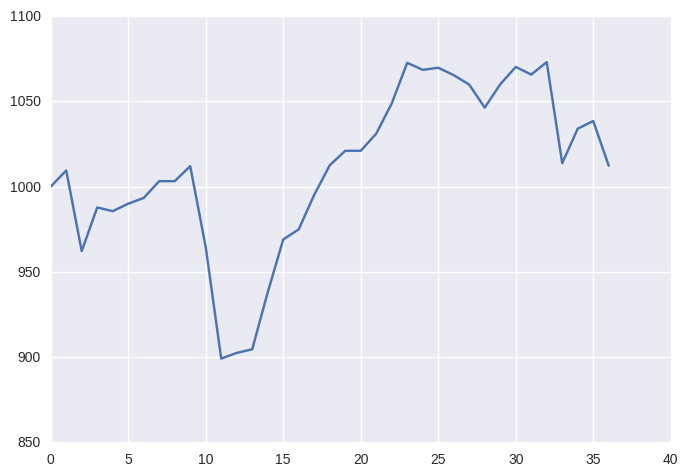

In [385]:
temp_pv_list = [1000]
temp_pv_list.extend(pv_history_list)
pv_history_list = temp_pv_list

validation_phase_data['Trade Price'].plot()
plt.figure()

plt.plot(pv_history_list)

In [57]:
profit = [1000.0, 1000.0, 1000.0, 1011.6160431999999, 1029.5040528, 1029.5040528, 1029.5040528, 1029.5040528, 1029.5040528, 1029.5040528, 1029.5040528, 1025.8880944000002, 1025.8880944000002, 1025.8880944000002, 1029.3281264000002, 1027.8080944000003, 1027.8080944000003, 1030.5281600000005, 1027.5681056000005, 1025.1521344000003, 1024.9281264000003, 1020.5601504000005, 1020.5601504000005, 1020.5601504000005, 1041.7552074000005, 1043.8401594000006, 1041.9202119000006, 1041.9202119000006, 1041.9202119000006, 1041.9202119000006, 1048.7752089000007, 1048.7752089000007, 1048.7752089000007, 1048.7752089000007, 1048.2802419000006, 1048.2802419000006, 1048.2802419000006, 1048.2802419000006, 1049.1803004000008, 1052.6453019000005, 1052.6453019000005, 1052.6453019000005, 1054.9403109000007, 1054.9403109000007, 1054.9403109000007, 1054.8653439000007, 1050.3953829000006, 1050.3953829000006, 1050.3953829000006, 1050.3953829000006, 1050.3953829000006, 1049.7503964000007, 1052.3603829000008, 1042.8503709000006, 1042.8503709000006, 1042.8503709000006, 1042.8503709000006, 1042.8503709000006, 1042.8503709000006, 1042.8503709000006, 1043.5854189000006]

The result turns out to be slightly above the median. 

And when we look at the equivalent annual ROI:

$$
ROI = (1 + r)^{1} = 1.0122
$$

$$
\Longrightarrow r = 0.0122 \approx 1.22\%
$$

we can see the ROI is no way close to that of the patient trader (2.62%).

In [396]:
# September 28, 2015 to September 27, 2016
start_date = datetime(2015, 9, 28)
test_phase_data = data_full.ix[start_date:, :]
display(test_phase_data.head())
display(test_phase_data.tail())
len(test_phase_data)

,-1d_Vol1,-2d_Vol1,-3d_Vol1,-4d_Vol1,-5d_Vol1,10d_Avg_Vol1,21d_Avg_Vol1,63d_Avg_Vol1,-1d_Vol2,-2d_Vol2,-3d_Vol2,-4d_Vol2,-5d_Vol2,-1d_Spread,-2d_Spread,-3d_Spread,-4d_Spread,-5d_Spread,10d_Spread,21d_Spread,63d_Spread,-1d_upperwick,-2d_upperwick,-3d_upperwick,-4d_upperwick,-5d_upperwick,10d_upperwick,21d_upperwick,63d_upperwick,-1d_lowerwick,-2d_lowerwick,-3d_lowerwick,-4d_lowerwick,-5d_lowerwick,10d_lowerwick,21d_lowerwick,63d_lowerwick,Trade Price
2015-09-28,4.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,2.0,2.0,2.0,2.0,2.0,2.0,-1.0,2.0,-1.0,-1.0,-1.0,-2.0,3.0,1.0,3.0,2.0,3.0,1.0,1.0,1.0,3.0,4.0,2.0,2.0,3.0,1.0,1.0,3.0,58.539125
2015-09-29,3.0,4.0,3.0,3.0,3.0,3.0,3.0,3.0,2.0,3.0,2.0,2.0,2.0,-5.0,2.0,2.0,-1.0,2.0,-1.0,-1.0,-2.0,1.0,3.0,1.0,3.0,2.0,1.0,1.0,1.0,2.0,3.0,4.0,2.0,2.0,1.0,1.0,2.0,58.169990
2015-09-30,4.0,3.0,4.0,3.0,2.0,4.0,3.0,3.0,3.0,2.0,3.0,2.0,2.0,-1.0,-5.0,2.0,2.0,-1.0,-1.0,-1.0,-2.0,1.0,1.0,3.0,1.0,3.0,1.0,1.0,1.0,5.0,2.0,3.0,4.0,2.0,1.0,1.0,2.0,59.148202
2015-10-01,4.0,4.0,3.0,4.0,3.0,4.0,3.0,3.0,3.0,3.0,2.0,3.0,2.0,2.0,-1.0,-5.0,2.0,2.0,-1.0,-1.0,-2.0,1.0,1.0,1.0,3.0,2.0,1.0,1.0,1.0,4.0,5.0,2.0,3.0,4.0,1.0,1.0,3.0,59.576590
2015-10-02,3.0,4.0,4.0,3.0,4.0,4.0,3.0,3.0,2.0,3.0,3.0,2.0,3.0,2.0,2.0,-1.0,-5.0,2.0,-1.0,-1.0,-2.0,3.0,1.0,1.0,1.0,3.0,1.0,1.0,1.0,4.0,4.0,5.0,2.0,3.0,1.0,1.0,3.0,59.139584


,-1d_Vol1,-2d_Vol1,-3d_Vol1,-4d_Vol1,-5d_Vol1,10d_Avg_Vol1,21d_Avg_Vol1,63d_Avg_Vol1,-1d_Vol2,-2d_Vol2,-3d_Vol2,-4d_Vol2,-5d_Vol2,-1d_Spread,-2d_Spread,-3d_Spread,-4d_Spread,-5d_Spread,10d_Spread,21d_Spread,63d_Spread,-1d_upperwick,-2d_upperwick,-3d_upperwick,-4d_upperwick,-5d_upperwick,10d_upperwick,21d_upperwick,63d_upperwick,-1d_lowerwick,-2d_lowerwick,-3d_lowerwick,-4d_lowerwick,-5d_lowerwick,10d_lowerwick,21d_lowerwick,63d_lowerwick,Trade Price
2016-09-21,2.0,3.0,5.0,3.0,3.0,3.0,3.0,3.0,1.0,2.0,3.0,2.0,2.0,-3.0,1.0,-2.0,3.0,1.0,-1.0,1.0,2.0,1.0,4.0,2.0,3.0,5.0,1.0,1.0,1.0,2.0,3.0,3.0,2.0,1.0,1.0,1.0,3.0,66.839996
2016-09-22,3.0,2.0,3.0,5.0,3.0,3.0,3.0,3.0,2.0,1.0,2.0,3.0,2.0,1.0,-3.0,1.0,-2.0,3.0,-1.0,1.0,2.0,3.0,1.0,4.0,2.0,3.0,1.0,1.0,1.0,4.0,2.0,3.0,3.0,2.0,1.0,1.0,3.0,67.269999
2016-09-23,3.0,3.0,2.0,3.0,5.0,3.0,3.0,3.0,2.0,2.0,1.0,2.0,3.0,3.0,1.0,-3.0,1.0,-2.0,1.0,1.0,3.0,1.0,3.0,1.0,4.0,2.0,1.0,1.0,1.0,2.0,4.0,2.0,3.0,3.0,1.0,1.0,2.0,67.292000
2016-09-26,3.0,3.0,3.0,2.0,3.0,3.0,3.0,3.0,2.0,2.0,2.0,1.0,2.0,-2.0,3.0,1.0,-3.0,1.0,1.0,1.0,4.0,4.0,1.0,3.0,1.0,4.0,1.0,1.0,1.0,1.0,2.0,4.0,2.0,3.0,1.0,1.0,1.0,66.025999
2016-09-27,4.0,3.0,3.0,3.0,2.0,3.0,3.0,3.0,2.0,2.0,2.0,2.0,1.0,-5.0,-1.0,3.0,1.0,-3.0,-1.0,-1.0,3.0,2.0,4.0,1.0,3.0,1.0,1.0,1.0,1.0,2.0,1.0,2.0,4.0,2.0,1.0,1.0,1.0,66.075002


253

#### Test phase
##### The Patient Trader
###### Start
$Cash_{init} = 1000.00$

$Share_{init} = 0$

$PV_{init} = 0$

$Trading \ Price_{init} = 58.54$

----------------

$Share_{start} = floor(\frac{1000.00}{57.00}) = 17$

$PV_{start} = 58.54 \cdot 17 = 995.18$

$Cash_{start} = Cash_{init} - PV_{start} = 1000.00 - 995.18 = 4.82$

$Total \ Assets_{start} = Cash_{start} + PV_{start} = 4.82 + 995.18 = 1000.00$

##### End
###### Final Condition
$Cash_{end} = 4.82$
$Share_{end} = 17$
$Trading \ Price_{end} = 66.08$

----------------

$PV_{end} = 66.08 \cdot 17 = 1123.36$

$Total \ Assets_{start}  = Cash_{end} + PV_{end} = 4.82 + 1123.36 = 1128.18$

We can calculate the annual ROI by solving the following equation for $r$:
$$
(1 + r)^{253/252} = 1.1282
$$

$$
\Longrightarrow r = 0.1276622 \approx 12.77\%
$$

10000 iterations took 11.0143280029 seconds


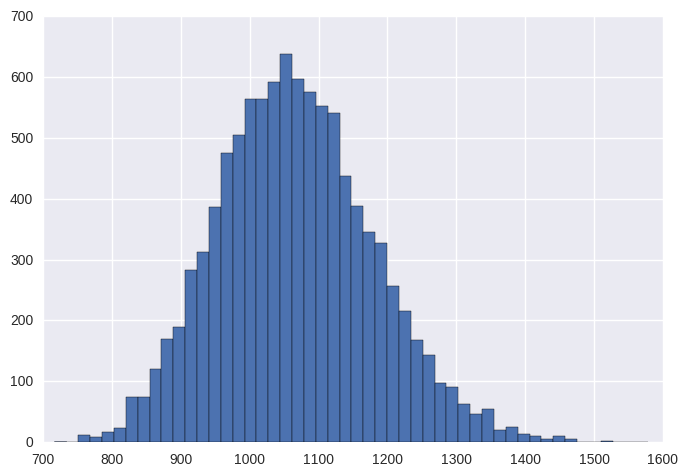

In [397]:
monkey_test = MonkeyBot(test_phase_data)

start_time = time.time()
iters = 10000

monkey_test.simulate(iters)
plt.hist(monkey_test.pv_history_list, bins=50)

print("{0} iterations took {1} seconds".format(iters, time.time() - start_time))

In [400]:
print(pd.Series(monkey_test.pv_history_list).describe())

count    10000.000000
mean      1066.918960
std        113.191153
min        716.778295
25%        987.974898
50%       1061.355945
75%       1139.118993
max       1578.656912
dtype: float64


In [401]:
def main_simulate():
# Initiating data and the chimp
    start_date = test_phase_data.index[0]
    end_date = test_phase_data.index[-1]
    
    global data_full
    dfFull = data_full
    train_size = 21 * 8
    batch_size = 7
    date_range = test_phase_data.index[:] # Using 7 months of data to predict one month
    print(date_range)
    
    batch_count = 0
        
    cash = 1000
    share = 0
    pv = 0
    now_yes_share = 0

    for batch in range(len(test_phase_data) // batch_size):
        
#     for date in date_range:
        batch_count += 1
        print("Batch {}".format(batch_count))

        try:
            dfTest = dfFull.ix[test_phase_data.index[batch * batch_size]:test_phase_data.index[batch * batch_size + batch_size - 1]]
        except IndexError:
            dfTest = dfFull.ix[test_phase_data.index[batch * batch_size]:test_phase_data.index[-1]]
        
        (u,) = dfFull.index.get_indexer_for([test_phase_data.index[batch * batch_size]])

        dfTrain = dfFull.iloc[u - (train_size):u]

        chimp_train = ChimpBot(dfTrain)

        for i in range(1500):
            for l in range(len(chimp_train.env)):
                # print("Train Round {0}-{1}".format(i + 1, l + 1))
                chimp_train.update()
            chimp_train.reset()

        # Test the Chimp!
        q_df = deepcopy(chimp_train.q_df)
        q_dict = deepcopy(chimp_train.q_dict)
        q_reg = deepcopy(chimp_train.q_reg)

        try:
            _ = chimp_test
        except NameError:
            print("First time running...")
        else:
            cash = chimp_test.cash
            share = chimp_test.share
            pv = chimp_test.pv
            now_yes_share = chimp_test.now_yes_share

        chimp_test = ChimpBot(dfTest, cash=cash, share=share, pv=pv, now_yes_share=now_yes_share)

        chimp_test.q_df = deepcopy(q_df)
        chimp_test.q_dict = deepcopy(q_dict)
        chimp_test.q_reg = deepcopy(q_reg)
        chimp_test.epsilon = 0

        # Pass the cheatsheet to the next chimp
        try:
            chimp_test.prev_states = prev_states
            chimp_test.now_action = now_action
            chimp_test.prev_action = prev_action
            chimp_test.prev_yes_share = prev_yes_share
            chimp_test.reward = reward
            chimp_test.prev_cash = prev_cash
            chimp_test.prev_share = prev_share
            chimp_test.prev_pv = prev_pv
            chimp_test.prev_env_index = prev_env_index

        except UnboundLocalError:
            print("No cheatsheet to pass over yet...no worries!")

        for l in range(len(chimp_test.env)):
            # print("Train Round {0}-{1}".format(i + 1, l + 1))
            chimp_test.update()
                
        # Create cheatsheet for the next chimp
        prev_states = chimp_test.prev_states
        now_action = chimp_test.now_action
        prev_action = chimp_test.prev_action
        prev_yes_share = chimp_test.prev_yes_share
        prev_env_index = chimp_test.prev_env_index
        reward = chimp_test.reward
        prev_cash = chimp_test.prev_cash
        prev_share = chimp_test.prev_share
        prev_pv = chimp_test.prev_pv

        global action_lists
        action_lists.append(chimp_test.action_list)
        
        global pv_history_list
        pv_history_list.append(chimp_test.cash + chimp_test.pv)
        
        if (batch + 1) % 3 == 0:
            print(pv_history_list)
        
    print(pv_history_list)

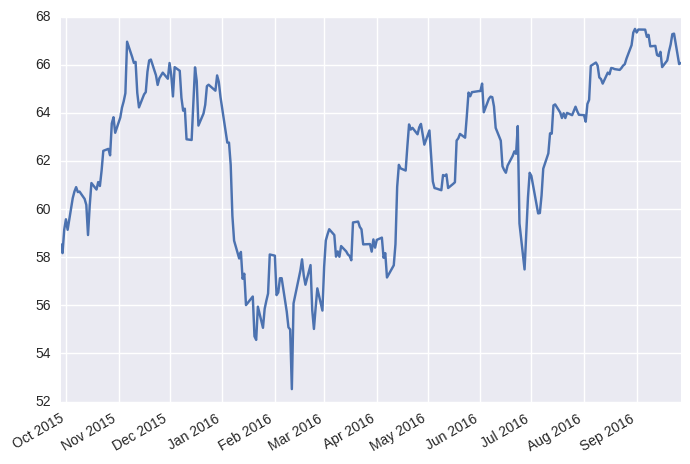

In [403]:
test_phase_data['Trade Price'].plot()

In [404]:
main_simulate()

DatetimeIndex(['2015-09-28', '2015-09-29', '2015-09-30', '2015-10-01',
               '2015-10-02', '2015-10-05', '2015-10-06', '2015-10-07',
               '2015-10-08', '2015-10-09',
               ...
               '2016-09-14', '2016-09-15', '2016-09-16', '2016-09-19',
               '2016-09-20', '2016-09-21', '2016-09-22', '2016-09-23',
               '2016-09-26', '2016-09-27'],
              dtype='datetime64[ns]', length=253, freq=None)
Batch 1
Running the first time...no prevs exist.
No reward yet...0 assigned.
Updating Q model...
First time running...
No cheatsheet to pass over yet...no worries!
Running the first time...no prevs exist.
No reward yet...0 assigned.
Batch 2
Running the first time...no prevs exist.
No reward yet...0 assigned.
Updating Q model...
Batch 3
Running the first time...no prevs exist.
No reward yet...0 assigned.
Updating Q model...
[1000, 1009.3874410244001, 962.10700506190017, 987.71673413190035, 985.54667920700024, 989.92101388860033, 993.32176390480

### Refinement
#### Why is it not working?
Surely we wouldn't expect the chimp to give us a 500% of ROI on the test dataset, which is just not realistic. However, if frequently placing orders actually generates less profit than the patient trader, there is indeed no point of doing so, not to mention we haven't taken into account the trading cost. On the other hand, beating the monkey only marginally is not much of a success either. So why is it not working?

Below are some of the reasons we can think of right away:

1. **Features not representative—**we basically hand-picked our features in the hope that they could capture the patterns of the stock market. Our selection was based on volume price analysis but it may very well not be a good representation of what VPA pracitioners are really doing.

2. **Low fault tolerance in the design of decisioning—**for the moment we only allow our chimp to buy or sell with no compartments. This means each time she makes a mistake, it's a big mistake. And we don't really know how disasterous that can be which depends solely on the non-linearity of our utility function.

3. **Discretization not ideal—**since the feature space is vast, one way or the other we are only going to cover a fraction of the space. As such, discretizing it really won't give us any benefits. In doing so we're actually losing a lot of information.

For 1., one way to do this is to include more raw features (for example, for each observation we get the candlesticks down to the minute, and for the entire past year) and use unsupervised learning such as PCA or an autoencoder to narrow it down and get the real representative features.

For 2., for the moment our chimp (and monkey) can only buy and sell with all that they have. We can add a few more actions, like buy/sell half, and hold.

For 3., we can simply drop discretization all together.

However, before we proceed, let's first do a quick analysis on what's really happening here.

In [386]:
data_train = data_full.iloc[7898 - 21 * 8:7898, :]
data_test = data_full.ix[u:u+7, :]

X_train = data_train.ix[:, :-1]
y_train = data_train.ix[:, -1]
X_test = data_test.ix[:, :-1]
y_test = data_test.ix[:, -1]

display(data_train.head())
display(data_test.head())

,-1d_Vol1,-2d_Vol1,-3d_Vol1,-4d_Vol1,-5d_Vol1,10d_Avg_Vol1,21d_Avg_Vol1,63d_Avg_Vol1,-1d_Vol2,-2d_Vol2,-3d_Vol2,-4d_Vol2,-5d_Vol2,-1d_Spread,-2d_Spread,-3d_Spread,-4d_Spread,-5d_Spread,10d_Spread,21d_Spread,63d_Spread,-1d_upperwick,-2d_upperwick,-3d_upperwick,-4d_upperwick,-5d_upperwick,10d_upperwick,21d_upperwick,63d_upperwick,-1d_lowerwick,-2d_lowerwick,-3d_lowerwick,-4d_lowerwick,-5d_lowerwick,10d_lowerwick,21d_lowerwick,63d_lowerwick,Trade Price
2015-01-21,4.0,5.0,5.0,5.0,4.0,5.0,4.0,3.0,2.0,3.0,4.0,5.0,2.0,-2.0,5.0,-5.0,-1.0,-3.0,-3.0,-2.0,-1.0,2.0,1.0,5.0,1.0,3.0,1.0,2.0,4.0,2.0,1.0,3.0,5.0,3.0,1.0,1.0,1.0,53.456866
2015-01-22,4.0,4.0,5.0,5.0,5.0,5.0,4.0,3.0,2.0,2.0,3.0,4.0,5.0,3.0,-2.0,5.0,-5.0,-1.0,-2.0,-3.0,-1.0,3.0,2.0,1.0,5.0,1.0,1.0,1.0,3.0,2.0,2.0,1.0,3.0,5.0,1.0,1.0,1.0,54.865241
2015-01-23,5.0,4.0,4.0,5.0,5.0,5.0,4.0,3.0,3.0,2.0,2.0,3.0,4.0,5.0,3.0,-2.0,5.0,-4.0,-2.0,-2.0,-1.0,1.0,3.0,2.0,1.0,5.0,1.0,1.0,3.0,3.0,2.0,2.0,1.0,3.0,2.0,2.0,2.0,54.639940
2015-01-26,3.0,5.0,4.0,4.0,5.0,5.0,4.0,3.0,2.0,3.0,2.0,2.0,3.0,-5.0,5.0,3.0,-2.0,5.0,-2.0,-3.0,-1.0,1.0,1.0,3.0,2.0,1.0,1.0,1.0,3.0,1.0,3.0,2.0,2.0,1.0,1.0,1.0,1.0,54.323559
2015-01-27,3.0,3.0,5.0,4.0,4.0,5.0,4.0,3.0,2.0,2.0,3.0,2.0,2.0,2.0,-5.0,5.0,3.0,-2.0,-2.0,-3.0,-1.0,2.0,1.0,1.0,3.0,2.0,1.0,1.0,3.0,2.0,1.0,3.0,2.0,2.0,1.0,1.0,1.0,53.837483


,-1d_Vol1,-2d_Vol1,-3d_Vol1,-4d_Vol1,-5d_Vol1,10d_Avg_Vol1,21d_Avg_Vol1,63d_Avg_Vol1,-1d_Vol2,-2d_Vol2,-3d_Vol2,-4d_Vol2,-5d_Vol2,-1d_Spread,-2d_Spread,-3d_Spread,-4d_Spread,-5d_Spread,10d_Spread,21d_Spread,63d_Spread,-1d_upperwick,-2d_upperwick,-3d_upperwick,-4d_upperwick,-5d_upperwick,10d_upperwick,21d_upperwick,63d_upperwick,-1d_lowerwick,-2d_lowerwick,-3d_lowerwick,-4d_lowerwick,-5d_lowerwick,10d_lowerwick,21d_lowerwick,63d_lowerwick,Trade Price
2014-09-29,3.0,4.0,3.0,3.0,3.0,3.0,3.0,3.0,2.0,2.0,2.0,2.0,2.0,2.0,-5.0,4.0,2.0,-1.0,1.0,1.0,2.0,3.0,1.0,1.0,4.0,5.0,1.0,1.0,1.0,1.0,0.0,2.0,1.0,1.0,1.0,1.0,1.0,57.000706
2014-09-30,3.0,3.0,4.0,3.0,3.0,3.0,3.0,3.0,2.0,2.0,2.0,2.0,2.0,3.0,2.0,-5.0,4.0,2.0,1.0,1.0,2.0,2.0,3.0,1.0,1.0,4.0,1.0,1.0,1.0,3.0,1.0,0.0,2.0,1.0,1.0,1.0,1.0,57.046125
2014-10-01,3.0,3.0,3.0,4.0,3.0,4.0,3.0,3.0,2.0,2.0,2.0,2.0,2.0,-2.0,3.0,2.0,-5.0,4.0,1.0,1.0,2.0,3.0,2.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,3.0,1.0,0.0,2.0,1.0,1.0,1.0,56.689397
2014-10-02,4.0,3.0,3.0,3.0,4.0,4.0,3.0,3.0,3.0,2.0,2.0,2.0,2.0,-4.0,-2.0,3.0,2.0,-5.0,-1.0,-1.0,2.0,2.0,3.0,2.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,3.0,1.0,0.0,1.0,1.0,1.0,56.139693
2014-10-03,5.0,4.0,3.0,3.0,3.0,4.0,3.0,3.0,3.0,3.0,2.0,2.0,2.0,-3.0,-4.0,-2.0,3.0,2.0,-2.0,-1.0,2.0,3.0,2.0,3.0,2.0,3.0,1.0,1.0,2.0,2.0,1.0,1.0,3.0,1.0,1.0,1.0,1.0,57.141829


In [387]:
from sklearn import cross_validation
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

def performance_metric(y_true, y_predict):
    """ Calculates and returns the total error between true and predicted values
        based on a performance metric chosen by the student. """

    error = mean_squared_error(y_true, y_predict)
    return error

def fit_model(X, y):
    """ Tunes a decision tree regressor model using GridSearchCV on the input data X 
        and target labels y and returns this optimal model. """

    # Create a decision tree regressor object
    regressor = DecisionTreeRegressor()

    # Set up the parameters we wish to tune
    parameters = {'max_depth':(1,2,3,4,5,6,7,8,9,10)}

    # Make an appropriate scoring function
    scoring_function = make_scorer(performance_metric, greater_is_better=False)

    # Make the GridSearchCV object
    reg = GridSearchCV(regressor, parameters, scoring = scoring_function)

    # Fit the learner to the data to obtain the optimal model with tuned parameters
    reg.fit(X, y)

    # Return the optimal model
    return reg.best_estimator_

def learning_curves(X_train, y_train, X_test, y_test):
    """ Calculates the performance of several models with varying sizes of training data.
        The learning and testing error rates for each model are then plotted. """
    
    print "Creating learning curve graphs for max_depths of 1, 3, 5, 7. . ."
    
    # Create the figure window
    fig = plt.figure(figsize=(10,8))

    # We will vary the training set size so that we have 50 different sizes
    sizes = np.rint(np.linspace(1, len(X_train), 50)).astype(int)
    train_err = np.zeros(len(sizes))
    test_err = np.zeros(len(sizes))

    # Create four different models based on max_depth
    for k, depth in enumerate([1,3,5,7]):
        
        for i, s in enumerate(sizes):
            
            # Setup a decision tree regressor so that it learns a tree with max_depth = depth
            regressor = DecisionTreeRegressor(max_depth = depth)
            
            # Fit the learner to the training data
            regressor.fit(X_train[:s], y_train[:s])

            # Find the performance on the training set
            train_err[i] = performance_metric(y_train[:s], regressor.predict(X_train[:s]))
            
            # Find the performance on the testing set
            test_err[i] = performance_metric(y_test, regressor.predict(X_test))

        # Subplot the learning curve graph
        ax = fig.add_subplot(2, 2, k+1)
        ax.plot(sizes, test_err, lw = 2, label = 'Testing Error')
        ax.plot(sizes, train_err, lw = 2, label = 'Training Error')
        ax.legend()
        ax.set_title('max_depth = %s'%(depth))
        ax.set_xlabel('Number of Data Points in Training Set')
        ax.set_ylabel('Total Error')
        ax.set_xlim([0, len(X_train)])
    
    # Visual aesthetics
    fig.suptitle('Decision Tree Regressor Learning Performances', fontsize=18, y=1.03)
    fig.tight_layout()
    fig.show()
    
def model_complexity(X_train, y_train, X_test, y_test):
    """ Calculates the performance of the model as model complexity increases.
        The learning and testing errors rates are then plotted. """
    
    print "Creating a model complexity graph. . . "

    # We will vary the max_depth of a decision tree model from 1 to 14
    max_depth = np.arange(1, 14)
    train_err = np.zeros(len(max_depth))
    test_err = np.zeros(len(max_depth))

    for i, d in enumerate(max_depth):
        # Setup a Decision Tree Regressor so that it learns a tree with depth d
        regressor = DecisionTreeRegressor(max_depth = d)

        # Fit the learner to the training data
        regressor.fit(X_train, y_train)

        # Find the performance on the training set
        train_err[i] = performance_metric(y_train, regressor.predict(X_train))

        # Find the performance on the testing set
        test_err[i] = performance_metric(y_test, regressor.predict(X_test))

    # Plot the model complexity graph
    plt.figure(figsize=(7, 5))
    plt.title('Decision Tree Regressor Complexity Performance')
    plt.plot(max_depth, test_err, lw=2, label = 'Testing Error')
    plt.plot(max_depth, train_err, lw=2, label = 'Training Error')
    plt.legend()
    plt.xlabel('Maximum Depth')
    plt.ylabel('Total Error')
    plt.show()

Creating learning curve graphs for max_depths of 1, 3, 5, 7. . .


/home/calvinjku/anaconda2/envs/python2/lib/python2.7/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


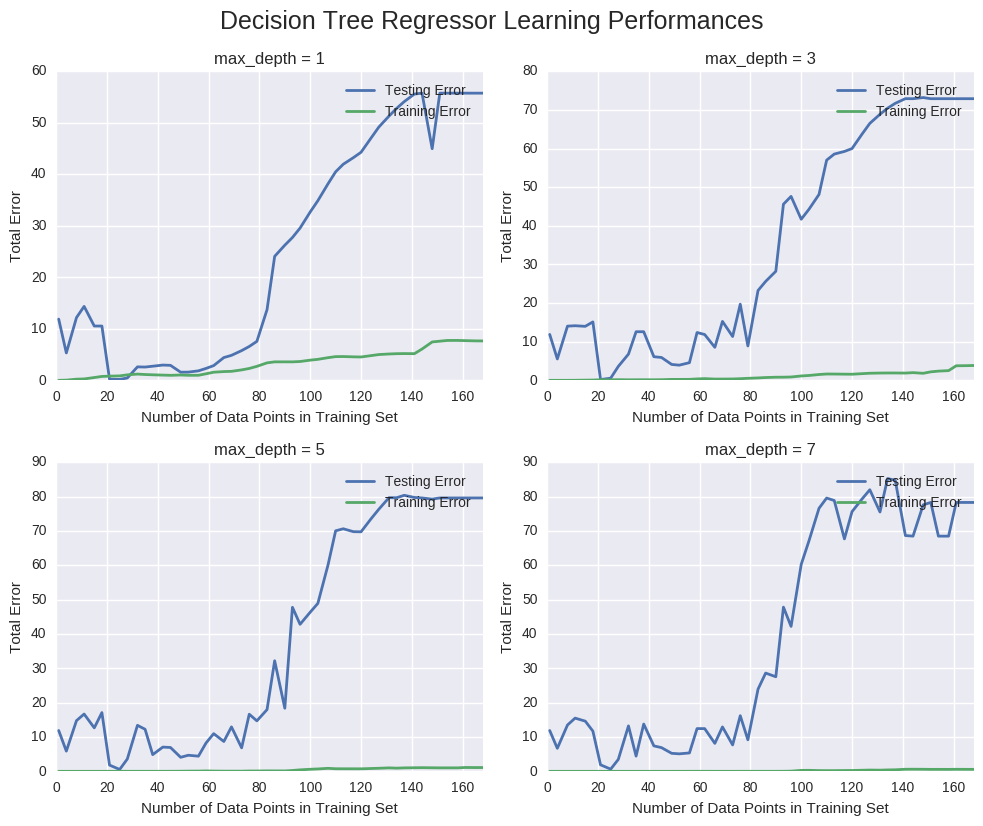

In [388]:
learning_curves(X_train, y_train, X_test, y_test)

In [392]:
reg = RandomForestRegressor(n_estimators=1500, max_features='sqrt', oob_score=True, n_jobs=-1, random_state=0)
reg.fit(X_train, y_train)

y_pred = reg.predict(X_test)

r2 = r2_score(list(y_test), y_pred)
print(1 - reg.oob_score_)
print(r2)

0.170105269034
-286.045538397


We can see that our model doesn't have anything predicting power whatsoever (worse than guessing the mean, that is). On the other hand, a simple decision tree with depth of 40 can model the training data pretty well. This indicates that the model complexity is clearly not the problem. A reasonable explantion would be that the problem lies in the represention of the data, the feature engineering.

In [2]:
dfMain2 = pd.DataFrame(index=dates)
# dfMain = dfMain.join(dfSPY)
dfMain2 = dfMain2.join(dfJPM)
dfMain2.dropna(inplace=True)

print("Inspect missing values:")
display(dfMain2.isnull().sum())
print(len(dfMain2))

Inspect missing values:


Open         0
High         0
Low          0
Close        0
Volume       0
Adj Close    0
dtype: int64

8256


In [3]:
# Adjust Open, High, Low, Volume
dfMain2['Adj Factor'] = dfMain2['Adj Close'] / dfMain2['Close']

dfMain2['Open'] = dfMain2['Open'] * dfMain2['Adj Factor']
dfMain2['High'] = dfMain2['High'] * dfMain2['Adj Factor']
dfMain2['Low'] = dfMain2['Low'] * dfMain2['Adj Factor']

dfMain2['Volume'] = dfMain2['Volume'] / dfMain2['Adj Factor']
dfMain2.drop(['Adj Factor'], axis=1, inplace=True)

In [4]:
feature_days = 21 * 6

# Price Engineering
for i in range(feature_days):
    # Get opens
    dfMain2['-' + str(i + 1) + 'd_Open'] = dfMain2['Open'].shift(i + 1)
    # Get adjCloses
    dfMain2['-' + str(i + 1) + 'd_adjClose'] = dfMain2['Adj Close'].shift(i + 1)
    # Get Highs
    dfMain2['-' + str(i + 1) + 'd_High'] = dfMain2['High'].shift(i + 1)
    # Get Lows
    dfMain2['-' + str(i + 1) + 'd_Low'] = dfMain2['Low'].shift(i + 1)

# TODO: remove -xd_Open, -xd_adjClose, -xd_High, -xd_Low, x = range(1, feature_days + 1)
    
period_list = [21*x for x in range(1, 13)] # Create relative bases
period_list.extend([5, 10]) # Add 1, 2 week comparison basese
print(period_list)

for x in period_list:
    # Get Max volumes
    dfMain2[str(x) + 'd_Max_Vol'] = dfMain2['Volume'].shift().rolling(window=x).max()
    # Get Avg volumes
    dfMain2[str(x) + 'd_Avg_Vol'] = dfMain2['Volume'].shift().rolling(window=x).mean()
    # Get Min volumes
    dfMain2[str(x) + 'd_Min_Vol'] = dfMain2['Volume'].shift().rolling(window=x).min()

# TODO: remove xd_Max_Vol, xd_Avg_Vol, xd_Min_Vol, for x in period_list

dfMain2['Abs_Spread'] = np.abs(dfMain2['Adj Close'] - dfMain2['Open'])
dfMain2['Abs_Spread_Shift1'] = dfMain2['Abs_Spread'].shift()

for x in period_list:
    # Get Max spreads
    dfMain2[str(x) + 'd_Max_Spread'] = dfMain2['Abs_Spread_Shift1'].rolling(window=x).max()
    # Get Avg spreads
    dfMain2[str(x) + 'd_Avg_Spread'] = dfMain2['Abs_Spread_Shift1'].rolling(window=x).mean()

# TODO: remove xd_Max_Spread, xd_Avg_Spread, for x in period_list

dfMain2.drop(['Abs_Spread_Shift1', 'Abs_Spread'], axis=1, inplace=True)

display(dfMain2.head())

[21, 42, 63, 84, 105, 126, 147, 168, 189, 210, 231, 252, 5, 10]


,Open,High,Low,Close,Volume,Adj Close,-1d_Open,-1d_adjClose,-1d_High,-1d_Low,-2d_Open,-2d_adjClose,-2d_High,-2d_Low,-3d_Open,-3d_adjClose,-3d_High,-3d_Low,-4d_Open,-4d_adjClose,-4d_High,-4d_Low,-5d_Open,-5d_adjClose,-5d_High,...,42d_Avg_Spread,63d_Max_Spread,63d_Avg_Spread,84d_Max_Spread,84d_Avg_Spread,105d_Max_Spread,105d_Avg_Spread,126d_Max_Spread,126d_Avg_Spread,147d_Max_Spread,147d_Avg_Spread,168d_Max_Spread,168d_Avg_Spread,189d_Max_Spread,189d_Avg_Spread,210d_Max_Spread,210d_Avg_Spread,231d_Max_Spread,231d_Avg_Spread,252d_Max_Spread,252d_Avg_Spread,5d_Max_Spread,5d_Avg_Spread,10d_Max_Spread,10d_Avg_Spread
1983-12-30,2.602623,2.632198,2.573048,44.000008,3.575624e+06,2.602623,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1984-01-03,2.598926,2.617409,2.580440,44.000008,6.517272e+06,2.602623,2.602623,2.602623,2.632198,2.573048,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1984-01-04,2.652532,2.713529,2.617410,45.874979,4.945011e+06,2.713529,2.598926,2.602623,2.617409,2.580440,2.602623,2.602623,2.632198,2.573048,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1984-01-05,2.768984,2.802256,2.735712,47.375008,5.817363e+06,2.802256,2.652532,2.713529,2.713529,2.617410,2.598926,2.602623,2.617409,2.580440,2.602623,2.602623,2.632198,2.573048,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1984-01-06,2.772681,2.802256,2.743106,46.875014,3.286531e+06,2.772681,2.768984,2.802256,2.802256,2.735712,2.652532,2.713529,2.713529,2.617410,2.598926,2.602623,2.617409,2.580440,2.602623,2.602623,2.632198,2.573048,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
display(dfMain2.head(100))

,Open,High,Low,Close,Volume,Adj Close,-1d_Open,-1d_adjClose,-1d_High,-1d_Low,-2d_Open,-2d_adjClose,-2d_High,-2d_Low,-3d_Open,-3d_adjClose,-3d_High,-3d_Low,-4d_Open,-4d_adjClose,-4d_High,-4d_Low,-5d_Open,-5d_adjClose,-5d_High,...,42d_Avg_Spread,63d_Max_Spread,63d_Avg_Spread,84d_Max_Spread,84d_Avg_Spread,105d_Max_Spread,105d_Avg_Spread,126d_Max_Spread,126d_Avg_Spread,147d_Max_Spread,147d_Avg_Spread,168d_Max_Spread,168d_Avg_Spread,189d_Max_Spread,189d_Avg_Spread,210d_Max_Spread,210d_Avg_Spread,231d_Max_Spread,231d_Avg_Spread,252d_Max_Spread,252d_Avg_Spread,5d_Max_Spread,5d_Avg_Spread,10d_Max_Spread,10d_Avg_Spread
1983-12-30,2.602623,2.632198,2.573048,44.000008,3.575624e+06,2.602623,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1984-01-03,2.598926,2.617409,2.580440,44.000008,6.517272e+06,2.602623,2.602623,2.602623,2.632198,2.573048,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1984-01-04,2.652532,2.713529,2.617410,45.874979,4.945011e+06,2.713529,2.598926,2.602623,2.617409,2.580440,2.602623,2.602623,2.632198,2.573048,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1984-01-05,2.768984,2.802256,2.735712,47.375008,5.817363e+06,2.802256,2.652532,2.713529,2.713529,2.617410,2.598926,2.602623,2.617409,2.580440,2.602623,2.602623,2.632198,2.573048,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1984-01-06,2.772681,2.802256,2.743106,46.875014,3.286531e+06,2.772681,2.768984,2.802256,2.802256,2.735712,2.652532,2.713529,2.713529,2.617410,2.598926,2.602623,2.617409,2.580440,2.602623,2.602623,2.632198,2.573048,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1984-01-09,2.780073,2.802256,2.757892,46.999979,3.656773e+06,2.780073,2.772681,2.772681,2.802256,2.743106,2.768984,2.802256,2.802256,2.735712,2.652532,2.713529,2.713529,2.617410,2.598926,2.602623,2.617409,2.580440,2.602623,2.602623,2.632198,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.060997,0.019593,NaN,NaN
1984-01-10,2.820739,2.854012,2.787467,47.875006,2.419252e+06,2.831831,2.780073,2.780073,2.802256,2.757892,2.772681,2.772681,2.802256,2.743106,2.768984,2.802256,2.802256,2.735712,2.652532,2.713529,2.713529,2.617410,2.598926,2.602623,2.617409,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.060997,0.019593,NaN,NaN
1984-01-11,2.831831,2.898376,2.802256,48.874994,6.725216e+06,2.890981,2.820739,2.831831,2.854012,2.787467,2.780073,2.780073,2.802256,2.757892,2.772681,2.772681,2.802256,2.743106,2.768984,2.802256,2.802256,2.735712,2.652532,2.713529,2.713529,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.060997,0.021072,NaN,NaN
1984-01-12,2.890981,2.935345,2.876195,49.374992,5.036305e+06,2.920556,2.831831,2.890981,2.898376,2.802256,2.820739,2.831831,2.854012,2.787467,2.780073,2.780073,2.802256,2.757892,2.772681,2.772681,2.802256,2.743106,2.768984,2.802256,2.802256,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.059150,0.020703,NaN,NaN
1984-01-13,2.950131,2.972314,2.927951,49.625008,9.996531e+06,2.935345,2.890981,2.920556,2.935345,2.876195,2.831831,2.890981,2.898376,2.802256,2.820739,2.831831,2.854012,2.787467,2.780073,2.780073,2.802256,2.757892,2.772681,2.772681,2.802256,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.059150,0.019963,NaN,NaN


In [6]:
# Volume Engineering
start_time = time.time()
for i in range(feature_days):
    # Get volumes
    dfMain2['-' + str(i + 1) + 'd_Vol'] = dfMain2['Volume'].shift(i + 1)
    # Get relative volumes
    for x in period_list:
        dfMain2['-' + str(i + 1) + 'd_Vol_' + str(x) + 'Max'] = dfMain2['-' + str(i + 1) + 'd_Vol'] / dfMain2[str(x) + 'd_Max_Vol']
        dfMain2['-' + str(i + 1) + 'd_Vol_' + str(x) + 'Avg'] = dfMain2['-' + str(i + 1) + 'd_Vol'] / dfMain2[str(x) + 'd_Avg_Vol']
        dfMain2['-' + str(i + 1) + 'd_Vol_' + str(x) + 'Min'] = dfMain2['-' + str(i + 1) + 'd_Vol'] / dfMain2[str(x) + 'd_Min_Vol']
        
print("Generating volume features took {} seconds.".format(time.time() - start_time))

Generating volume features took 21.0819978714 seconds.


In [7]:
# Spread Engineering
start_time = time.time()
for i in range(feature_days):
    # Get spread
    dfMain2['-' + str(i + 1) + 'd_Spread'] = dfMain2['-' + str(i + 1) + 'd_adjClose'] - dfMain2['-' + str(i + 1) + 'd_Open']
    # Get relative spread
    for x in period_list:
        dfMain2['-' + str(i + 1) + 'd_Spread_' + str(x) + 'Max'] = dfMain2['-' + str(i + 1) + 'd_Spread'] / dfMain2[str(x) + 'd_Max_Spread']
        dfMain2['-' + str(i + 1) + 'd_Spread_' + str(x) + 'Vol'] = dfMain2['-' + str(i + 1) + 'd_Spread'] / dfMain2[str(x) + 'd_Avg_Spread']
#         dfMain2['-' + str(i + 1) + 'd_Spread_' + str(x) + 'Min'] = dfMain2['-' + str(i + 1) + 'd_Spread'] / dfMain2[str(x) + 'd_Min_Spread']

print("Generating spread features took {} seconds.".format(time.time() - start_time))

Generating spread features took 35.4069550037 seconds.


In [8]:
# Level Engineering
start_time = time.time()
for x in period_list:
    # Get Max adjClose
    dfMain2[str(x) + 'd_Max_Price'] = dfMain2['Adj Close'].shift().rolling(window=x).max()
    # Get Avg adjClose
    dfMain2[str(x) + 'd_Avg_Price'] = dfMain2['Adj Close'].shift().rolling(window=x).mean()
    # Get Min adjClose
    dfMain2[str(x) + 'd_Min_Price'] = dfMain2['Adj Close'].shift().rolling(window=x).min()
    # Get Std adjClose
    dfMain2[str(x) + 'd_Std_Price'] = dfMain2['Adj Close'].shift().rolling(window=x).std()

# TODO: remove xd_Max_Price, xd_Avg_Price, xd_Min_Price. Retain xd_Std_Price for x in period_list

for i in range(feature_days):
    # Get relative price
    for x in period_list:
        dfMain2['-' + str(i + 1) + 'd_Price_' + str(x) + 'Max'] = dfMain2['-' + str(i + 1) + 'd_adjClose'] / dfMain2[str(x) + 'd_Max_Price']
        dfMain2['-' + str(i + 1) + 'd_Price_' + str(x) + 'Vol'] = dfMain2['-' + str(i + 1) + 'd_adjClose'] / dfMain2[str(x) + 'd_Avg_Price']
        dfMain2['-' + str(i + 1) + 'd_Price_' + str(x) + 'Min'] = dfMain2['-' + str(i + 1) + 'd_adjClose'] / dfMain2[str(x) + 'd_Min_Price']
        
print("Generating level features took {} seconds.".format(time.time() - start_time))

Generating level features took 79.8384079933 seconds.


In [9]:
def upperwick(open, adj_close, high):
    if high > open and high > adj_close:
        return True
    else:
        return False
def lowerwick(open, adj_close, low):
    if low < open and low < adj_close:
        return True
    else:
        return False
    
# Get wicks - new code has 10X speed!
start_time = time.time()

for i in range(feature_days):
    dfMain2.ix[:, '-' + str(i + 1) + 'd_upperwick_bool'] = dfMain2.apply(lambda row: upperwick(row['-' + str(i + 1) + 'd_Open'], row['-' + str(i + 1) + 'd_adjClose'], row['-' + str(i + 1) + 'd_High']), axis=1)
    dfMain2.ix[:, '-' + str(i + 1) + 'd_lowerwick_bool'] = dfMain2.apply(lambda row: lowerwick(row['-' + str(i + 1) + 'd_Open'], row['-' + str(i + 1) + 'd_adjClose'], row['-' + str(i + 1) + 'd_Low']), axis=1)        

# TODO: remove -xd_upperwick_bool, -xd_lowerwick_bool, x in range(1, feature_days + 1)
print("Getting wicks took {} seconds.".format(time.time() - start_time))

Getting wicks took 10952.6491389 seconds.


In [10]:
# MBP Time: Getting wicks took 10592.5030599 seconds.

In [11]:
def get_upperwick_length(open, adj_close, high):
    return high - max(open, adj_close)

def get_lowerwick_length(open, adj_close, low):
    return min(open, adj_close) - low
    
    
start_time = time.time()

# Transform upper wicks
for i in range(feature_days):
    has_upperwicks = dfMain2['-' + str(i + 1) + 'd_upperwick_bool']
    has_lowerwicks = dfMain2['-' + str(i + 1) + 'd_lowerwick_bool']
    
    dfMain2.loc[has_upperwicks, '-' + str(i + 1) + 'd_upperwick'] = dfMain2.loc[has_upperwicks, :].apply(lambda row: get_upperwick_length(row['-' + str(i + 1) + 'd_Open'], row['-' + str(i + 1) + 'd_adjClose'], row['-' + str(i + 1) + 'd_High']), axis=1)
    dfMain2.loc[has_lowerwicks, '-' + str(i + 1) + 'd_lowerwick'] = dfMain2.loc[has_lowerwicks, :].apply(lambda row: get_lowerwick_length(row['-' + str(i + 1) + 'd_Open'], row['-' + str(i + 1) + 'd_adjClose'], row['-' + str(i + 1) + 'd_Low']), axis=1)
    
    # Get relative upperwick length
    dfMain2.loc[dfMain2['-' + str(i + 1) + 'd_upperwick_bool'], '-' + str(i + 1) + 'd_upperwick'] = dfMain2.loc[dfMain2['-' + str(i + 1) + 'd_upperwick_bool'], '-' + str(i + 1) + 'd_upperwick'] / dfMain2.loc[dfMain2['-' + str(i + 1) + 'd_upperwick_bool'], '126d_Avg_Spread']
    # Get relative lowerwick length
    dfMain2.loc[dfMain2['-' + str(i + 1) + 'd_lowerwick_bool'], '-' + str(i + 1) + 'd_lowerwick'] = dfMain2.loc[dfMain2['-' + str(i + 1) + 'd_lowerwick_bool'], '-' + str(i + 1) + 'd_lowerwick'] / dfMain2.loc[dfMain2['-' + str(i + 1) + 'd_lowerwick_bool'], '126d_Avg_Spread']

    # Assign 0 to no-upperwick days
    dfMain2.loc[np.logical_not(dfMain2['-' + str(i + 1) + 'd_upperwick_bool']), '-' + str(i + 1) + 'd_upperwick'] = 0
    # Assign 0 to no-lowerwick days
    dfMain2.loc[np.logical_not(dfMain2['-' + str(i + 1) + 'd_lowerwick_bool']), '-' + str(i + 1) + 'd_lowerwick'] = 0

print("Transforming wicks took {} seconds.".format(time.time() - start_time))

Transforming wicks took 8951.81476498 seconds.


In [12]:
dfMain2['Trade Price'] = dfMain2['Open'] * 0.3 + dfMain2['Adj Close'] * 0.7
print(dfMain2[['Trade Price', 'Open', 'Adj Close']].head())

            Trade Price      Open  Adj Close
1983-12-30     2.602623  2.602623   2.602623
1984-01-03     2.601514  2.598926   2.602623
1984-01-04     2.695230  2.652532   2.713529
1984-01-05     2.792274  2.768984   2.802256
1984-01-06     2.772681  2.772681   2.772681


In [13]:
print(dfMain2.columns)

Index([u'Open', u'High', u'Low', u'Close', u'Volume', u'Adj Close',
       u'-1d_Open', u'-1d_adjClose', u'-1d_High', u'-1d_Low',
       ...
       u'-122d_lowerwick', u'-123d_upperwick', u'-123d_lowerwick',
       u'-124d_upperwick', u'-124d_lowerwick', u'-125d_upperwick',
       u'-125d_lowerwick', u'-126d_upperwick', u'-126d_lowerwick',
       u'Trade Price'],
      dtype='object', length=15505)


In [14]:
# Remove raw features
raw_features = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']

# Remove vol comparison base
vol_compare_type = ['Max', 'Avg', 'Min']
vol_compare_features = []

# Remove vol meta features
vol_meta = []
for d in range(1, feature_days + 1):
    vol_meta.append('-' + str(d) + 'd_Vol')

# Remove spread comparison base
sprd_compare_type = ['Max', 'Avg']
sprd_compare_features = []

for d in period_list:
    for t in vol_compare_type:
        vol_compare_features.append(str(d) + 'd_' + t + '_Vol')
    for u in sprd_compare_type:
        sprd_compare_features.append(str(d) + 'd_' + u + '_Spread')

# Remove spread meta features
price_raw = ['Open', 'adjClose', 'High', 'Low']
spread_meta = []

for d in range(1, feature_days + 1):
    for t in price_raw:
        spread_meta.append('-' + str(d) + 'd_' + t)

# Remove price comparison base
price_compare_type = vol_compare_type
price_compare_features = []

for d in period_list:
    for t in price_compare_type:
        price_compare_features.append(str(d) + 'd_' + t + '_Price')

# Remove wick bools
wick_type = ['upperwick', 'lowerwick']
wick_bools = []

for d in range(1, feature_days + 1):
    for t in wick_type:
        wick_bools.append('-' + str(d) + 'd_' + t + '_bool')

drop_list = []
drop_list = drop_list + raw_features + vol_compare_features + vol_meta + sprd_compare_features + spread_meta + price_compare_features + wick_bools

dfMain2.drop(drop_list, axis=1, inplace=True)

In [16]:
from copy import deepcopy

dataset_full = deepcopy(dfMain2)
dataset_full.dropna(inplace=True)

In [17]:
display(dataset_full.head())

,-1d_Vol_21Max,-1d_Vol_21Avg,-1d_Vol_21Min,-1d_Vol_42Max,-1d_Vol_42Avg,-1d_Vol_42Min,-1d_Vol_63Max,-1d_Vol_63Avg,-1d_Vol_63Min,-1d_Vol_84Max,-1d_Vol_84Avg,-1d_Vol_84Min,-1d_Vol_105Max,-1d_Vol_105Avg,-1d_Vol_105Min,-1d_Vol_126Max,-1d_Vol_126Avg,-1d_Vol_126Min,-1d_Vol_147Max,-1d_Vol_147Avg,-1d_Vol_147Min,-1d_Vol_168Max,-1d_Vol_168Avg,-1d_Vol_168Min,-1d_Vol_189Max,...,-115d_upperwick,-115d_lowerwick,-116d_upperwick,-116d_lowerwick,-117d_upperwick,-117d_lowerwick,-118d_upperwick,-118d_lowerwick,-119d_upperwick,-119d_lowerwick,-120d_upperwick,-120d_lowerwick,-121d_upperwick,-121d_lowerwick,-122d_upperwick,-122d_lowerwick,-123d_upperwick,-123d_lowerwick,-124d_upperwick,-124d_lowerwick,-125d_upperwick,-125d_lowerwick,-126d_upperwick,-126d_lowerwick,Trade Price
1984-12-28,0.314393,0.743567,9.904110,0.314393,1.081970,16.911106,0.314393,1.136758,16.911106,0.314393,1.166613,16.911106,0.314393,1.211943,16.911106,0.314393,1.301655,16.911106,0.113869,1.238820,16.911106,0.113869,1.257464,16.911106,0.113869,...,0.301877,0.301805,0.301877,0.603682,0.000000,0.603682,0.000000,0.905559,0.301877,0.301805,0.905559,0.905559,0.000000,0.000000,0.301877,0.301877,0.000000,0.000000,0.603682,0.000000,0.603682,0.603682,0.905559,0.905559,3.346377
1984-12-31,0.228584,0.532957,7.200913,0.228584,0.773353,8.654891,0.228584,0.820228,12.295441,0.228584,0.844521,12.295441,0.228584,0.876249,12.295441,0.228584,0.950616,12.295441,0.082790,0.900008,12.295441,0.082790,0.911805,12.295441,0.082790,...,0.603624,0.000000,0.301848,0.301776,0.301848,0.603624,0.000000,0.603624,0.000000,0.905472,0.301848,0.301776,0.905472,0.905472,0.000000,0.000000,0.301848,0.301848,0.000000,0.000000,0.603624,0.000000,0.603624,0.603624,3.311507
1985-01-02,0.155240,0.367312,4.890411,0.155240,0.540462,5.877862,0.155240,0.563497,8.350297,0.155240,0.571142,8.350297,0.155240,0.596397,8.350297,0.155240,0.648002,8.350297,0.056226,0.614947,8.350297,0.056226,0.618004,8.350297,0.056226,...,0.000000,0.604958,0.604958,0.000000,0.302515,0.302442,0.302515,0.604958,0.000000,0.604958,0.000000,0.907473,0.302515,0.302443,0.907473,0.907473,0.000000,0.000000,0.302515,0.302515,0.000000,0.000000,0.604958,0.000000,3.303089
1985-01-03,0.078707,0.194262,2.479452,0.078707,0.275700,2.980092,0.078707,0.287719,4.233624,0.078707,0.289469,4.233624,0.078707,0.307904,4.233624,0.078707,0.330582,4.233624,0.028507,0.313656,4.233624,0.028507,0.313173,4.233624,0.028507,...,1.526948,0.305419,0.000000,0.610765,0.610765,0.000000,0.305419,0.305346,0.305419,0.610765,0.000000,0.610765,0.000000,0.916184,0.305419,0.305346,0.916184,0.916184,0.000000,0.000000,0.305419,0.305419,0.000000,0.000000,3.303089
1985-01-04,0.042180,0.106016,1.328767,0.042180,0.153652,1.597066,0.042180,0.155987,2.268848,0.042180,0.159725,2.268848,0.042180,0.168540,2.268848,0.042180,0.177174,2.268848,0.042180,0.181467,2.268848,0.015277,0.167874,2.268848,0.015277,...,0.306803,0.613680,1.534237,0.306877,0.000000,0.613680,0.613680,0.000000,0.306877,0.306803,0.306877,0.613680,0.000000,0.613680,0.000000,0.920557,0.306877,0.306803,0.920557,0.920557,0.000000,0.000000,0.306877,0.306877,3.240564


In [18]:
print(len(dataset_full))
display(dataset_full.tail())

8004


,-1d_Vol_21Max,-1d_Vol_21Avg,-1d_Vol_21Min,-1d_Vol_42Max,-1d_Vol_42Avg,-1d_Vol_42Min,-1d_Vol_63Max,-1d_Vol_63Avg,-1d_Vol_63Min,-1d_Vol_84Max,-1d_Vol_84Avg,-1d_Vol_84Min,-1d_Vol_105Max,-1d_Vol_105Avg,-1d_Vol_105Min,-1d_Vol_126Max,-1d_Vol_126Avg,-1d_Vol_126Min,-1d_Vol_147Max,-1d_Vol_147Avg,-1d_Vol_147Min,-1d_Vol_168Max,-1d_Vol_168Avg,-1d_Vol_168Min,-1d_Vol_189Max,...,-115d_upperwick,-115d_lowerwick,-116d_upperwick,-116d_lowerwick,-117d_upperwick,-117d_lowerwick,-118d_upperwick,-118d_lowerwick,-119d_upperwick,-119d_lowerwick,-120d_upperwick,-120d_lowerwick,-121d_upperwick,-121d_lowerwick,-122d_upperwick,-122d_lowerwick,-123d_upperwick,-123d_lowerwick,-124d_upperwick,-124d_lowerwick,-125d_upperwick,-125d_lowerwick,-126d_upperwick,-126d_lowerwick,Trade Price
2016-09-21,0.401097,0.732449,1.127671,0.401097,0.820496,1.313165,0.227036,0.687365,1.313165,0.227036,0.697007,1.313165,0.227036,0.703946,1.313165,0.227036,0.685988,1.313165,0.227036,0.659660,1.313165,0.224218,0.617324,1.313165,0.224218,...,2.129002,0.050691,0.430874,0.633631,0.177417,0.582938,0.608291,0.380184,0.329491,0.608291,0.478026,1.157311,1.207629,0.276749,1.308270,0.201267,0.000000,1.257950,0.553500,0.553503,0.075472,1.081837,0.427698,0.201267,66.839996
2016-09-22,0.561048,1.006925,1.577367,0.561048,1.134691,1.836833,0.317574,0.960047,1.836833,0.317574,0.971212,1.836833,0.317574,0.983638,1.836833,0.317574,0.958370,1.836833,0.317574,0.930225,1.836833,0.313633,0.866329,1.836833,0.313633,...,1.737354,0.000000,2.146143,0.051099,0.434344,0.638733,0.178845,0.587632,0.613189,0.383245,0.332144,0.613189,0.481875,1.166629,1.217352,0.278977,1.318803,0.202887,0.000000,1.268078,0.557957,0.557959,0.076080,1.090547,67.269999
2016-09-23,0.507986,0.899981,1.280898,0.507986,1.018386,1.663114,0.287539,0.872955,1.663114,0.287539,0.880199,1.663114,0.287539,0.889423,1.663114,0.287539,0.867889,1.663114,0.287539,0.847250,1.663114,0.283971,0.786884,1.663114,0.283971,...,0.279769,0.356068,1.729483,0.000000,2.136420,0.050867,0.432376,0.635839,0.178035,0.584970,0.610411,0.381509,0.330639,0.610411,0.479692,1.161344,1.211837,0.277713,1.312829,0.201968,0.000000,1.262333,0.555429,0.555431,67.292000
2016-09-26,0.555110,0.971094,1.399721,0.555110,1.100540,1.817394,0.371562,0.986538,1.817394,0.314213,0.965902,1.817394,0.314213,0.970757,1.817394,0.314213,0.947053,1.817394,0.314213,0.926148,1.817394,0.310313,0.861089,1.817394,0.310313,...,0.940811,0.254271,0.279701,0.355981,1.729063,0.000000,2.135901,0.050855,0.432271,0.635685,0.177992,0.584827,0.610262,0.381416,0.330559,0.610262,0.479575,1.161061,1.211542,0.277646,1.312510,0.201919,0.000000,1.262026,66.025999
2016-09-27,0.652111,1.117009,1.629339,0.652111,1.281786,2.134970,0.559714,1.187121,2.134970,0.369119,1.128271,2.134970,0.369119,1.139631,2.134970,0.369119,1.112405,2.134970,0.369119,1.090376,2.134970,0.364538,1.013219,2.134970,0.364538,...,0.805089,0.201267,0.930881,0.251588,0.276749,0.352224,1.710813,0.000000,2.113358,0.050318,0.427708,0.628975,0.176113,0.578655,0.603821,0.377390,0.327070,0.603821,0.474513,1.148807,1.198755,0.274715,1.298657,0.199788,66.075002


In [19]:
# dataset_full.to_csv('new_data_full.csv')

In [393]:
new_data_full = pd.DataFrame.from_csv('new_data_full.csv')
display(new_data_full.head())

,-1d_Vol_21Max,-1d_Vol_21Avg,-1d_Vol_21Min,-1d_Vol_42Max,-1d_Vol_42Avg,-1d_Vol_42Min,-1d_Vol_63Max,-1d_Vol_63Avg,-1d_Vol_63Min,-1d_Vol_84Max,-1d_Vol_84Avg,-1d_Vol_84Min,-1d_Vol_105Max,-1d_Vol_105Avg,-1d_Vol_105Min,-1d_Vol_126Max,-1d_Vol_126Avg,-1d_Vol_126Min,-1d_Vol_147Max,-1d_Vol_147Avg,-1d_Vol_147Min,-1d_Vol_168Max,-1d_Vol_168Avg,-1d_Vol_168Min,-1d_Vol_189Max,...,-115d_upperwick,-115d_lowerwick,-116d_upperwick,-116d_lowerwick,-117d_upperwick,-117d_lowerwick,-118d_upperwick,-118d_lowerwick,-119d_upperwick,-119d_lowerwick,-120d_upperwick,-120d_lowerwick,-121d_upperwick,-121d_lowerwick,-122d_upperwick,-122d_lowerwick,-123d_upperwick,-123d_lowerwick,-124d_upperwick,-124d_lowerwick,-125d_upperwick,-125d_lowerwick,-126d_upperwick,-126d_lowerwick,Trade Price
1984-12-28,0.314393,0.743567,9.904110,0.314393,1.081970,16.911106,0.314393,1.136758,16.911106,0.314393,1.166613,16.911106,0.314393,1.211943,16.911106,0.314393,1.301655,16.911106,0.113869,1.238820,16.911106,0.113869,1.257464,16.911106,0.113869,...,0.301877,0.301805,0.301877,0.603682,0.000000,0.603682,0.000000,0.905559,0.301877,0.301805,0.905559,0.905559,0.000000,0.000000,0.301877,0.301877,0.000000,0.000000,0.603682,0.000000,0.603682,0.603682,0.905559,0.905559,3.346377
1984-12-31,0.228584,0.532957,7.200913,0.228584,0.773353,8.654891,0.228584,0.820228,12.295441,0.228584,0.844521,12.295441,0.228584,0.876249,12.295441,0.228584,0.950616,12.295441,0.082790,0.900008,12.295441,0.082790,0.911805,12.295441,0.082790,...,0.603624,0.000000,0.301848,0.301776,0.301848,0.603624,0.000000,0.603624,0.000000,0.905472,0.301848,0.301776,0.905472,0.905472,0.000000,0.000000,0.301848,0.301848,0.000000,0.000000,0.603624,0.000000,0.603624,0.603624,3.311507
1985-01-02,0.155240,0.367312,4.890411,0.155240,0.540462,5.877862,0.155240,0.563497,8.350297,0.155240,0.571142,8.350297,0.155240,0.596397,8.350297,0.155240,0.648002,8.350297,0.056226,0.614947,8.350297,0.056226,0.618004,8.350297,0.056226,...,0.000000,0.604958,0.604958,0.000000,0.302515,0.302442,0.302515,0.604958,0.000000,0.604958,0.000000,0.907473,0.302515,0.302443,0.907473,0.907473,0.000000,0.000000,0.302515,0.302515,0.000000,0.000000,0.604958,0.000000,3.303089
1985-01-03,0.078707,0.194262,2.479452,0.078707,0.275700,2.980092,0.078707,0.287719,4.233624,0.078707,0.289469,4.233624,0.078707,0.307904,4.233624,0.078707,0.330582,4.233624,0.028507,0.313656,4.233624,0.028507,0.313173,4.233624,0.028507,...,1.526948,0.305419,0.000000,0.610765,0.610765,0.000000,0.305419,0.305346,0.305419,0.610765,0.000000,0.610765,0.000000,0.916184,0.305419,0.305346,0.916184,0.916184,0.000000,0.000000,0.305419,0.305419,0.000000,0.000000,3.303089
1985-01-04,0.042180,0.106016,1.328767,0.042180,0.153652,1.597066,0.042180,0.155987,2.268848,0.042180,0.159725,2.268848,0.042180,0.168540,2.268848,0.042180,0.177174,2.268848,0.042180,0.181467,2.268848,0.015277,0.167874,2.268848,0.015277,...,0.306803,0.613680,1.534237,0.306877,0.000000,0.613680,0.613680,0.000000,0.306877,0.306803,0.306877,0.613680,0.000000,0.613680,0.000000,0.920557,0.306877,0.306803,0.920557,0.920557,0.000000,0.000000,0.306877,0.306877,3.240564


### Find out the best training set sizes

In [413]:
# new_data_full.isnull().sum()

In [427]:
class EnhancedChimpBot(MonkeyBot):
    """An agent that learns to drive in the smartcab world."""
    num_features = 246
    valid_actions = ['Buy', 'Sell']

    num_trial = 500
    trial_counter = 0 # For getting the trial number

    random_rounds = 1500 # Number of rounds where the bot chooses to go monkey

    trial_meta_info = {} # For monitoring what happens in each trial

    epsilon = 1
    gamma = 0.75
    random_reward = [0]

    random_counter = 0
    policy_counter = 0

    track_key1 = {'Sell': 0, 'Buy': 0, 'Hold': 0}
    track_key2 = {'Sell': 0, 'Buy': 0, 'Hold': 0}

    track_random_decision = {'Sell': 0, 'Buy': 0, 'Hold': 0}

    reset_counter = 0

    def __init__(self, dfEnv, cash=1000, share=0, pv=0):
        super(EnhancedChimpBot, self).__init__(dfEnv, cash, share, pv)
        # sets self.cash = 1000
        # sets self.share = 0
        # sets self.pv = 0
        # sets self.pv_history_list = []
        # sets self.env = dfEnv
        # implements buy(self, stock_price)
        # implements sell(self, stock_price)
        # implements hold(self)

        self.iter_env = self.env.iterrows()
        self.now_env_index, self.now_row = self.iter_env.next()

        # self.now_yes_share = 0
        self.now_action = ''
        # self.now_q = 0

        self.prev_cash = self.cash
        self.prev_share = self.share
        self.prev_pv = self.pv

        self.q_df_columns = list(self.env.columns)
        self.q_df_columns.pop()
        self.q_df_columns.extend(['Action', 'Q Value'])
        self.q_df = pd.DataFrame(columns=self.q_df_columns)
        self.q_dict = defaultdict(lambda: (0, 0)) # element of q_dict is (state, act): (q_value, t)
        self.q_dict_analysis = defaultdict(lambda: (0, 0))

        self.negative_reward = 0
        self.n_reward_hisotry = []
        self.net_reward = 0

        self.reset_counter = 0

        # Smartcab use only
        # self.penalty = False
        # self.num_step = 0 # Number of steps for each trial; get reset each time a new trial begins

    def make_q_df(self):
        result_dict = defaultdict(list)

        for index, row in self.q_dict.iteritems():
            for i in range(len(self.q_dict.keys()[0])):
                column_name = 'col' + str(i + 1)
                result_dict[column_name].append(index[i])
            result_dict['Q'].append(self.q_dict[index][0])

        self.q_df = pd.DataFrame(result_dict)
        q_df_column_list = ['col' + str(x) for x in range(1, self.num_features + 1 + 1)]
        q_df_column_list.append('Q')
        # q_df_column_list = ['col1', 'col2', 'col3', 'col4', 'col5', 'col6', 'col7', 'col8', 'col9', 'col10', 'col11', 'col12', 'col13', 'col14', 'col15', 'col16', 'col17', 'col18', 'col19', 'col20', 'col21', 'col22', 'col23', 'col24', 'col25', 'col26', 'col27', 'col28', 'col29', 'col30', 'col31', 'col32', 'col33', 'col34', 'col35', 'col36', 'col37', 'col38', 'col39', 'Q']
        self.q_df = self.q_df[q_df_column_list]

        def transfer_action(x):
            if x == 'Buy':
                return 1
            elif x == 'Sell':
                return 2
            elif x == 'Hold':
                return 0
            else:
                raise ValueError("Wrong action!")

        def str_float_int(x):
            return int(float(x))

        arr_int = np.vectorize(str_float_int)

        self.q_df['col' + str(self.num_features + 1)] = self.q_df['col' + str(self.num_features + 1)].apply(transfer_action)
        self.q_df.ix[:, :-1] = self.q_df.ix[:, :-1].apply(arr_int)

    def split_q_df(self):
        self.q_df_X = self.q_df.ix[:, :-1]
        self.q_df_y = self.q_df.ix[:, -1]
        # self.X_train, self.X_test, self.y_train, self.y_test = cross_validation.train_test_split(self.q_df_X, self.q_df_y, test_size=0.1, random_state=0)

    def train_on_q_df(self):
        reg = RandomForestRegressor(n_estimators=128, max_features='sqrt', n_jobs=-1, random_state=0)
        self.q_reg = reg
        self.q_reg = self.q_reg.fit(self.q_df_X, self.q_df_y)

    def update_q_model(self):
#         print("Updating Q model...")
        start_time = time.time()
        self.make_q_df()
        self.split_q_df()
        self.train_on_q_df()
#         print("Update took {} seconds".format(time.time() - start_time))

    def from_state_action_predict_q(self, state_action):
        state_action = [state_action]

        pred_q = self.q_reg.predict(state_action)

        return pred_q

    # def yes_share(self):
    #     # Represent chimp asset in state_action
    #     if self.share > 0:
    #         return 1
    #     else:
    #         return 0

    def max_q(self, now_row):
        def transfer_action(x):
            if x == 'Buy':
                return 1
            elif x == 'Sell':
                return 2
            elif x == 'Hold':
                return 0
            else:
                raise ValueError("Wrong action!")

        def str_float_int(x):
            return int(float(x))

        now_row2 = list(now_row)
        # now_row2.append(self.now_yes_share)
        max_q = ''
        q_compare_dict = {}

        if len(now_row2) > self.num_features:
            raise ValueError("Got ya bastard! @ MaxQ")

        # Populate the q_dict
        for act in set(self.valid_actions):
            now_row2.append(act)
            now_row_key = tuple(now_row2)

            _ = self.q_dict[now_row_key]

            # # K-Q Algorithm
            # if np.random.choice(2, p = [0.9, 0.1]) == 1 and len(self.q_dict) > 30000:
            # if _[1] == 0 and np.random.choice(2, p = [0.7, 0.3]) == 1 and len(self.q_dict) > 30000:
            try:
                self.q_reg
            except AttributeError:
                pass
                # print('No q_reg yet...going with default.')
            else:
                if _[1] == 0:
                    # print("Dreaming mode...")
                    # start_time = time.time()
                    # self.update_q_model()

                    single_X = np.array(now_row_key)
                    # print(single_X)
                    arr_int = np.vectorize(str_float_int)
                    single_X[-1] = transfer_action(single_X[-1])
                    single_X = arr_int(single_X)
                    single_X = single_X.reshape(1, -1)
                    pred_q = self.q_reg.predict(single_X)
                    dreamed_q = (1 - (1 / (self.q_dict[now_row_key][1] + 1))) * self.q_dict[now_row_key][0] + (1 / (self.q_dict[now_row_key][1] + 1)) * pred_q[0]
                    self.q_dict[now_row_key] = (dreamed_q, self.q_dict[now_row_key][1] + 1)
                    # print("Q-dreamed: {0} for Act: {1}, taking {2} seconds.".format(self.q_dict[now_row_key], act, time.time() - start_time))

            # print(act, self.q_dict[now_row_key])

            q_compare_dict[now_row_key] = self.q_dict[now_row_key]
            now_row2.pop()

        try:
            max(q_compare_dict.iteritems(), key=lambda x:x[1])
        except ValueError:
            print("Wrong Q Value in Q Compare Dict!")
        else:
            key, qAndT = max(q_compare_dict.iteritems(), key=lambda x:x[1])
            # print("Action: {0}, with Q-value: {1}".format(key[-1], qAndT[0]))
            return key[-1], qAndT[0], qAndT[1]

    def q_update(self):
        # print("Data Index: {}".format(self.now_env_index))
        now_states = list(self.now_row)
        # now_states = list(now_states)
        now_states.pop() # disregard the Trade Price

        prev_states = list(self.prev_states)

        if len(prev_states) > self.num_features:
            raise ValueError("Got ya bastard! @ Q_Update...something wrong with the self.prev_states!!!")

        # prev_states.append(self.prev_yes_share)
        prev_states.append(self.prev_action)
        prev_states_key = tuple(prev_states)

        if len(prev_states_key) > self.num_features + 2:
            raise ValueError("Got ya bastard! @ Q_Update")

        q_temp = self.q_dict[prev_states_key]

        q_temp0 = (1 - (1 / (q_temp[1] + 1))) * q_temp[0] + (1 / (q_temp[1] + 1)) * (self.reward + self.gamma * self.max_q(now_states)[1])

        if prev_states_key[:-1] == ('Low', 'Low', 'Average', 'Average', 'Low', 'Average', 'Average', 'Average', 'Low', 'Low', 'Low', 'Low', 'Low', 'Very Low', 'Very Low', 'Very Low', 'Very Low', 'N-Very Low', 'Low', 'Average', 'N-Very Low', 'Very Low', 'Very Low', 'Very Low', 'Very Low', 'Very Low', 'Very Low', 'Very Low', 'Low', 'Very Low', 'Very Low', 'Very Low', 'Very Low', 'Very Low', 'Very Low', 'Very Low', 'High', 'Yes'):
            self.track_key1[prev_states_key[-1]] += 1
        elif prev_states_key[:-1] == ('Low', 'Low', 'Average', 'Average', 'Low', 'Average', 'Average', 'Average', 'Low', 'Low', 'Low', 'Low', 'Low', 'Very Low', 'Very Low', 'Very Low', 'Very Low', 'N-Very Low', 'Low', 'Average', 'N-Very Low', 'Very Low', 'Very Low', 'Very Low', 'Very Low', 'Very Low', 'Very Low', 'Very Low', 'Low', 'Very Low', 'Very Low', 'Very Low', 'Very Low', 'Very Low', 'Very Low', 'Very Low', 'High', 'No'):
            self.track_key2[prev_states_key[-1]] += 1
        # elif prev_states_key[:-1] == ('Very High', 'Very High', 'Very High', 'Very High', 'Very High', 'Very High', 'Average', 'High', 'Average', 'Average', 'Average', 'Low', 'Average', 'Very Low', 'Low', 'N-Very Low', 'N-Very Low', 'N-Very Low', 'N-Very Low', 'Very Low', 'Very Low', 'Average', 'Very Low', 'Low', 'Low', 'Low', 'Very Low', 'Very Low', 'Very Low', 'Very Low', 'Very Low', 'Very Low', 'Low', 'Very Low', 'Low', 'Very Low', 'Average', 'No'):
        #     self.track_key2[prev_states_key[-1]] += 1

        self.q_dict[prev_states_key] = (q_temp0, q_temp[1] + 1)
        # For analysis purpose
        self.q_dict_analysis[prev_states_key] = (q_temp0, self.prev_env_index)
        # print("Now Action: {}".format())
        # print(prev_states_key)
        return (self.q_dict[prev_states_key])

    def policy(self, now_row):
        return self.max_q(now_row)[0]

    def reset(self):
        # Portfolio change over iterations
        self.pv_history_list.append(self.pv + self.cash)

        self.iter_env = self.env.iterrows()
        self.now_env_index, self.now_row = self.iter_env.next()

        self.cash = 1000
        self.share = 0
        self.pv = 0

        self.prev_cash = self.cash
        self.prev_share = self.share
        self.prev_pv = self.pv

        if self.epsilon - 1/self.random_rounds > 0.001: # Epislon threshold: 0.01
            self.random_counter += 1
            self.epsilon = self.epsilon - 1/self.random_rounds
        else:
            self.epsilon = 0.001 # Epislon threshold: 0.1
            self.policy_counter += 1

        self.net_reward = 0

        self.reset_counter += 1

        if self.reset_counter % self.random_rounds == 0:
            self.update_q_model()

        # self.num_step = 0 # Recalculate the steps for the new trial
        # self.penalty = False
        # self.fail = False

    def make_decision(self, now_row):
        return self.policy(now_row)

    def update(self):
        # Update state
        now_states = list(self.now_row)

        if len(now_states) > self.num_features + 1:
            print(len(now_states))
            print(self.num_features)
            raise ValueError("Got ya bastard! @ Q_Update...something wrong with the self.now_row!!!")

        # now_states = list(now_states)
        # print(type(self.now_row))
        now_states.pop() # disregard the Trade Price

        if len(now_states) > self.num_features:
            print(now_states)
            raise ValueError("Got ya bastard! @ Q_Update...something wrong with now_states after pop!!!")

        # Exploitation-exploration decisioning
        random.seed(datetime.now())
        self.decision = np.random.choice(2, p = [self.epsilon, 1 - self.epsilon]) # decide to go random or with the policy
        # self.decision = 0 # Force random mode

        # print("Random decision: {0}, Epislon: {1}".format(self.decision, self.epsilon))
        # print("What the FUCK?!")
        if self.decision == 0: # if zero, go random
            random.seed(datetime.now())
            action = random.choice(self.valid_actions)
            # if tuple(now_states) == ('Low', 'Low', 'Average', 'Average', 'Low', 'Average', 'Average', 'Average', 'Low', 'Low', 'Low', 'Low', 'Low', 'Very Low', 'Very Low', 'Very Low', 'Very Low', 'N-Very Low', 'Low', 'Average', 'N-Very Low', 'Very Low', 'Very Low', 'Very Low', 'Very Low', 'Very Low', 'Very Low', 'Very Low', 'Low', 'Very Low', 'Very Low', 'Very Low', 'Very Low', 'Very Low', 'Very Low', 'Very Low', 'High'):
            #     self.track_random_decision[action] += 1
        else: # else go with the policy
            # print("now_states: {}".format(now_states))
            # self.now_yes_share = self.yes_share()
            action = self.make_decision(now_states)

        if len(now_states) > self.num_features:
            print(now_states)
            raise ValueError("Got ya bastard! @ Q_Update...something wrong with now_states after make_decision!!!")

        # print("Now Action Real: {}".format(action))
        # Execute action and get reward
        if action == 'Buy':
            # print(self.now_row)
            self.buy(self.now_row[-1])
        elif action == 'Sell':
            # print(self.now_row)
            self.sell(self.now_row[-1])
        elif action == 'Hold':
            # print(self.now_row)
            self.hold(self.now_row[-1])
        else:
            raise ValueError("Wrong action man!")

        try:
            self.prev_states
        except AttributeError:
            print("Running the first time...no prevs exist.")
        else:
            self.reward = ((self.cash - self.prev_cash) + (self.pv - self.prev_pv)) / (self.prev_cash + self.prev_pv)
            self.q_update()

        self.prev_states = now_states

        if len(now_states) > self.num_features:
            raise ValueError("Got ya bastard! @ Q_Update...something wrong with the now_states!!!")

        self.now_action = action
        self.prev_action = action
        # self.prev_yes_share = self.now_yes_share
        self.prev_env_index = deepcopy(self.now_env_index)
        self.prev_cash = self.cash
        self.prev_share = self.share
        self.prev_pv = self.pv

        # if len(self.q_dict) > 20000:
        #     self.update_q_model()

        try:
            self.now_env_index, self.now_row = self.iter_env.next()
        except StopIteration:
            pass
            # print("End of data.")
        else:
            pass

        # if reward < 0:
        #     self.penalty = True

        try:
            _ = self.reward
        except AttributeError:
            print("No reward yet...0 assigned.")
            self.reward = 0
        # print "ChimpBot.update(): Action: {0} at Price: {1}, Cash: {2}, Num_Share: {3}, Cash + PV = {4}, Reward = {5}".format(action, self.now_row[-1], self.cash, self.share, self.cash + self.pv, self.reward)  # [debug]
        # print('Portfolio + Cash: {}'.format(self.cash + self.pv))
        # print("================================")



In [428]:
# Normalization
def normalization(X_train, X_test):
    X_test_norm = (X_test - X_train.mean()) / (X_train.max() - X_train.min())
    return X_test_norm

# PCA Fit and Transformation and DF Reconstruction
def pca_transform_reconstruct(fit_data, trans_data):            
    pca_dim = 246
    pca = PCA(n_components=pca_dim)
#     print(fit_data.isnull().sum())
    pca.fit(fit_data)

    data_pca = pca.transform(trans_data)
    data_pca = pd.DataFrame(data=data_pca)
    data_pca['Date'] = trans_data.index
    data_pca.set_index(data_pca['Date'], inplace=True)
    del data_pca.index.name
    del data_pca['Date']
    
    return data_pca

# Start simulation for the chimp ------ get new full q_df
start_time = time.time()

num_iter = 1500
day_count = 0
pv_history_list = []

new_data_features = new_data_full.ix[:, :-1]
new_data_features_norm = normalization(new_data_features, new_data_features)
new_data_features_pca = pca_transform_reconstruct(new_data_features_norm, new_data_features_norm)
new_data_full_norm2 = normalization(new_data_feature_pca, new_data_features_pca)

new_data_full_norm2['Trade Price'] = new_data_full.ix[:, 'Trade Price']
new_data_full = new_data_full_norm2

# display(new_data_full.isnull().sum())
# display(new_data_full.describe())
display(new_data_full.head())


chimp_analytics = EnhancedChimpBot(new_data_full)

start_time = time.time()

for i in range(num_iter):
    for l in range(len(chimp_analytics.env)):
        chimp_analytics.update()
    pv_history_list.append(chimp_analytics.cash + chimp_analytics.pv)
    chimp_analytics.reset()

print("{0} rounds of training took {1} seconds".format(num_iter, time.time() - start_time))

print(pv_history_list[-1])

# Convert Q-Table to Dataframe from trained chimp (full)
result_dict = defaultdict(list)
for index, row in chimp_analytics.q_dict_analysis.iteritems():
    for i in range(len(chimp_analytics.q_dict_analysis.keys()[0])):
        column_name = 'col' + str(i + 1)
        result_dict[column_name].append(index[i])
    result_dict['Q'].append(chimp_analytics.q_dict_analysis[index][0])
    result_dict['Date'].append(chimp_analytics.q_dict_analysis[index][1])

new_full_q_df = pd.DataFrame(result_dict)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,...,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,Trade Price
1984-12-28,0.004828,0.008524,-0.006429,-0.007713,-0.006353,-0.005728,-0.000614,0.009437,0.000776,-0.001442,-0.009295,0.029981,0.006684,0.065235,-0.011650,0.035459,0.006050,-0.005939,-0.007502,0.011275,0.010619,0.050974,-0.016312,0.021626,-0.017475,...,-0.030286,0.010732,0.030044,0.039758,0.040449,0.004469,0.034064,-0.015062,0.093679,-0.009321,0.033413,0.020033,0.023297,0.058614,0.061353,-0.022384,0.053821,0.014652,0.042938,0.011447,-0.006183,0.012972,-0.059065,0.065897,3.346377
1984-12-31,0.004729,0.008535,-0.006483,-0.007207,-0.006430,-0.005524,-0.001677,0.029032,0.007027,-0.000567,0.033311,0.023388,-0.007236,0.045976,-0.001979,-0.021050,0.019608,0.012879,0.029158,0.009635,0.008696,0.046373,-0.016251,-0.012474,0.048202,...,0.043923,0.035471,0.029868,-0.012222,0.040575,-0.019529,0.015218,0.038394,0.071685,-0.011929,0.017150,0.052674,0.093534,-0.083743,0.049212,-0.049016,0.024586,0.020580,-0.024329,0.099206,-0.029819,0.035532,0.006826,-0.017401,3.311507
1985-01-02,0.004620,0.008377,-0.006552,-0.006686,-0.006533,-0.005471,-0.000299,-0.016638,-0.007162,0.000332,-0.015208,0.021070,-0.015266,0.026790,-0.009958,0.025077,0.040116,-0.021587,0.012577,-0.015333,-0.016300,0.042572,-0.016406,-0.016862,-0.014862,...,-0.019396,-0.005441,-0.000229,-0.008902,0.005136,0.007699,0.008321,-0.090382,0.004615,0.010731,-0.086221,-0.084340,0.010933,0.043610,0.028170,0.030619,-0.026276,-0.045476,-0.056795,-0.054316,0.070609,-0.081309,-0.011583,-0.030539,3.303089
1985-01-03,0.004584,0.008048,-0.006659,-0.005782,-0.006606,-0.005127,-0.001114,-0.005033,-0.003222,0.000895,0.030487,0.012157,-0.029266,0.023199,0.031170,-0.006093,0.024587,-0.006223,-0.033058,-0.032127,0.016078,0.038377,-0.016247,0.023100,-0.023302,...,0.002997,-0.025519,-0.017356,-0.058244,-0.029135,0.031265,-0.024443,0.015282,0.054983,0.013066,0.015878,0.026381,0.075738,-0.023666,0.022266,0.067117,0.003369,0.021425,-0.017635,-0.036518,-0.042151,0.059811,0.069335,0.056524,3.303089
1985-01-04,0.004321,0.007818,-0.006000,-0.004795,-0.006793,-0.005638,0.003212,0.022932,0.004856,0.001342,-0.004970,0.024039,-0.035362,0.025069,0.015654,0.010342,0.002034,0.001253,-0.024260,-0.040989,-0.048673,0.035165,-0.014848,0.038910,0.022442,...,-0.007533,0.013555,-0.010006,0.027797,0.026862,-0.036199,0.067504,0.027322,0.124932,0.004863,0.020646,0.068483,-0.000590,-0.015255,-0.014125,-0.019907,0.038189,-0.044501,0.063693,0.099999,-0.024773,-0.009726,-0.055095,-0.003101,3.240564


Running the first time...no prevs exist.
No reward yet...0 assigned.
1500 rounds of training took 4898.57757688 seconds
6.78514850112e+25


In [468]:
# new_full_q_df.to_csv("new_q_df_full.csv")
new_full_q_df = pd.DataFrame.from_csv("new_q_df_full.csv", parse_dates=True, index_col='Date')

In [469]:
new_column_list = ['col' + str(x) for x in range(1, 247 + 1)]
new_column_list.extend(['Q'])
new_full_q_df = new_full_q_df[new_column_list]
new_full_q_df = new_full_q_df.sort_index()
del new_full_q_df.index.name

display(new_full_q_df.head())
print(type(new_full_q_df.index[0]))

new_full_q_df['col247'] = new_full_q_df['col247'].apply(action_to_int)

,col1,col2,col3,col4,col5,col6,col7,col8,col9,col10,col11,col12,col13,col14,col15,col16,col17,col18,col19,col20,col21,col22,col23,col24,col25,...,col224,col225,col226,col227,col228,col229,col230,col231,col232,col233,col234,col235,col236,col237,col238,col239,col240,col241,col242,col243,col244,col245,col246,col247,Q
1984-12-28,0.004828,0.008524,-0.006429,-0.007713,-0.006353,-0.005728,-0.000614,0.009437,0.000776,-0.001442,-0.009295,0.029981,0.006684,0.065235,-0.011650,0.035459,0.006050,-0.005939,-0.007502,0.011275,0.010619,0.050974,-0.016312,0.021626,-0.017475,...,0.010732,0.030044,0.039758,0.040449,0.004469,0.034064,-0.015062,0.093679,-0.009321,0.033413,0.020033,0.023297,0.058614,0.061353,-0.022384,0.053821,0.014652,0.042938,0.011447,-0.006183,0.012972,-0.059065,0.065897,Sell,0.005008
1984-12-28,0.004828,0.008524,-0.006429,-0.007713,-0.006353,-0.005728,-0.000614,0.009437,0.000776,-0.001442,-0.009295,0.029981,0.006684,0.065235,-0.011650,0.035459,0.006050,-0.005939,-0.007502,0.011275,0.010619,0.050974,-0.016312,0.021626,-0.017475,...,0.010732,0.030044,0.039758,0.040449,0.004469,0.034064,-0.015062,0.093679,-0.009321,0.033413,0.020033,0.023297,0.058614,0.061353,-0.022384,0.053821,0.014652,0.042938,0.011447,-0.006183,0.012972,-0.059065,0.065897,Buy,-0.006140
1984-12-31,0.004729,0.008535,-0.006483,-0.007207,-0.006430,-0.005524,-0.001677,0.029032,0.007027,-0.000567,0.033311,0.023388,-0.007236,0.045976,-0.001979,-0.021050,0.019608,0.012879,0.029158,0.009635,0.008696,0.046373,-0.016251,-0.012474,0.048202,...,0.035471,0.029868,-0.012222,0.040575,-0.019529,0.015218,0.038394,0.071685,-0.011929,0.017150,0.052674,0.093534,-0.083743,0.049212,-0.049016,0.024586,0.020580,-0.024329,0.099206,-0.029819,0.035532,0.006826,-0.017401,Buy,0.004481
1984-12-31,0.004729,0.008535,-0.006483,-0.007207,-0.006430,-0.005524,-0.001677,0.029032,0.007027,-0.000567,0.033311,0.023388,-0.007236,0.045976,-0.001979,-0.021050,0.019608,0.012879,0.029158,0.009635,0.008696,0.046373,-0.016251,-0.012474,0.048202,...,0.035471,0.029868,-0.012222,0.040575,-0.019529,0.015218,0.038394,0.071685,-0.011929,0.017150,0.052674,0.093534,-0.083743,0.049212,-0.049016,0.024586,0.020580,-0.024329,0.099206,-0.029819,0.035532,0.006826,-0.017401,Sell,0.007846
1985-01-02,0.004620,0.008377,-0.006552,-0.006686,-0.006533,-0.005471,-0.000299,-0.016638,-0.007162,0.000332,-0.015208,0.021070,-0.015266,0.026790,-0.009958,0.025077,0.040116,-0.021587,0.012577,-0.015333,-0.016300,0.042572,-0.016406,-0.016862,-0.014862,...,-0.005441,-0.000229,-0.008902,0.005136,0.007699,0.008321,-0.090382,0.004615,0.010731,-0.086221,-0.084340,0.010933,0.043610,0.028170,0.030619,-0.026276,-0.045476,-0.056795,-0.054316,0.070609,-0.081309,-0.011583,-0.030539,Buy,0.010771


<class 'pandas.tslib.Timestamp'>


In [470]:
display(new_full_q_df.head())

,col1,col2,col3,col4,col5,col6,col7,col8,col9,col10,col11,col12,col13,col14,col15,col16,col17,col18,col19,col20,col21,col22,col23,col24,col25,...,col224,col225,col226,col227,col228,col229,col230,col231,col232,col233,col234,col235,col236,col237,col238,col239,col240,col241,col242,col243,col244,col245,col246,col247,Q
1984-12-28,0.004828,0.008524,-0.006429,-0.007713,-0.006353,-0.005728,-0.000614,0.009437,0.000776,-0.001442,-0.009295,0.029981,0.006684,0.065235,-0.011650,0.035459,0.006050,-0.005939,-0.007502,0.011275,0.010619,0.050974,-0.016312,0.021626,-0.017475,...,0.010732,0.030044,0.039758,0.040449,0.004469,0.034064,-0.015062,0.093679,-0.009321,0.033413,0.020033,0.023297,0.058614,0.061353,-0.022384,0.053821,0.014652,0.042938,0.011447,-0.006183,0.012972,-0.059065,0.065897,2,0.005008
1984-12-28,0.004828,0.008524,-0.006429,-0.007713,-0.006353,-0.005728,-0.000614,0.009437,0.000776,-0.001442,-0.009295,0.029981,0.006684,0.065235,-0.011650,0.035459,0.006050,-0.005939,-0.007502,0.011275,0.010619,0.050974,-0.016312,0.021626,-0.017475,...,0.010732,0.030044,0.039758,0.040449,0.004469,0.034064,-0.015062,0.093679,-0.009321,0.033413,0.020033,0.023297,0.058614,0.061353,-0.022384,0.053821,0.014652,0.042938,0.011447,-0.006183,0.012972,-0.059065,0.065897,1,-0.006140
1984-12-31,0.004729,0.008535,-0.006483,-0.007207,-0.006430,-0.005524,-0.001677,0.029032,0.007027,-0.000567,0.033311,0.023388,-0.007236,0.045976,-0.001979,-0.021050,0.019608,0.012879,0.029158,0.009635,0.008696,0.046373,-0.016251,-0.012474,0.048202,...,0.035471,0.029868,-0.012222,0.040575,-0.019529,0.015218,0.038394,0.071685,-0.011929,0.017150,0.052674,0.093534,-0.083743,0.049212,-0.049016,0.024586,0.020580,-0.024329,0.099206,-0.029819,0.035532,0.006826,-0.017401,1,0.004481
1984-12-31,0.004729,0.008535,-0.006483,-0.007207,-0.006430,-0.005524,-0.001677,0.029032,0.007027,-0.000567,0.033311,0.023388,-0.007236,0.045976,-0.001979,-0.021050,0.019608,0.012879,0.029158,0.009635,0.008696,0.046373,-0.016251,-0.012474,0.048202,...,0.035471,0.029868,-0.012222,0.040575,-0.019529,0.015218,0.038394,0.071685,-0.011929,0.017150,0.052674,0.093534,-0.083743,0.049212,-0.049016,0.024586,0.020580,-0.024329,0.099206,-0.029819,0.035532,0.006826,-0.017401,2,0.007846
1985-01-02,0.004620,0.008377,-0.006552,-0.006686,-0.006533,-0.005471,-0.000299,-0.016638,-0.007162,0.000332,-0.015208,0.021070,-0.015266,0.026790,-0.009958,0.025077,0.040116,-0.021587,0.012577,-0.015333,-0.016300,0.042572,-0.016406,-0.016862,-0.014862,...,-0.005441,-0.000229,-0.008902,0.005136,0.007699,0.008321,-0.090382,0.004615,0.010731,-0.086221,-0.084340,0.010933,0.043610,0.028170,0.030619,-0.026276,-0.045476,-0.056795,-0.054316,0.070609,-0.081309,-0.011583,-0.030539,1,0.010771


In [478]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA

start_time = time.time()

accs = []

training_sizes = 48
testing_size = 7

# Loop through all batches in validation dataset
(u, ) = new_data_full.index.get_indexer_for([validation_phase_data.index[0]])
for d in range(u, u + testing_size * (252 // testing_size), testing_size):
    acc_num_train_months = []
    
#     Dates in the batch
    date_range = new_data_full.iloc[d:d + testing_size].index
    
    # Loop through all sizes of training sets
    for num_train_month in range(1, training_sizes + 1):  
#     for num_train_month in range(1, 240 + 1):
        # Prepare Training/Testing Datasets
        X_train = new_full_q_df.iloc[d - (int(21 * num_train_month)):d, :-1]
        y_train = new_full_q_df.iloc[d - (int(21 * num_train_month)):d, -1]
        X_test = new_full_q_df.ix[date_range, :-1]
        y_test = new_full_q_df.ix[date_range, -1]
        
        # Fit data and make predictions
        reg = RandomForestRegressor(n_estimators=1500, max_features='sqrt', oob_score=True, n_jobs=-1, random_state=0)
        reg.fit(X_train, y_train)

        y_pred = reg.predict(X_test)
        y_fit = reg.predict(X_train)

        pred_q = y_pred
        actions = X_test['col247']
        data = {'Action': actions, 'Q': pred_q}
        df_pred = pd.DataFrame(data=data, index=y_test.index)

        pred_actions = []

        for date in date_range:  
            max_q = [0, -1]
            for i, r in df_pred.ix[date].iterrows():
                if r['Q'] > max_q[1]:
                    max_q = [r['Action'], r['Q']]
            pred_actions.append(max_q[0])
            
        best_actions = []

        for date in date_range:
            max_q = [0, -1]
            for i, r in new_full_q_df.ix[date].iterrows():
                if r['Q'] > max_q[1]:
                    max_q = [r['col247'], r['Q']]
            best_actions.append(max_q[0])

        acc_num_train_months.append(accuracy_score(best_actions, pred_actions))
    accs.append(np.array(acc_num_train_months))
    print("Batch {0} completed. Total progress {1}%".format(d + 1 - u, d / (u + testing_size * (252 // testing_size))))
    harmonic_means = np.power(reduce(lambda x,y: x*y, accs), (1/len(accs)))
    arithmetic_means = reduce(lambda x,y: x+y, accs) / len(accs)
    print("Harmonic Means Max: {}".format((np.argmax(harmonic_means) + 1, np.max(harmonic_means))))
    print("Arithemtic Means Max: {}".format((np.argmax(arithmetic_means) + 1, np.max(arithmetic_means))))
    
print("Grid search best num_train_year took {} seconds:".format(time.time() - start_time))

Batch 1 completed. Total progress 0.967492260062%
Harmonic Means Max: (27, 0.8571428571428571)
Arithemtic Means Max: (27, 0.8571428571428571)
Batch 8 completed. Total progress 0.968395252838%
Harmonic Means Max: (45, 0.69985421222376509)
Arithemtic Means Max: (45, 0.71428571428571419)
Batch 15 completed. Total progress 0.969298245614%
Harmonic Means Max: (42, 0.66308411908753984)
Arithemtic Means Max: (34, 0.66666666666666663)
Batch 22 completed. Total progress 0.97020123839%
Harmonic Means Max: (34, 0.57908578063158611)
Arithemtic Means Max: (27, 0.60714285714285721)
Batch 29 completed. Total progress 0.971104231166%
Harmonic Means Max: (48, 0.58228079257565912)
Arithemtic Means Max: (48, 0.59999999999999998)
Batch 36 completed. Total progress 0.972007223942%
Harmonic Means Max: (48, 0.517129182357567)
Arithemtic Means Max: (9, 0.54761904761904756)
Batch 43 completed. Total progress 0.972910216718%
Harmonic Means Max: (43, 0.50810030952692808)
Arithemtic Means Max: (9, 0.5510204081632

In [405]:
from collections import defaultdict
from datetime import datetime, timedelta
from copy import deepcopy

from sklearn import cross_validation
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn import grid_search

class ChimpBot(MonkeyBot):
    """An agent that learns to drive in the smartcab world."""
    num_features = 246
    valid_actions = ['Buy', 'Sell']

    num_trial = 500
    trial_counter = 0 # For getting the trial number

    random_rounds = 1500 # Number of rounds where the bot chooses to go monkey

    trial_meta_info = {} # For monitoring what happens in each trial

    epsilon = 1
    gamma = 0.75
    random_reward = [0]

    random_counter = 0
    policy_counter = 0

    track_key1 = {'Sell': 0, 'Buy': 0, 'Hold': 0}
    track_key2 = {'Sell': 0, 'Buy': 0, 'Hold': 0}

    track_random_decision = {'Sell': 0, 'Buy': 0, 'Hold': 0}

    reset_counter = 0

    def __init__(self, dfEnv, cash=1000, share=0, pv=0):
        super(ChimpBot, self).__init__(dfEnv, cash, share, pv)
        # sets self.cash = 1000
        # sets self.share = 0
        # sets self.pv = 0
        # sets self.pv_history_list = []
        # sets self.env = dfEnv
        # implements buy(self, stock_price)
        # implements sell(self, stock_price)
        # implements hold(self)

        self.iter_env = self.env.iterrows()
        self.now_env_index, self.now_row = self.iter_env.next()

        # self.now_yes_share = 0
        self.now_action = ''
        # self.now_q = 0

        self.prev_cash = self.cash
        self.prev_share = self.share
        self.prev_pv = self.pv

        self.q_df_columns = list(self.env.columns)
        self.q_df_columns.pop()
        self.q_df_columns.extend(['Action', 'Q Value'])
        self.q_df = pd.DataFrame(columns=self.q_df_columns)
        self.q_dict = defaultdict(lambda: (0, 0)) # element of q_dict is (state, act): (q_value, t)
        self.q_dict_analysis = defaultdict(lambda: (0, 0))

        self.negative_reward = 0
        self.n_reward_hisotry = []
        self.net_reward = 0

        self.reset_counter = 0

        # Smartcab use only
        # self.penalty = False
        # self.num_step = 0 # Number of steps for each trial; get reset each time a new trial begins

    def make_q_df(self):
        result_dict = defaultdict(list)

        for index, row in self.q_dict.iteritems():
            for i in range(len(self.q_dict.keys()[0])):
                column_name = 'col' + str(i + 1)
                result_dict[column_name].append(index[i])
            result_dict['Q'].append(self.q_dict[index][0])

        self.q_df = pd.DataFrame(result_dict)
        q_df_column_list = ['col' + str(x) for x in range(1, self.num_features + 1 + 1)]
        q_df_column_list.append('Q')
        # q_df_column_list = ['col1', 'col2', 'col3', 'col4', 'col5', 'col6', 'col7', 'col8', 'col9', 'col10', 'col11', 'col12', 'col13', 'col14', 'col15', 'col16', 'col17', 'col18', 'col19', 'col20', 'col21', 'col22', 'col23', 'col24', 'col25', 'col26', 'col27', 'col28', 'col29', 'col30', 'col31', 'col32', 'col33', 'col34', 'col35', 'col36', 'col37', 'col38', 'col39', 'Q']
        self.q_df = self.q_df[q_df_column_list]

        def transfer_action(x):
            if x == 'Buy':
                return 1
            elif x == 'Sell':
                return 2
            elif x == 'Hold':
                return 0
            else:
                raise ValueError("Wrong action!")

        def str_float_int(x):
            return int(float(x))

        arr_int = np.vectorize(str_float_int)

        self.q_df['col' + str(self.num_features + 1)] = self.q_df['col' + str(self.num_features + 1)].apply(transfer_action)
        self.q_df.ix[:, :-1] = self.q_df.ix[:, :-1].apply(arr_int)

    def split_q_df(self):
        self.q_df_X = self.q_df.ix[:, :-1]
        self.q_df_y = self.q_df.ix[:, -1]
        # self.X_train, self.X_test, self.y_train, self.y_test = cross_validation.train_test_split(self.q_df_X, self.q_df_y, test_size=0.1, random_state=0)

    def train_on_q_df(self):
        reg = AdaBoostRegressor(DecisionTreeRegressor(max_depth=25), n_estimators=50, random_state=0)
        self.q_reg = reg
        self.q_reg = self.q_reg.fit(self.q_df_X, self.q_df_y)

    def update_q_model(self):
#         print("Updating Q model...")
        start_time = time.time()
        self.make_q_df()
        self.split_q_df()
        self.train_on_q_df()
#         print("Update took {} seconds".format(time.time() - start_time))

    def from_state_action_predict_q(self, state_action):
        state_action = [state_action]

        pred_q = self.q_reg.predict(state_action)

        return pred_q

    # def yes_share(self):
    #     # Represent chimp asset in state_action
    #     if self.share > 0:
    #         return 1
    #     else:
    #         return 0

    def max_q(self, now_row):
        def transfer_action(x):
            if x == 'Buy':
                return 1
            elif x == 'Sell':
                return 2
            elif x == 'Hold':
                return 0
            else:
                raise ValueError("Wrong action!")

        def str_float_int(x):
            return int(float(x))

        now_row2 = list(now_row)
        # now_row2.append(self.now_yes_share)
        max_q = ''
        q_compare_dict = {}

        if len(now_row2) > self.num_features:
            raise ValueError("Got ya bastard! @ MaxQ")

        # Populate the q_dict
        for act in set(self.valid_actions):
            now_row2.append(act)
            now_row_key = tuple(now_row2)

            _ = self.q_dict[now_row_key]

            # # K-Q Algorithm
            # if np.random.choice(2, p = [0.9, 0.1]) == 1 and len(self.q_dict) > 30000:
            # if _[1] == 0 and np.random.choice(2, p = [0.7, 0.3]) == 1 and len(self.q_dict) > 30000:
            try:
                self.q_reg
            except AttributeError:
                pass
                # print('No q_reg yet...going with default.')
            else:
                if _[1] == 0:
                    # print("Dreaming mode...")
                    # start_time = time.time()
                    # self.update_q_model()

                    single_X = np.array(now_row_key)
                    # print(single_X)
                    arr_int = np.vectorize(str_float_int)
                    single_X[-1] = transfer_action(single_X[-1])
                    single_X = arr_int(single_X)
                    single_X = single_X.reshape(1, -1)
                    pred_q = self.q_reg.predict(single_X)
                    dreamed_q = (1 - (1 / (self.q_dict[now_row_key][1] + 1))) * self.q_dict[now_row_key][0] + (1 / (self.q_dict[now_row_key][1] + 1)) * pred_q[0]
                    self.q_dict[now_row_key] = (dreamed_q, self.q_dict[now_row_key][1] + 1)
                    # print("Q-dreamed: {0} for Act: {1}, taking {2} seconds.".format(self.q_dict[now_row_key], act, time.time() - start_time))

            # print(act, self.q_dict[now_row_key])

            q_compare_dict[now_row_key] = self.q_dict[now_row_key]
            now_row2.pop()

        try:
            max(q_compare_dict.iteritems(), key=lambda x:x[1])
        except ValueError:
            print("Wrong Q Value in Q Compare Dict!")
        else:
            key, qAndT = max(q_compare_dict.iteritems(), key=lambda x:x[1])
            # print("Action: {0}, with Q-value: {1}".format(key[-1], qAndT[0]))
            return key[-1], qAndT[0], qAndT[1]

    def q_update(self):
        # print("Data Index: {}".format(self.now_env_index))
        now_states = list(self.now_row)
        # now_states = list(now_states)
        now_states.pop() # disregard the Trade Price

        prev_states = list(self.prev_states)

        if len(prev_states) > self.num_features:
            raise ValueError("Got ya bastard! @ Q_Update...something wrong with the self.prev_states!!!")

        # prev_states.append(self.prev_yes_share)
        prev_states.append(self.prev_action)
        prev_states_key = tuple(prev_states)

        if len(prev_states_key) > self.num_features + 2:
            raise ValueError("Got ya bastard! @ Q_Update")

        q_temp = self.q_dict[prev_states_key]

        q_temp0 = (1 - (1 / (q_temp[1] + 1))) * q_temp[0] + (1 / (q_temp[1] + 1)) * (self.reward + self.gamma * self.max_q(now_states)[1])

        if prev_states_key[:-1] == ('Low', 'Low', 'Average', 'Average', 'Low', 'Average', 'Average', 'Average', 'Low', 'Low', 'Low', 'Low', 'Low', 'Very Low', 'Very Low', 'Very Low', 'Very Low', 'N-Very Low', 'Low', 'Average', 'N-Very Low', 'Very Low', 'Very Low', 'Very Low', 'Very Low', 'Very Low', 'Very Low', 'Very Low', 'Low', 'Very Low', 'Very Low', 'Very Low', 'Very Low', 'Very Low', 'Very Low', 'Very Low', 'High', 'Yes'):
            self.track_key1[prev_states_key[-1]] += 1
        elif prev_states_key[:-1] == ('Low', 'Low', 'Average', 'Average', 'Low', 'Average', 'Average', 'Average', 'Low', 'Low', 'Low', 'Low', 'Low', 'Very Low', 'Very Low', 'Very Low', 'Very Low', 'N-Very Low', 'Low', 'Average', 'N-Very Low', 'Very Low', 'Very Low', 'Very Low', 'Very Low', 'Very Low', 'Very Low', 'Very Low', 'Low', 'Very Low', 'Very Low', 'Very Low', 'Very Low', 'Very Low', 'Very Low', 'Very Low', 'High', 'No'):
            self.track_key2[prev_states_key[-1]] += 1
        # elif prev_states_key[:-1] == ('Very High', 'Very High', 'Very High', 'Very High', 'Very High', 'Very High', 'Average', 'High', 'Average', 'Average', 'Average', 'Low', 'Average', 'Very Low', 'Low', 'N-Very Low', 'N-Very Low', 'N-Very Low', 'N-Very Low', 'Very Low', 'Very Low', 'Average', 'Very Low', 'Low', 'Low', 'Low', 'Very Low', 'Very Low', 'Very Low', 'Very Low', 'Very Low', 'Very Low', 'Low', 'Very Low', 'Low', 'Very Low', 'Average', 'No'):
        #     self.track_key2[prev_states_key[-1]] += 1

        self.q_dict[prev_states_key] = (q_temp0, q_temp[1] + 1)
        # For analysis purpose
        self.q_dict_analysis[prev_states_key] = (q_temp0, self.prev_env_index)
        # print("Now Action: {}".format())
        # print(prev_states_key)
        return (self.q_dict[prev_states_key])

    def policy(self, now_row):
        return self.max_q(now_row)[0]

    def reset(self):
        # Portfolio change over iterations
        self.pv_history_list.append(self.pv + self.cash)

        self.iter_env = self.env.iterrows()
        self.now_env_index, self.now_row = self.iter_env.next()

        self.cash = 1000
        self.share = 0
        self.pv = 0

        self.prev_cash = self.cash
        self.prev_share = self.share
        self.prev_pv = self.pv

        if self.epsilon - 1/self.random_rounds > 0.001: # Epislon threshold: 0.01
            self.random_counter += 1
            self.epsilon = self.epsilon - 1/self.random_rounds
        else:
            self.epsilon = 0.001 # Epislon threshold: 0.1
            self.policy_counter += 1

        self.net_reward = 0

        self.reset_counter += 1

        if self.reset_counter % random_rounds == 0:
            self.update_q_model()

        # self.num_step = 0 # Recalculate the steps for the new trial
        # self.penalty = False
        # self.fail = False

    def make_decision(self, now_row):
        return self.policy(now_row)

    def update(self):
        # Update state
        now_states = list(self.now_row)

        if len(now_states) > self.num_features + 1:
            print(len(now_states))
            print(self.num_features)
            raise ValueError("Got ya bastard! @ Q_Update...something wrong with the self.now_row!!!")

        # now_states = list(now_states)
        # print(type(self.now_row))
        now_states.pop() # disregard the Trade Price

        if len(now_states) > self.num_features:
            print(now_states)
            raise ValueError("Got ya bastard! @ Q_Update...something wrong with now_states after pop!!!")

        # Exploitation-exploration decisioning
        random.seed(datetime.now())
        self.decision = np.random.choice(2, p = [self.epsilon, 1 - self.epsilon]) # decide to go random or with the policy
        # self.decision = 0 # Force random mode

        # print("Random decision: {0}, Epislon: {1}".format(self.decision, self.epsilon))
        # print("What the FUCK?!")
        if self.decision == 0: # if zero, go random
            random.seed(datetime.now())
            action = random.choice(self.valid_actions)
            # if tuple(now_states) == ('Low', 'Low', 'Average', 'Average', 'Low', 'Average', 'Average', 'Average', 'Low', 'Low', 'Low', 'Low', 'Low', 'Very Low', 'Very Low', 'Very Low', 'Very Low', 'N-Very Low', 'Low', 'Average', 'N-Very Low', 'Very Low', 'Very Low', 'Very Low', 'Very Low', 'Very Low', 'Very Low', 'Very Low', 'Low', 'Very Low', 'Very Low', 'Very Low', 'Very Low', 'Very Low', 'Very Low', 'Very Low', 'High'):
            #     self.track_random_decision[action] += 1
        else: # else go with the policy
            # print("now_states: {}".format(now_states))
            # self.now_yes_share = self.yes_share()
            action = self.make_decision(now_states)

        if len(now_states) > self.num_features:
            print(now_states)
            raise ValueError("Got ya bastard! @ Q_Update...something wrong with now_states after make_decision!!!")

        # print("Now Action Real: {}".format(action))
        # Execute action and get reward
        if action == 'Buy':
            # print(self.now_row)
            self.buy(self.now_row[-1])
        elif action == 'Sell':
            # print(self.now_row)
            self.sell(self.now_row[-1])
        elif action == 'Hold':
            # print(self.now_row)
            self.hold(self.now_row[-1])
        else:
            raise ValueError("Wrong action man!")

        try:
            self.prev_states
        except AttributeError:
            print("Running the first time...no prevs exist.")
        else:
            self.reward = ((self.cash - self.prev_cash) + (self.pv - self.prev_pv)) / (self.prev_cash + self.prev_pv)
            self.q_update()

        self.prev_states = now_states

        if len(now_states) > self.num_features:
            raise ValueError("Got ya bastard! @ Q_Update...something wrong with the now_states!!!")

        self.now_action = action
        self.prev_action = action
        # self.prev_yes_share = self.now_yes_share
        self.prev_env_index = deepcopy(self.now_env_index)
        self.prev_cash = self.cash
        self.prev_share = self.share
        self.prev_pv = self.pv

        # if len(self.q_dict) > 20000:
        #     self.update_q_model()

        try:
            self.now_env_index, self.now_row = self.iter_env.next()
        except StopIteration:
            pass
            # print("End of data.")
        else:
            pass

        # if reward < 0:
        #     self.penalty = True

        try:
            _ = self.reward
        except AttributeError:
            print("No reward yet...0 assigned.")
            self.reward = 0
        # print "ChimpBot.update(): Action: {0} at Price: {1}, Cash: {2}, Num_Share: {3}, Cash + PV = {4}, Reward = {5}".format(action, self.now_row[-1], self.cash, self.share, self.cash + self.pv, self.reward)  # [debug]
        # print('Portfolio + Cash: {}'.format(self.cash + self.pv))
        # print("================================")



In [ ]:


def main_simulate():
# Initiating data and the chimp
    start_date = test_phase_data.index[0]
    end_date = test_phase_data.index[-1]
    
    global data_full
    dfFull = data_full
    train_size = 21 * 8
    batch_size = 7
    date_range = test_phase_data.index[:] # Using 7 months of data to predict one month
    print(date_range)
    
    batch_count = 0
        
    cash = 1000
    share = 0
    pv = 0
    now_yes_share = 0

    for batch in range(len(test_phase_data) // batch_size):
        
#     for date in date_range:
        batch_count += 1
        print("Batch {}".format(batch_count))

        try:
            dfTest = dfFull.ix[test_phase_data.index[batch * batch_size]:test_phase_data.index[batch * batch_size + batch_size - 1]]
        except IndexError:
            dfTest = dfFull.ix[test_phase_data.index[batch * batch_size]:test_phase_data.index[-1]]
        
        (u,) = dfFull.index.get_indexer_for([test_phase_data.index[batch * batch_size]])

        dfTrain = dfFull.iloc[u - (train_size):u]
        
        # Normalization
        dfTrain.ix[:, :-1] = (dfTrain.ix[:, :-1] - dfTrain.ix[:, :-1].mean()) / dfTrain.ix[:, :-1].max() - dfTrain.ix[:, :-1].min())
        dfTest.ix[:, :-1] = (dfTest.ix[:, :-1] - dfTrain.ix[:, :-1].mean()) / dfTrain.ix[:, :-1].max() - dfTrain.ix[:, :-1].min())

        pca_dim = 246
        pca = PCA(n_components=pca_dim)
        pca.fit(dfTrain.ix[:, :-1])

        chimp_train = ChimpBot(dfTrain)

        for i in range(1500):
            for l in range(len(chimp_train.env)):
                # print("Train Round {0}-{1}".format(i + 1, l + 1))
                chimp_train.update()
            chimp_train.reset()

        # Test the Chimp!
        q_df = deepcopy(chimp_train.q_df)
        q_dict = deepcopy(chimp_train.q_dict)
        q_reg = deepcopy(chimp_train.q_reg)

        try:
            _ = chimp_test
        except NameError:
            print("First time running...")
        else:
            cash = chimp_test.cash
            share = chimp_test.share
            pv = chimp_test.pv
            now_yes_share = chimp_test.now_yes_share

        chimp_test = ChimpBot(dfTest, cash=cash, share=share, pv=pv, now_yes_share=now_yes_share)

        chimp_test.q_df = deepcopy(q_df)
        chimp_test.q_dict = deepcopy(q_dict)
        chimp_test.q_reg = deepcopy(q_reg)
        chimp_test.epsilon = 0

        # Pass the cheatsheet to the next chimp
        try:
            chimp_test.prev_states = prev_states
            chimp_test.now_action = now_action
            chimp_test.prev_action = prev_action
            chimp_test.prev_yes_share = prev_yes_share
            chimp_test.reward = reward
            chimp_test.prev_cash = prev_cash
            chimp_test.prev_share = prev_share
            chimp_test.prev_pv = prev_pv
            chimp_test.prev_env_index = prev_env_index

        except UnboundLocalError:
            print("No cheatsheet to pass over yet...no worries!")

        for l in range(len(chimp_test.env)):
            # print("Train Round {0}-{1}".format(i + 1, l + 1))
            chimp_test.update()
                
        # Create cheatsheet for the next chimp
        prev_states = chimp_test.prev_states
        now_action = chimp_test.now_action
        prev_action = chimp_test.prev_action
        prev_yes_share = chimp_test.prev_yes_share
        prev_env_index = chimp_test.prev_env_index
        reward = chimp_test.reward
        prev_cash = chimp_test.prev_cash
        prev_share = chimp_test.prev_share
        prev_pv = chimp_test.prev_pv

        global action_lists
        action_lists.append(chimp_test.action_list)
        
        global pv_history_list
        pv_history_list.append(chimp_test.cash + chimp_test.pv)
        
        if (batch + 1) % 3 == 0:
            print(pv_history_list)
        
    print(pv_history_list)

In [ ]:

# PCA Definition
# feature_days = 21 * 6 = 126
# n = 271: 0.96 <-- goldilock 1
# n = 130: 0.895 <-- goldilock 2
# Going with n = 246
pca_dim = 246
pca = PCA(n_components=pca_dim)
pca.fit(df_features[:last_training_day]) # all data

print(np.sum(pca.explained_variance_ratio_))
# print(pca.explained_variance_ratio_)

print("Running PCA took {} seconds".format(time.time() - start_time))


# PCA transformation
cp_imp = pca.explained_variance_ratio_
cp_imp = pd.Series(cp_imp)
cp_imp_cum = cp_imp.cumsum()
cp_imp_cum.plot()

df_features_pca = pca.transform(df_features)
df_features_pca = pd.DataFrame(data=df_features_pca)
df_features_pca['Date'] = df_features.index
df_features_pca.set_index(df_features_pca['Date'], inplace=True)
del df_features_pca.index.name
del df_features_pca['Date']

# Normalization post PCA
df_features_pca = (df_features_pca - df_features_pca[:last_training_day].mean()) / (df_features_pca[:last_training_day].max() - df_features_pca[:last_training_day].min())

# Reconstruct dataset
df_full = df_features_pca
df_full = df_features_pca['Trade Price'] = df_labels
df_full = df_features_pca
display(df_full.head())



# Start simulation for the chimp
num_iter = 1500
day_count = 0
pv_history_list = []

chimp = ChimpBot(df_full)

start_time = time.time()

for i in range(num_iter):
    for l in range(len(chimp.env)):
        chimp.update()
    pv_history_list.append(chimp.cash + chimp.pv)
    print(pv_history_list[-1])
    chimp.reset()
    
print("{0} rounds of training took {1} seconds".format(num_iter, time.time() - start_time))


# Convert Q-Table to Dataframe from trained chimp (full)
result_dict = defaultdict(list)
for index, row in chimp.q_dict_analysis.iteritems():
    for i in range(len(chimp.q_dict_analysis.keys()[0])):
        column_name = 'col' + str(i + 1)
        result_dict[column_name].append(index[i])
    result_dict['Q'].append(chimp.q_dict_analysis[index][0])
    result_dict['Date'].append(chimp.q_dict_analysis[index][1])

q_df = pd.DataFrame(result_dict)

### Use 2 years data to predict the next  1 month

In [ ]:
# from sklearn.cluster import KMeans
# from sklearn.metrics import silhouette_score
# import operator

# # TODO: Apply your clustering algorithm of choice to the reduced data
# scores = {}

# for n in range(2, 5):
#     clusterer = KMeans(n_clusters = n)
#     clusterer.fit(df_features_pca[:last_training_day])

#     # TODO: Predict the cluster for each data point
#     preds = clusterer.predict(df_features_pca[:last_training_day])

#     # TODO: Find the cluster centers
#     centers = clusterer.cluster_centers_

#     # TODO: Calculate the mean silhouette coefficient for the number of clusters chosen
#     labels = clusterer.labels_
#     score = silhouette_score(df_features_pca[:last_training_day], labels, metric='euclidean')
#     scores[n] = score
    
#     print "Silhouette score with n = {}: {}".format(n, score)

# max_key = max(scores.keys(), key=(lambda k: scores[k])) 

# clusterer = KMeans(n_clusters = max_key)
# clusterer.fit(df_features_pca[:last_training_day])

# # TODO: Predict the cluster for each data point
# preds = clusterer.predict(df_features_pca[:last_training_day])

# # TODO: Find the cluster centers
# centers = clusterer.cluster_centers_

# # TODO: Calculate the mean silhouette coefficient for the number of clusters chosen
# labels = clusterer.labels_
# score = silhouette_score(df_features_pca[:last_training_day], labels, metric='euclidean')
        
# print "Cluster centers: \n{}\n".format(centers)
# print "Silhouette score (max) with n = {}: {}".format(max_key, score)


In [ ]:
# preds = clusterer.predict(df_features_pca)
# df_features_pca['Cluster'] = preds

In [ ]:
# display(df_full.head(20))
# display(df_full.tail(20))

In [ ]:
# del df_features_pca['Cluster']

In [ ]:
from collections import defaultdict
from datetime import datetime, timedelta
from copy import deepcopy

from sklearn import cross_validation
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn import grid_search

class ChimpBot(MonkeyBot):
    """An agent that learns to drive in the smartcab world."""
    num_features = 246
    valid_actions = ['Buy', 'Sell']

    num_trial = 500
    trial_counter = 0 # For getting the trial number

    random_rounds = 1500 # Number of rounds where the bot chooses to go monkey

    trial_meta_info = {} # For monitoring what happens in each trial

    epsilon = 1
    gamma = 0.75
    random_reward = [0]

    random_counter = 0
    policy_counter = 0

    track_key1 = {'Sell': 0, 'Buy': 0, 'Hold': 0}
    track_key2 = {'Sell': 0, 'Buy': 0, 'Hold': 0}

    track_random_decision = {'Sell': 0, 'Buy': 0, 'Hold': 0}

    reset_counter = 0

    def __init__(self, dfEnv, cash=1000, share=0, pv=0):
        super(ChimpBot, self).__init__(dfEnv, cash, share, pv)
        # sets self.cash = 1000
        # sets self.share = 0
        # sets self.pv = 0
        # sets self.pv_history_list = []
        # sets self.env = dfEnv
        # implements buy(self, stock_price)
        # implements sell(self, stock_price)
        # implements hold(self)

        self.iter_env = self.env.iterrows()
        self.now_env_index, self.now_row = self.iter_env.next()

        # self.now_yes_share = 0
        self.now_action = ''
        # self.now_q = 0

        self.prev_cash = self.cash
        self.prev_share = self.share
        self.prev_pv = self.pv

        self.q_df_columns = list(self.env.columns)
        self.q_df_columns.pop()
        self.q_df_columns.extend(['Action', 'Q Value'])
        self.q_df = pd.DataFrame(columns=self.q_df_columns)
        self.q_dict = defaultdict(lambda: (0, 0)) # element of q_dict is (state, act): (q_value, t)
        self.q_dict_analysis = defaultdict(lambda: (0, 0))

        self.negative_reward = 0
        self.n_reward_hisotry = []
        self.net_reward = 0

        self.reset_counter = 0

        # Smartcab use only
        # self.penalty = False
        # self.num_step = 0 # Number of steps for each trial; get reset each time a new trial begins

    def make_q_df(self):
        result_dict = defaultdict(list)

        for index, row in self.q_dict.iteritems():
            for i in range(len(self.q_dict.keys()[0])):
                column_name = 'col' + str(i + 1)
                result_dict[column_name].append(index[i])
            result_dict['Q'].append(self.q_dict[index][0])

        self.q_df = pd.DataFrame(result_dict)
        q_df_column_list = ['col' + str(x) for x in range(1, self.num_features + 1 + 1)]
        q_df_column_list.append('Q')
        # q_df_column_list = ['col1', 'col2', 'col3', 'col4', 'col5', 'col6', 'col7', 'col8', 'col9', 'col10', 'col11', 'col12', 'col13', 'col14', 'col15', 'col16', 'col17', 'col18', 'col19', 'col20', 'col21', 'col22', 'col23', 'col24', 'col25', 'col26', 'col27', 'col28', 'col29', 'col30', 'col31', 'col32', 'col33', 'col34', 'col35', 'col36', 'col37', 'col38', 'col39', 'Q']
        self.q_df = self.q_df[q_df_column_list]

        def transfer_action(x):
            if x == 'Buy':
                return 1
            elif x == 'Sell':
                return 2
            elif x == 'Hold':
                return 0
            else:
                raise ValueError("Wrong action!")

        def str_float_int(x):
            return int(float(x))

        arr_int = np.vectorize(str_float_int)

        self.q_df['col' + str(self.num_features + 1)] = self.q_df['col' + str(self.num_features + 1)].apply(transfer_action)
        self.q_df.ix[:, :-1] = self.q_df.ix[:, :-1].apply(arr_int)

    def split_q_df(self):
        self.q_df_X = self.q_df.ix[:, :-1]
        self.q_df_y = self.q_df.ix[:, -1]
        # self.X_train, self.X_test, self.y_train, self.y_test = cross_validation.train_test_split(self.q_df_X, self.q_df_y, test_size=0.1, random_state=0)

    def train_on_q_df(self):
        reg = AdaBoostRegressor(DecisionTreeRegressor(max_depth=25), n_estimators=50, random_state=0)
        self.q_reg = reg
        self.q_reg = self.q_reg.fit(self.q_df_X, self.q_df_y)

    def update_q_model(self):
#         print("Updating Q model...")
        start_time = time.time()
        self.make_q_df()
        self.split_q_df()
        self.train_on_q_df()
#         print("Update took {} seconds".format(time.time() - start_time))

    def from_state_action_predict_q(self, state_action):
        state_action = [state_action]

        pred_q = self.q_reg.predict(state_action)

        return pred_q

    # def yes_share(self):
    #     # Represent chimp asset in state_action
    #     if self.share > 0:
    #         return 1
    #     else:
    #         return 0

    def max_q(self, now_row):
        def transfer_action(x):
            if x == 'Buy':
                return 1
            elif x == 'Sell':
                return 2
            elif x == 'Hold':
                return 0
            else:
                raise ValueError("Wrong action!")

        def str_float_int(x):
            return int(float(x))

        now_row2 = list(now_row)
        # now_row2.append(self.now_yes_share)
        max_q = ''
        q_compare_dict = {}

        if len(now_row2) > self.num_features:
            raise ValueError("Got ya bastard! @ MaxQ")

        # Populate the q_dict
        for act in set(self.valid_actions):
            now_row2.append(act)
            now_row_key = tuple(now_row2)

            _ = self.q_dict[now_row_key]

            # # K-Q Algorithm
            # if np.random.choice(2, p = [0.9, 0.1]) == 1 and len(self.q_dict) > 30000:
            # if _[1] == 0 and np.random.choice(2, p = [0.7, 0.3]) == 1 and len(self.q_dict) > 30000:
            try:
                self.q_reg
            except AttributeError:
                pass
                # print('No q_reg yet...going with default.')
            else:
                if _[1] == 0:
                    # print("Dreaming mode...")
                    # start_time = time.time()
                    # self.update_q_model()

                    single_X = np.array(now_row_key)
                    # print(single_X)
                    arr_int = np.vectorize(str_float_int)
                    single_X[-1] = transfer_action(single_X[-1])
                    single_X = arr_int(single_X)
                    single_X = single_X.reshape(1, -1)
                    pred_q = self.q_reg.predict(single_X)
                    dreamed_q = (1 - (1 / (self.q_dict[now_row_key][1] + 1))) * self.q_dict[now_row_key][0] + (1 / (self.q_dict[now_row_key][1] + 1)) * pred_q[0]
                    self.q_dict[now_row_key] = (dreamed_q, self.q_dict[now_row_key][1] + 1)
                    # print("Q-dreamed: {0} for Act: {1}, taking {2} seconds.".format(self.q_dict[now_row_key], act, time.time() - start_time))

            # print(act, self.q_dict[now_row_key])

            q_compare_dict[now_row_key] = self.q_dict[now_row_key]
            now_row2.pop()

        try:
            max(q_compare_dict.iteritems(), key=lambda x:x[1])
        except ValueError:
            print("Wrong Q Value in Q Compare Dict!")
        else:
            key, qAndT = max(q_compare_dict.iteritems(), key=lambda x:x[1])
            # print("Action: {0}, with Q-value: {1}".format(key[-1], qAndT[0]))
            return key[-1], qAndT[0], qAndT[1]

    def q_update(self):
        # print("Data Index: {}".format(self.now_env_index))
        now_states = list(self.now_row)
        # now_states = list(now_states)
        now_states.pop() # disregard the Trade Price

        prev_states = list(self.prev_states)

        if len(prev_states) > self.num_features:
            raise ValueError("Got ya bastard! @ Q_Update...something wrong with the self.prev_states!!!")

        # prev_states.append(self.prev_yes_share)
        prev_states.append(self.prev_action)
        prev_states_key = tuple(prev_states)

        if len(prev_states_key) > self.num_features + 2:
            raise ValueError("Got ya bastard! @ Q_Update")

        q_temp = self.q_dict[prev_states_key]

        q_temp0 = (1 - (1 / (q_temp[1] + 1))) * q_temp[0] + (1 / (q_temp[1] + 1)) * (self.reward + self.gamma * self.max_q(now_states)[1])

        if prev_states_key[:-1] == ('Low', 'Low', 'Average', 'Average', 'Low', 'Average', 'Average', 'Average', 'Low', 'Low', 'Low', 'Low', 'Low', 'Very Low', 'Very Low', 'Very Low', 'Very Low', 'N-Very Low', 'Low', 'Average', 'N-Very Low', 'Very Low', 'Very Low', 'Very Low', 'Very Low', 'Very Low', 'Very Low', 'Very Low', 'Low', 'Very Low', 'Very Low', 'Very Low', 'Very Low', 'Very Low', 'Very Low', 'Very Low', 'High', 'Yes'):
            self.track_key1[prev_states_key[-1]] += 1
        elif prev_states_key[:-1] == ('Low', 'Low', 'Average', 'Average', 'Low', 'Average', 'Average', 'Average', 'Low', 'Low', 'Low', 'Low', 'Low', 'Very Low', 'Very Low', 'Very Low', 'Very Low', 'N-Very Low', 'Low', 'Average', 'N-Very Low', 'Very Low', 'Very Low', 'Very Low', 'Very Low', 'Very Low', 'Very Low', 'Very Low', 'Low', 'Very Low', 'Very Low', 'Very Low', 'Very Low', 'Very Low', 'Very Low', 'Very Low', 'High', 'No'):
            self.track_key2[prev_states_key[-1]] += 1
        # elif prev_states_key[:-1] == ('Very High', 'Very High', 'Very High', 'Very High', 'Very High', 'Very High', 'Average', 'High', 'Average', 'Average', 'Average', 'Low', 'Average', 'Very Low', 'Low', 'N-Very Low', 'N-Very Low', 'N-Very Low', 'N-Very Low', 'Very Low', 'Very Low', 'Average', 'Very Low', 'Low', 'Low', 'Low', 'Very Low', 'Very Low', 'Very Low', 'Very Low', 'Very Low', 'Very Low', 'Low', 'Very Low', 'Low', 'Very Low', 'Average', 'No'):
        #     self.track_key2[prev_states_key[-1]] += 1

        self.q_dict[prev_states_key] = (q_temp0, q_temp[1] + 1)
        # For analysis purpose
        self.q_dict_analysis[prev_states_key] = (q_temp0, self.prev_env_index)
        # print("Now Action: {}".format())
        # print(prev_states_key)
        return (self.q_dict[prev_states_key])

    def policy(self, now_row):
        return self.max_q(now_row)[0]

    def reset(self):
        # Portfolio change over iterations
        self.pv_history_list.append(self.pv + self.cash)

        self.iter_env = self.env.iterrows()
        self.now_env_index, self.now_row = self.iter_env.next()

        self.cash = 1000
        self.share = 0
        self.pv = 0

        self.prev_cash = self.cash
        self.prev_share = self.share
        self.prev_pv = self.pv

        if self.epsilon - 1/self.random_rounds > 0.001: # Epislon threshold: 0.01
            self.random_counter += 1
            self.epsilon = self.epsilon - 1/self.random_rounds
        else:
            self.epsilon = 0.001 # Epislon threshold: 0.1
            self.policy_counter += 1

        self.net_reward = 0

        self.reset_counter += 1

        if self.reset_counter % 1500 == 0:
            self.update_q_model()

        # self.num_step = 0 # Recalculate the steps for the new trial
        # self.penalty = False
        # self.fail = False

    def make_decision(self, now_row):
        return self.policy(now_row)

    def update(self):
        # Update state
        now_states = list(self.now_row)

        if len(now_states) > self.num_features + 1:
            print(len(now_states))
            print(self.num_features)
            raise ValueError("Got ya bastard! @ Q_Update...something wrong with the self.now_row!!!")

        # now_states = list(now_states)
        # print(type(self.now_row))
        now_states.pop() # disregard the Trade Price

        if len(now_states) > self.num_features:
            print(now_states)
            raise ValueError("Got ya bastard! @ Q_Update...something wrong with now_states after pop!!!")

        # Exploitation-exploration decisioning
        random.seed(datetime.now())
        self.decision = np.random.choice(2, p = [self.epsilon, 1 - self.epsilon]) # decide to go random or with the policy
        # self.decision = 0 # Force random mode

        # print("Random decision: {0}, Epislon: {1}".format(self.decision, self.epsilon))
        # print("What the FUCK?!")
        if self.decision == 0: # if zero, go random
            random.seed(datetime.now())
            action = random.choice(self.valid_actions)
            # if tuple(now_states) == ('Low', 'Low', 'Average', 'Average', 'Low', 'Average', 'Average', 'Average', 'Low', 'Low', 'Low', 'Low', 'Low', 'Very Low', 'Very Low', 'Very Low', 'Very Low', 'N-Very Low', 'Low', 'Average', 'N-Very Low', 'Very Low', 'Very Low', 'Very Low', 'Very Low', 'Very Low', 'Very Low', 'Very Low', 'Low', 'Very Low', 'Very Low', 'Very Low', 'Very Low', 'Very Low', 'Very Low', 'Very Low', 'High'):
            #     self.track_random_decision[action] += 1
        else: # else go with the policy
            # print("now_states: {}".format(now_states))
            # self.now_yes_share = self.yes_share()
            action = self.make_decision(now_states)

        if len(now_states) > self.num_features:
            print(now_states)
            raise ValueError("Got ya bastard! @ Q_Update...something wrong with now_states after make_decision!!!")

        # print("Now Action Real: {}".format(action))
        # Execute action and get reward
        if action == 'Buy':
            # print(self.now_row)
            self.buy(self.now_row[-1])
        elif action == 'Sell':
            # print(self.now_row)
            self.sell(self.now_row[-1])
        elif action == 'Hold':
            # print(self.now_row)
            self.hold(self.now_row[-1])
        else:
            raise ValueError("Wrong action man!")

        try:
            self.prev_states
        except AttributeError:
            print("Running the first time...no prevs exist.")
        else:
            self.reward = ((self.cash - self.prev_cash) + (self.pv - self.prev_pv)) / (self.prev_cash + self.prev_pv)
            self.q_update()

        self.prev_states = now_states

        if len(now_states) > self.num_features:
            raise ValueError("Got ya bastard! @ Q_Update...something wrong with the now_states!!!")

        self.now_action = action
        self.prev_action = action
        # self.prev_yes_share = self.now_yes_share
        self.prev_env_index = deepcopy(self.now_env_index)
        self.prev_cash = self.cash
        self.prev_share = self.share
        self.prev_pv = self.pv

        # if len(self.q_dict) > 20000:
        #     self.update_q_model()

        try:
            self.now_env_index, self.now_row = self.iter_env.next()
        except StopIteration:
            pass
            # print("End of data.")
        else:
            pass

        # if reward < 0:
        #     self.penalty = True

        try:
            _ = self.reward
        except AttributeError:
            print("No reward yet...0 assigned.")
            self.reward = 0
        # print "ChimpBot.update(): Action: {0} at Price: {1}, Cash: {2}, Num_Share: {3}, Cash + PV = {4}, Reward = {5}".format(action, self.now_row[-1], self.cash, self.share, self.cash + self.pv, self.reward)  # [debug]
        # print('Portfolio + Cash: {}'.format(self.cash + self.pv))
        # print("================================")



In [ ]:
from collections import defaultdict
from copy import deepcopy
from sklearn.decomposition import PCA

start_time = time.time()
train_window = 21 * 12 * 2
predict_window = 21 * 1

# Normalization
last_training_day = datetime(2014, 6, 30)

df_features_norm = (df_features - df_features[:last_training_day].mean()) / (df_features[:last_training_day].max() - df_features[:last_training_day].min())





# PCA Definition
# feature_days = 21 * 6 = 126
# n = 271: 0.96 <-- goldilock 1
# n = 130: 0.895 <-- goldilock 2
# Going with n = 246
pca_dim = 246
pca = PCA(n_components=pca_dim)
pca.fit(df_features[:last_training_day]) # all data

print(np.sum(pca.explained_variance_ratio_))
# print(pca.explained_variance_ratio_)

print("Running PCA took {} seconds".format(time.time() - start_time))


# PCA transformation
cp_imp = pca.explained_variance_ratio_
cp_imp = pd.Series(cp_imp)
cp_imp_cum = cp_imp.cumsum()
cp_imp_cum.plot()

df_features_pca = pca.transform(df_features)
df_features_pca = pd.DataFrame(data=df_features_pca)
df_features_pca['Date'] = df_features.index
df_features_pca.set_index(df_features_pca['Date'], inplace=True)
del df_features_pca.index.name
del df_features_pca['Date']

# Normalization post PCA
df_features_pca = (df_features_pca - df_features_pca[:last_training_day].mean()) / (df_features_pca[:last_training_day].max() - df_features_pca[:last_training_day].min())

# Reconstruct dataset
df_full = df_features_pca
df_full = df_features_pca['Trade Price'] = df_labels
df_full = df_features_pca
display(df_full.head())



# Start simulation for the chimp
num_iter = 1500
day_count = 0
pv_history_list = []

chimp = ChimpBot(df_full)

start_time = time.time()

for i in range(num_iter):
    for l in range(len(chimp.env)):
        chimp.update()
    pv_history_list.append(chimp.cash + chimp.pv)
    print(pv_history_list[-1])
    chimp.reset()
    
print("{0} rounds of training took {1} seconds".format(num_iter, time.time() - start_time))


# Convert Q-Table to Dataframe from trained chimp (full)
result_dict = defaultdict(list)
for index, row in chimp.q_dict_analysis.iteritems():
    for i in range(len(chimp.q_dict_analysis.keys()[0])):
        column_name = 'col' + str(i + 1)
        result_dict[column_name].append(index[i])
    result_dict['Q'].append(chimp.q_dict_analysis[index][0])
    result_dict['Date'].append(chimp.q_dict_analysis[index][1])

q_df = pd.DataFrame(result_dict)

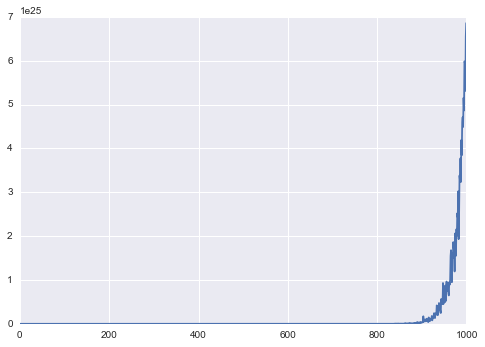

In [265]:
(pd.Series(pv_history_list)).plot()

In [266]:
q_df_column_list = ['col' + str(x) for x in range(1, 247 + 1)]
q_df_column_list.extend(['Date', 'Q'])
q_df = q_df[q_df_column_list]
display(q_df.head())

display(q_df.tail())

,col1,col2,col3,col4,col5,col6,col7,col8,col9,col10,col11,col12,col13,col14,col15,col16,col17,col18,col19,col20,col21,col22,col23,col24,col25,...,col225,col226,col227,col228,col229,col230,col231,col232,col233,col234,col235,col236,col237,col238,col239,col240,col241,col242,col243,col244,col245,col246,col247,Date,Q
0,-0.013282,0.074533,0.043080,-0.033101,0.035576,0.064106,0.086568,0.023200,0.010444,0.043954,0.003804,0.038695,-0.010545,-0.033707,-0.034220,0.016348,-0.022597,-0.005762,0.075540,-0.029490,0.028675,0.011017,0.000614,0.006401,0.074301,...,-0.077787,-0.131083,0.054133,0.020911,-0.264693,0.133544,0.019523,0.106264,-0.181396,0.063807,0.024186,0.181282,-0.042657,-0.115269,-0.072170,0.137637,-0.041527,-0.150955,0.032499,-0.018535,-0.229397,0.126263,Sell,1993-06-09,0.031686
1,-0.081476,0.115844,0.009583,0.024167,0.037683,-0.023478,0.105909,0.040472,0.117085,-0.111326,-0.024124,-0.083090,-0.024491,0.015970,-0.052190,0.052040,-0.052984,0.106139,0.030852,0.028199,-0.013891,-0.003815,-0.008466,0.055730,0.023326,...,0.203995,-0.056598,-0.149949,0.225622,0.063948,-0.141363,-0.129760,-0.156932,-0.356854,-0.003617,0.264709,-0.048398,-0.056092,0.309364,-0.163843,0.057854,0.322113,-0.187017,0.021461,-0.381965,0.067765,-0.270516,Buy,1987-12-15,0.044561
2,0.058891,-0.072922,-0.018439,0.012906,0.015180,-0.010750,0.041193,0.029425,-0.044025,-0.037955,0.014974,0.004140,0.060735,-0.017660,0.002093,0.033124,-0.005072,0.014310,-0.001490,0.027555,0.010644,-0.002292,0.016064,-0.017245,0.007076,...,-0.055101,-0.078576,-0.001434,0.097557,0.037120,0.133402,-0.007218,-0.042462,0.012381,0.036462,0.022223,-0.058403,0.027073,-0.025219,-0.193887,0.100683,0.202528,0.177047,0.002285,-0.045722,0.025949,-0.020426,Buy,1994-07-21,0.014271
3,0.054596,-0.042249,0.024808,0.012969,0.023773,0.000185,0.153231,0.073652,0.012464,0.023229,-0.001162,-0.012785,0.025126,0.002310,0.039369,-0.003430,0.011963,-0.011456,-0.043353,-0.024347,-0.003984,-0.014104,-0.017961,0.022021,-0.043333,...,-0.004525,-0.041333,-0.051290,-0.251011,0.292689,0.102855,-0.137785,0.067439,0.034241,0.164695,0.365275,-0.060988,0.033920,0.249898,0.236698,0.054198,-0.091894,0.123883,-0.108040,-0.262050,0.033359,-0.095918,Sell,1993-09-01,0.030165
4,-0.133097,0.165870,-0.066290,0.085181,-0.054384,0.041569,0.084042,0.014058,0.007629,0.072845,-0.018077,-0.011463,0.106026,0.010669,-0.008261,0.013887,0.022510,0.057262,0.134020,-0.079485,-0.025374,-0.006604,-0.020803,-0.083389,0.010071,...,-0.005885,0.059507,-0.213892,-0.003666,0.047582,0.023895,0.097469,-0.068110,-0.015340,0.040979,0.076293,-0.164986,0.033804,-0.136435,0.055816,-0.043118,0.030737,0.016341,-0.032011,-0.115858,0.010241,0.110504,Sell,1987-03-30,0.016843


,col1,col2,col3,col4,col5,col6,col7,col8,col9,col10,col11,col12,col13,col14,col15,col16,col17,col18,col19,col20,col21,col22,col23,col24,col25,...,col225,col226,col227,col228,col229,col230,col231,col232,col233,col234,col235,col236,col237,col238,col239,col240,col241,col242,col243,col244,col245,col246,col247,Date,Q
16003,-0.079905,-0.076315,-0.052405,0.059641,0.004073,-0.013697,-0.115265,0.020193,0.020319,0.000632,0.015824,0.000345,-0.033215,-0.006480,-0.026680,-0.004085,-0.018873,0.000675,0.002844,0.048414,0.007473,0.013557,0.007063,0.030911,-0.002312,...,-0.037176,-0.009338,0.027301,0.040675,0.113523,-0.194289,-0.007714,-0.095390,0.106128,0.079953,-0.118699,-0.111666,0.001311,0.103848,-0.021790,-0.008281,0.010094,0.177370,-0.004737,0.156386,-0.152942,0.260749,Buy,2004-01-14,0.009174
16004,0.014694,0.079746,-0.045092,-0.055440,0.032965,0.014877,-0.007230,-0.090235,-0.017460,0.037194,-0.036537,-0.004686,-0.029116,0.006558,0.011339,-0.044533,0.012903,0.000751,-0.011661,-0.036916,-0.018261,-0.040892,0.028423,-0.051704,0.044729,...,-0.155835,0.026293,-0.083975,-0.225928,-0.035651,0.072432,0.211187,-0.029774,0.021554,-0.007655,-0.067643,0.014357,-0.111173,-0.069851,-0.120497,-0.093744,0.088597,-0.181003,0.014793,0.032282,0.141098,-0.206106,Buy,1993-04-12,0.029217
16005,0.131757,-0.053942,0.002664,0.026037,0.011727,0.006003,-0.003027,-0.007437,0.010973,0.013575,-0.000700,0.003981,0.010326,0.027951,0.001697,-0.001905,0.007258,-0.007859,0.013361,0.031170,0.004742,0.009790,-0.000354,-0.001882,0.001017,...,-0.109218,-0.066692,0.112569,-0.156486,-0.061156,0.091980,-0.198394,0.025111,0.027135,-0.092238,0.000245,-0.225920,0.032455,-0.049393,0.154059,-0.064737,-0.128945,-0.148470,0.119033,0.102373,-0.055331,0.118798,Sell,2012-01-30,0.014212
16006,0.088047,0.030517,-0.031750,-0.013083,-0.020298,-0.032757,0.026528,-0.026919,0.000066,0.003389,0.034469,-0.002708,0.030787,0.004427,-0.011264,-0.024596,-0.027855,0.004885,-0.024868,-0.074437,-0.001748,0.001353,0.010003,0.015613,-0.047359,...,0.130450,0.012249,0.005452,-0.083352,-0.398152,-0.144243,0.164610,0.119548,-0.096355,-0.057872,-0.245697,0.011067,0.068893,-0.101918,-0.043443,0.107752,-0.092145,0.062989,-0.076219,-0.080564,0.246175,-0.002555,Sell,2008-12-23,0.028215
16007,0.146216,-0.057274,-0.000628,0.007624,0.005386,-0.004540,0.013424,-0.016057,0.020498,-0.016493,-0.011521,0.002880,0.018567,-0.004341,0.006594,0.001293,0.010602,-0.004245,-0.008616,-0.000177,0.001611,0.010218,-0.013368,-0.004840,0.008951,...,-0.092421,0.091844,-0.055601,-0.064406,0.072561,-0.041682,0.372388,0.049703,0.029783,-0.026285,0.018771,0.059673,-0.016833,-0.074291,-0.334083,-0.173379,-0.011000,-0.058698,0.024809,-0.096280,0.048405,-0.005862,Buy,2013-08-22,0.006348


In [267]:
def action_to_int(string):
    if string == 'Buy':
        return 1
    elif string == 'Sell':
        return 2
    
q_df['col247'] = q_df['col247'].apply(action_to_int)

display(q_df)

,col1,col2,col3,col4,col5,col6,col7,col8,col9,col10,col11,col12,col13,col14,col15,col16,col17,col18,col19,col20,col21,col22,col23,col24,col25,...,col225,col226,col227,col228,col229,col230,col231,col232,col233,col234,col235,col236,col237,col238,col239,col240,col241,col242,col243,col244,col245,col246,col247,Date,Q
0,-0.013282,0.074533,0.043080,-0.033101,0.035576,0.064106,0.086568,0.023200,0.010444,0.043954,0.003804,0.038695,-0.010545,-0.033707,-0.034220,0.016348,-0.022597,-0.005762,0.075540,-0.029490,0.028675,0.011017,0.000614,0.006401,0.074301,...,-0.077787,-0.131083,0.054133,0.020911,-0.264693,0.133544,0.019523,0.106264,-0.181396,0.063807,0.024186,0.181282,-0.042657,-0.115269,-0.072170,0.137637,-0.041527,-0.150955,0.032499,-0.018535,-0.229397,0.126263,2,1993-06-09,0.031686
1,-0.081476,0.115844,0.009583,0.024167,0.037683,-0.023478,0.105909,0.040472,0.117085,-0.111326,-0.024124,-0.083090,-0.024491,0.015970,-0.052190,0.052040,-0.052984,0.106139,0.030852,0.028199,-0.013891,-0.003815,-0.008466,0.055730,0.023326,...,0.203995,-0.056598,-0.149949,0.225622,0.063948,-0.141363,-0.129760,-0.156932,-0.356854,-0.003617,0.264709,-0.048398,-0.056092,0.309364,-0.163843,0.057854,0.322113,-0.187017,0.021461,-0.381965,0.067765,-0.270516,1,1987-12-15,0.044561
2,0.058891,-0.072922,-0.018439,0.012906,0.015180,-0.010750,0.041193,0.029425,-0.044025,-0.037955,0.014974,0.004140,0.060735,-0.017660,0.002093,0.033124,-0.005072,0.014310,-0.001490,0.027555,0.010644,-0.002292,0.016064,-0.017245,0.007076,...,-0.055101,-0.078576,-0.001434,0.097557,0.037120,0.133402,-0.007218,-0.042462,0.012381,0.036462,0.022223,-0.058403,0.027073,-0.025219,-0.193887,0.100683,0.202528,0.177047,0.002285,-0.045722,0.025949,-0.020426,1,1994-07-21,0.014271
3,0.054596,-0.042249,0.024808,0.012969,0.023773,0.000185,0.153231,0.073652,0.012464,0.023229,-0.001162,-0.012785,0.025126,0.002310,0.039369,-0.003430,0.011963,-0.011456,-0.043353,-0.024347,-0.003984,-0.014104,-0.017961,0.022021,-0.043333,...,-0.004525,-0.041333,-0.051290,-0.251011,0.292689,0.102855,-0.137785,0.067439,0.034241,0.164695,0.365275,-0.060988,0.033920,0.249898,0.236698,0.054198,-0.091894,0.123883,-0.108040,-0.262050,0.033359,-0.095918,2,1993-09-01,0.030165
4,-0.133097,0.165870,-0.066290,0.085181,-0.054384,0.041569,0.084042,0.014058,0.007629,0.072845,-0.018077,-0.011463,0.106026,0.010669,-0.008261,0.013887,0.022510,0.057262,0.134020,-0.079485,-0.025374,-0.006604,-0.020803,-0.083389,0.010071,...,-0.005885,0.059507,-0.213892,-0.003666,0.047582,0.023895,0.097469,-0.068110,-0.015340,0.040979,0.076293,-0.164986,0.033804,-0.136435,0.055816,-0.043118,0.030737,0.016341,-0.032011,-0.115858,0.010241,0.110504,2,1987-03-30,0.016843
5,0.109929,-0.023864,-0.015937,0.042878,-0.019745,-0.000889,0.045529,-0.014272,0.047166,0.032866,-0.015591,-0.028238,0.021601,0.008192,-0.012249,-0.012972,-0.001569,-0.005807,0.022686,-0.025407,0.018764,-0.018481,0.006070,-0.046078,0.013999,...,0.044562,-0.039251,-0.154837,0.071596,0.077083,0.135771,-0.087018,-0.021759,0.236970,-0.098935,0.144403,-0.134107,0.037696,0.182622,-0.015588,-0.038993,-0.073317,0.122908,0.100009,-0.097694,-0.060270,0.094014,1,2002-05-21,0.009113
6,-0.697189,-0.304689,-0.190535,0.220114,-0.005386,0.137090,-0.043617,-0.300399,0.132708,-0.091923,-0.153253,0.100743,0.002254,-0.204032,0.021034,0.031626,0.002922,0.165661,0.065011,0.230192,-0.139877,0.027335,0.128064,-0.120775,-0.126844,...,-0.031377,0.031484,0.071649,0.200052,0.000862,0.004030,0.232681,-0.105140,0.280785,0.120711,-0.089492,0.043371,0.028956,-0.031122,-0.010907,0.034430,-0.096480,-0.137259,0.258990,-0.053132,-0.051750,0.193588,2,1990-06-13,0.001867
7,0.064792,0.028972,-0.019617,0.029620,-0.027912,0.041368,0.080723,-0.031227,0.012330,0.015582,0.012498,-0.004323,-0.033569,-0.025738,-0.000334,0.006583,0.003169,0.003314,-0.002503,-0.007413,-0.003926,-0.005724,-0.017997,-0.043990,0.070132,...,-0.084185,-0.015533,-0.034123,0.067898,0.196609,-0.089041,-0.165443,0.137144,-0.152689,-0.269012,0.025667,-0.001680,-0.137349,-0.14328

In [268]:
q_df.sort_values('Date', inplace=True)
q_df.reset_index(inplace=True)
del q_df['index']
# del dfQ['col38']
q_df.set_index(q_df['Date'], inplace=True)
del q_df.index.name
del q_df['Date']
display(q_df.head())
display(q_df.tail())

,col1,col2,col3,col4,col5,col6,col7,col8,col9,col10,col11,col12,col13,col14,col15,col16,col17,col18,col19,col20,col21,col22,col23,col24,col25,...,col224,col225,col226,col227,col228,col229,col230,col231,col232,col233,col234,col235,col236,col237,col238,col239,col240,col241,col242,col243,col244,col245,col246,col247,Q
1984-12-28,-0.518838,0.158234,-0.073015,0.144767,-0.133940,0.234855,-0.588997,0.142228,-0.019948,0.301710,0.008094,-0.184463,0.030863,-0.122910,0.157421,-0.118945,0.141582,-0.097597,0.138488,-0.140422,0.069410,-0.036224,0.087777,0.201651,-0.275349,...,-0.030503,0.194302,0.241964,0.030886,0.054335,-0.138031,-0.113197,-0.126954,-0.112659,-0.011789,-0.174856,0.036543,0.212350,0.058027,0.041058,0.048875,0.004619,0.085683,-0.209500,-0.283153,-0.028577,-0.299189,0.346088,2,0.004796
1984-12-28,-0.518838,0.158234,-0.073015,0.144767,-0.133940,0.234855,-0.588997,0.142228,-0.019948,0.301710,0.008094,-0.184463,0.030863,-0.122910,0.157421,-0.118945,0.141582,-0.097597,0.138488,-0.140422,0.069410,-0.036224,0.087777,0.201651,-0.275349,...,-0.030503,0.194302,0.241964,0.030886,0.054335,-0.138031,-0.113197,-0.126954,-0.112659,-0.011789,-0.174856,0.036543,0.212350,0.058027,0.041058,0.048875,0.004619,0.085683,-0.209500,-0.283153,-0.028577,-0.299189,0.346088,1,-0.006359
1984-12-31,-0.504316,0.181769,-0.046594,0.139149,-0.197573,0.214874,-0.540922,0.086734,-0.098208,0.302762,-0.088205,-0.157652,-0.007762,-0.143023,0.135969,-0.111755,0.054343,-0.163258,0.073135,-0.191093,-0.002065,-0.084281,0.002681,0.153670,-0.202577,...,0.006842,-0.160821,0.190996,0.032337,0.103132,-0.021073,-0.065730,0.014307,-0.045318,0.014864,-0.279869,0.121842,-0.080919,-0.113363,0.181040,0.237756,0.172075,0.080032,-0.378378,0.272624,-0.044105,-0.212293,-0.027886,1,0.004441
1984-12-31,-0.504316,0.181769,-0.046594,0.139149,-0.197573,0.214874,-0.540922,0.086734,-0.098208,0.302762,-0.088205,-0.157652,-0.007762,-0.143023,0.135969,-0.111755,0.054343,-0.163258,0.073135,-0.191093,-0.002065,-0.084281,0.002681,0.153670,-0.202577,...,0.006842,-0.160821,0.190996,0.032337,0.103132,-0.021073,-0.065730,0.014307,-0.045318,0.014864,-0.279869,0.121842,-0.080919,-0.113363,0.181040,0.237756,0.172075,0.080032,-0.378378,0.272624,-0.044105,-0.212293,-0.027886,2,0.007769
1985-01-02,-0.502398,0.180432,-0.021510,0.152596,-0.257849,0.181823,-0.506090,0.012569,-0.160910,0.279036,-0.158034,-0.098888,-0.055046,-0.154284,0.082724,-0.078006,-0.010113,-0.160492,-0.005353,-0.276863,-0.072700,-0.038676,-0.045199,0.052739,-0.195562,...,-0.185081,-0.125642,0.026412,-0.020118,-0.048236,-0.013194,0.081007,-0.080664,-0.025885,0.052925,-0.136823,-0.170509,-0.140059,-0.187537,0.326823,0.221045,-0.447105,0.178073,0.152282,0.068245,0.194023,-0.002476,0.267516,2,0.010681


,col1,col2,col3,col4,col5,col6,col7,col8,col9,col10,col11,col12,col13,col14,col15,col16,col17,col18,col19,col20,col21,col22,col23,col24,col25,...,col224,col225,col226,col227,col228,col229,col230,col231,col232,col233,col234,col235,col236,col237,col238,col239,col240,col241,col242,col243,col244,col245,col246,col247,Q
2016-09-23,0.142513,-0.016124,-0.029960,0.003017,-0.002914,0.001390,0.060982,0.017661,-0.002457,-0.005613,0.018891,-0.017222,-0.003293,-0.024055,-0.004402,-0.001978,-0.001062,-0.017889,0.013944,-0.010417,-0.004320,-0.009562,0.012997,0.000749,-0.015314,...,-0.038098,-0.080557,0.012496,-0.236671,-0.005670,0.042062,0.071020,0.057536,-0.068980,-0.153885,0.036373,0.084406,0.210873,0.123107,0.053103,0.105773,-0.060494,-0.015635,0.088037,-0.069949,-0.112945,-0.226125,0.088787,1,-0.017783
2016-09-26,0.142222,-0.015898,-0.029776,0.006436,-0.002541,0.002961,0.061019,0.017926,-0.002632,-0.004880,0.010076,-0.024320,0.002324,-0.022027,-0.013658,-0.004121,0.003993,-0.022178,0.006552,-0.008914,-0.013144,0.000692,0.011148,0.015993,-0.002499,...,-0.002104,0.107944,-0.186000,-0.084510,0.151536,-0.000400,0.134843,-0.052786,-0.048110,0.036021,-0.123863,-0.052050,0.003066,0.045500,0.107923,0.075982,0.239939,0.171398,-0.192953,0.220456,-0.158531,0.008052,0.095232,1,0.002188
2016-09-26,0.142222,-0.015898,-0.029776,0.006436,-0.002541,0.002961,0.061019,0.017926,-0.002632,-0.004880,0.010076,-0.024320,0.002324,-0.022027,-0.013658,-0.004121,0.003993,-0.022178,0.006552,-0.008914,-0.013144,0.000692,0.011148,0.015993,-0.002499,...,-0.002104,0.107944,-0.186000,-0.084510,0.151536,-0.000400,0.134843,-0.052786,-0.048110,0.036021,-0.123863,-0.052050,0.003066,0.045500,0.107923,0.075982,0.239939,0.171398,-0.192953,0.220456,-0.158531,0.008052,0.095232,2,0.001048
2016-09-27,0.149040,-0.015392,-0.028239,0.009827,-0.001910,0.002964,0.053901,0.016441,-0.001042,-0.004851,-0.002310,-0.025717,0.002998,-0.014742,-0.018969,-0.009615,0.005203,-0.023300,-0.002351,-0.009072,-0.002852,0.011493,-0.002877,0.023005,0.002245,...,0.069868,0.134445,0.003155,0.014822,-0.029709,-0.105764,0.041751,-0.144909,0.034983,0.068740,-0.031763,-0.079416,-0.080951,0.010223,0.030583,0.195681,-0.136826,0.126029,0.166533,-0.060980,0.118224,0.167783,0.006194,2,0.002772
2016-09-27,0.149040,-0.015392,-0.028239,0.009827,-0.001910,0.002964,0.053901,0.016441,-0.001042,-0.004851,-0.002310,-0.025717,0.002998,-0.014742,-0.018969,-0.009615,0.005203,-0.023300,-0.002351,-0.009072,-0.002852,0.011493,-0.002877,0.023005,0.002245,...,0.069868,0.134445,0.003155,0.014822,-0.029709,-0.105764,0.041751,-0.144909,0.034983,0.068740,-0.031763,-0.079416,-0.080951,0.010223,0.030583,0.195681,-0.136826,0.126029,0.166533,-0.060980,0.118224,0.167783,0.006194,1,0.002053


In [14]:
import pandas as pd
from IPython.display import display

q_df = pd.read_csv('pca_q_df_1000_full.csv', parse_dates=True, na_values = ['nan'])
q_df.set_index(q_df['Unnamed: 0'], inplace=True)
del q_df.index.name
del q_df['Unnamed: 0']
q_df.index = pd.to_datetime(q_df.index)
display(q_df.head())
display(q_df.index[0])



,col1,col2,col3,col4,col5,col6,col7,col8,col9,col10,...,col239,col240,col241,col242,col243,col244,col245,col246,col247,Q
1984-12-28,-0.518838,0.158234,-0.073015,0.144767,-0.133940,0.234855,-0.588997,0.142228,-0.019948,0.301710,...,0.048875,0.004619,0.085683,-0.209500,-0.283153,-0.028577,-0.299189,0.346088,2,0.004796
1984-12-28,-0.518838,0.158234,-0.073015,0.144767,-0.133940,0.234855,-0.588997,0.142228,-0.019948,0.301710,...,0.048875,0.004619,0.085683,-0.209500,-0.283153,-0.028577,-0.299189,0.346088,1,-0.006359
1984-12-31,-0.504316,0.181769,-0.046594,0.139149,-0.197573,0.214874,-0.540922,0.086734,-0.098208,0.302762,...,0.237756,0.172075,0.080032,-0.378378,0.272624,-0.044105,-0.212293,-0.027886,1,0.004441
1984-12-31,-0.504316,0.181769,-0.046594,0.139149,-0.197573,0.214874,-0.540922,0.086734,-0.098208,0.302762,...,0.237756,0.172075,0.080032,-0.378378,0.272624,-0.044105,-0.212293,-0.027886,2,0.007769
1985-01-02,-0.502398,0.180432,-0.021510,0.152596,-0.257849,0.181823,-0.506090,0.012569,-0.160910,0.279036,...,0.221045,-0.447105,0.178073,0.152282,0.068245,0.194023,-0.002476,0.267516,2,0.010681


Timestamp('1984-12-28 00:00:00')

In [16]:
from datetime import timedelta, datetime

last_training_day = datetime(2014, 6, 30)

train_data = q_df[:last_training_day]
cv_data = q_df[last_training_day + timedelta(days=1):datetime(2016, 6, 30)]

X_train = train_data.ix[:, :-1]
y_train = train_data.ix[:, -1]
X_cv = cv_data.ix[:, :-1]
y_cv = cv_data.ix[:, -1]

display(X_train.head())
display(y_train.head())

,col1,col2,col3,col4,col5,col6,col7,col8,col9,col10,...,col238,col239,col240,col241,col242,col243,col244,col245,col246,col247
1984-12-28,-0.518838,0.158234,-0.073015,0.144767,-0.133940,0.234855,-0.588997,0.142228,-0.019948,0.301710,...,0.041058,0.048875,0.004619,0.085683,-0.209500,-0.283153,-0.028577,-0.299189,0.346088,2
1984-12-28,-0.518838,0.158234,-0.073015,0.144767,-0.133940,0.234855,-0.588997,0.142228,-0.019948,0.301710,...,0.041058,0.048875,0.004619,0.085683,-0.209500,-0.283153,-0.028577,-0.299189,0.346088,1
1984-12-31,-0.504316,0.181769,-0.046594,0.139149,-0.197573,0.214874,-0.540922,0.086734,-0.098208,0.302762,...,0.181040,0.237756,0.172075,0.080032,-0.378378,0.272624,-0.044105,-0.212293,-0.027886,1
1984-12-31,-0.504316,0.181769,-0.046594,0.139149,-0.197573,0.214874,-0.540922,0.086734,-0.098208,0.302762,...,0.181040,0.237756,0.172075,0.080032,-0.378378,0.272624,-0.044105,-0.212293,-0.027886,2
1985-01-02,-0.502398,0.180432,-0.021510,0.152596,-0.257849,0.181823,-0.506090,0.012569,-0.160910,0.279036,...,0.326823,0.221045,-0.447105,0.178073,0.152282,0.068245,0.194023,-0.002476,0.267516,2


1984-12-28    0.004796
1984-12-28   -0.006359
1984-12-31    0.004441
1984-12-31    0.007769
1985-01-02    0.010681
Name: Q, dtype: float64

Creating learning curve graphs for max_depths of 1, 3, 5, 7. . .


/home/calvinjku/anaconda2/envs/python2/lib/python2.7/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


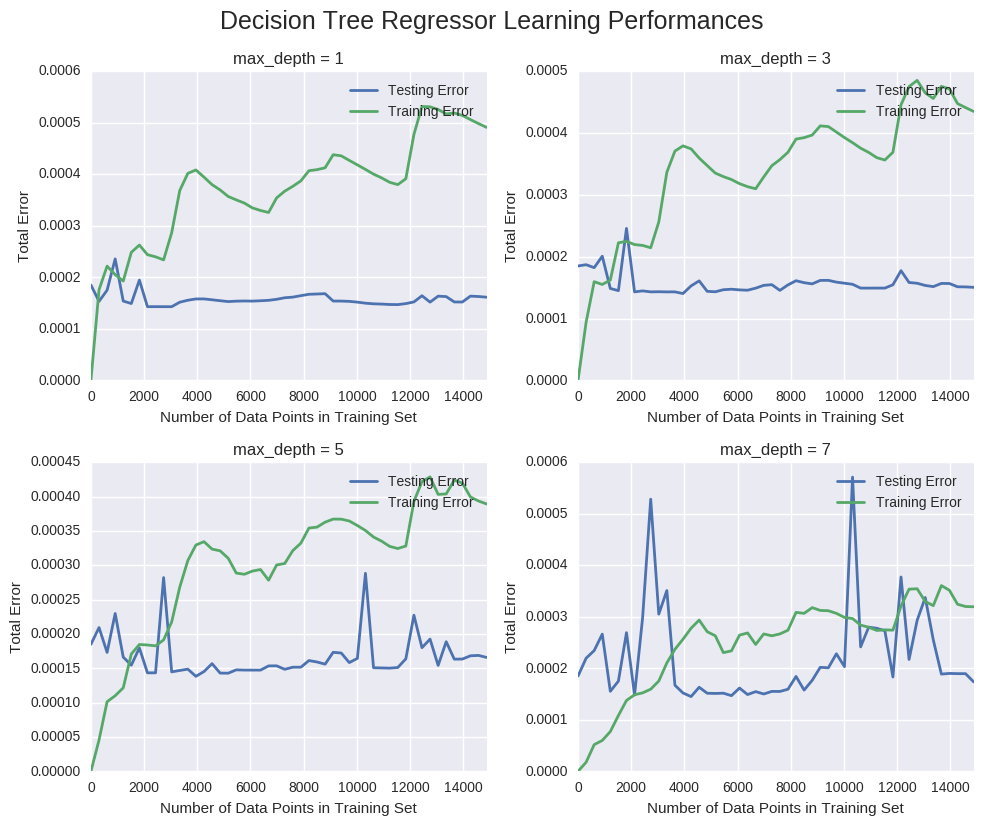

In [21]:
learning_curves(X_train, y_train, X_cv, y_cv)

Creating a model complexity graph. . . 


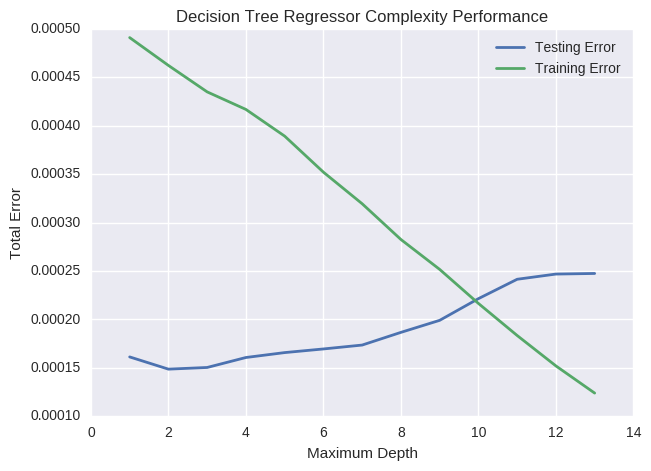

In [22]:
model_complexity(X_train, y_train, X_cv, y_cv)

In [30]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

start_time = time.time()

# reg = KNeighborsRegressor(n_neighbors=10, weights='uniform', algorithm='auto', leaf_size=30, p=2, metric='minkowski')
# reg = AdaBoostRegressor(DecisionTreeRegressor(max_depth=2), n_estimators=100, random_state=0)
reg = RandomForestRegressor(n_estimators=128, max_features='sqrt', n_jobs=-1, random_state=0)
reg.fit(X_train, y_train)

y_pred = reg.predict(X_cv)

r2 = r2_score(list(y_cv), y_pred)
r2_train = r2_score(y_train, reg.predict(X_train))
print(r2_train)
print(r2)

print("Regression took {} seconds".format(time.time() - start_time))

0.910571232231
-0.0576013990331
Regression took 4.73284482956 seconds


In [ ]:
0.922342137436
-0.126957697411

In [286]:
q_df.to_csv('pca_q_df_' + str(1000) + '_full.csv')

In [ ]:
import renders as rs
from sklearn.decomposition import PCA
# TODO: Apply PCA to the good data with the same number of dimensions as features
pca_X = PCA(n_components=3)
pca_features = PCA(n_components=2)

pca_X.fit(dfQ_X)
pca_features.fit(dfQ_features)

# TODO: Apply a PCA transformation to the sample log-data
# pca_samples = pca.transform(log_samples)

# Generate PCA results plot
# pca_results = rs.pca_results(dfQ_X, pca)
print(np.sum(pca_X.explained_variance_ratio_))
print(pca_X.explained_variance_ratio_)

print(np.sum(pca_features.explained_variance_ratio_))
print(pca_features.explained_variance_ratio_)

In [ ]:
(u,) = data_full.index.get_indexer_for([datetime(2016, 9, 20)])
print(u)

print(data_full[datetime(2015, 1, 2):].shape)

In [ ]:
display(data_full['Trade Price'].head(10))
print(data_full.index.get_indexer_for([datetime(2016, 7, 1)]))
data_full.ix[datetime(2016, 7, 1):]['Trade Price'].plot() 
# data_full.ix[datetime(2016, 8, 15):datetime(2016, 8, 31)]['Trade Price'].plot()
print(len(data_full.ix[datetime(, 7, 1):datetime(2016, 6, 30), 'Trade Price']))

In [ ]:
profit = [1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1017.5500135000001, 1018.2249909999999, 1013.1249669999999, 1009.735006, 1012.7199955, 1012.7199955, 1015.9450254999999, 1014.5199955000001, 1017.2499744999999, 1017.2499744999999, 1017.2499744999999, 1017.2499744999999, 1017.0399669999998, 1012.9449894999999, 1024.0000060000002, 1024.0000060000002, 1024.0000060000002, 1024.0000060000002, 1022.0800585000003, 1014.7150075000004, 1014.7150075000004, 1011.8950360000006, 1018.7500330000007, 1018.7500330000007, 1022.6200420000008, 1022.6200420000008, 1022.6200420000008, 1022.1250585000008, 1023.2499955000008, 1024.7799865000006, 1025.680045000001, 1029.1450465000007, 1037.5299865000009, 1045.3750135000007, 1047.6700225000009, 1045.4350120000008, 1047.2950150000011, 1047.220048000001, 1047.220048000001, 1047.220048000001, 1047.220048000001, 1047.220048000001, 1041.520067500001, 1040.875081000001, 1040.875081000001, 1040.875081000001, 1040.875081000001, 1040.875081000001, 1040.875081000001, 1047.3251215000012, 1047.6551365000009, 1047.6551365000009, 1048.3901845000009]
profit_s = pd.Series(profit)
profit_s[:35].plot(ylim=[1000, 1045])


In [ ]:
profit2 = [1000.0, 1000.0, 1000.0, 1011.6160431999999, 1029.5040528, 1029.5040528, 1029.5040528, 1029.5040528, 1029.5040528, 1029.5040528, 1029.5040528, 1025.8880944000002, 1025.8880944000002, 1025.8880944000002, 1029.3281264000002, 1027.8080944000003, 1027.8080944000003, 1030.5281600000005, 1027.5681056000005, 1025.1521344000003, 1024.9281264000003, 1020.5601504000005, 1020.5601504000005, 1020.5601504000005, 1041.7552074000005, 1043.8401594000006, 1041.9202119000006, 1041.9202119000006, 1041.9202119000006, 1041.9202119000006, 1048.7752089000007, 1048.7752089000007, 1048.7752089000007, 1048.7752089000007, 1048.2802419000006, 1048.2802419000006, 1048.2802419000006, 1048.2802419000006, 1049.1803004000008, 1052.6453019000005, 1052.6453019000005, 1052.6453019000005, 1054.9403109000007, 1054.9403109000007, 1054.9403109000007, 1054.8653439000007, 1050.3953829000006, 1050.3953829000006, 1050.3953829000006, 1050.3953829000006, 1050.3953829000006, 1049.7503964000007, 1052.3603829000008, 1042.8503709000006, 1042.8503709000006, 1042.8503709000006, 1042.8503709000006, 1042.8503709000006, 1042.8503709000006, 1042.8503709000006, 1043.5854189000006]
print(len(profit2))
profit2_s = pd.Series(profit2)

# data_full.iloc[8095+58:]['Trade Price'].plot()
# plt.figure()
profit_s.plot(ylim=[1000, 1060])
plt.figure()
profit2_s[:].plot()

In [ ]:
display(len(data_full.ix[datetime(1984, 5, 23):datetime(2016, 6, 30), :]))

In [ ]:
prof = [1559.2819664782578, 6768.6682957190233, 9368.5863430112968, 2516.7148358736481, 8997.3746970867851, 18294.438669649939, 5450.7247834545233, 1000.1994167455314, 10221.591930386869, 4421.9715725716233, 3338.9220097552084, 9066.1049065462776, 3288.2203947953517, 2617.1669545582799, 35291.828760033844, 4390.1328470528415, 7708.9555605668793, 8831.4422954865349, 6677.8025663339449, 9801.1403446635522, 1061.4428958510568, 49184.77509727369, 18016.005222994703, 13332.682974362337, 6619.0716268552469, 16617.945026915746, 10444.081121603815, 30593.613490202184, 8614.1513865423422, 3586.762032864242, 5108.0178358065405, 5344.778296471507, 26548.50076556925, 4568.4355637054723, 32635.077134961943, 6637.0630565515248, 12160.107684934064, 8191.66692296777, 13683.969826961156, 20638.511267607351, 817.37726597529911, 2182.1538332795781, 55548.778612313035, 3165.278751195819, 7361.9265961509245, 13582.00073872153, 10449.840293758327, 6310.2435512355914, 8278.7483071661536, 5975.7926111132219, 14389.889352040173, 14514.817757001078, 24561.947125653616, 15869.999669777346, 9010.7912802704595, 14700.166312885078, 4898.0203234962646, 18568.466163847079, 6865.1268654304477, 9350.1206480318542, 34968.05075777803, 4854.8475388526886, 39144.423208800326, 5799.373958148718, 3296.2724695876786, 8325.3167500937161, 5522.4182997715061, 33818.300449505994, 12536.254616589671, 3940.4959040680815, 17896.489856404023, 11858.568384205961, 8653.514665510882, 13307.382492136168, 12294.052117339514, 46825.281828043451, 58976.297108712868, 40876.55342385827, 20592.607004820464, 20465.268569027121, 7356.8541092574833, 18423.695003591929, 16397.062616658011, 6866.0962949653731, 3405.3997036619967, 4748.2557953054584, 9094.8958879347447, 23656.813615481711, 44426.931568342414, 74856.949546082484, 35421.995578849426, 11533.917623155743, 41081.325491213931, 24509.547313527517, 41834.168313717564, 33399.892647953551, 6676.9570437774455, 15978.708186099988, 13103.762886444079, 16934.904781549165, 18058.519336104142, 6326.6803394943163, 67447.378127219301, 18451.493505950813, 85061.391642021757, 23415.381394392454, 86412.015074569412, 36049.293324173639, 12145.529211503834, 14288.521305764043, 27568.520690640995, 58020.540284374838, 17140.442388596595, 59401.327557713739, 25017.423175553933, 48998.370420146734, 21414.76546810591, 8921.9353633804276, 5078.3144693496351, 7959.6525443705914, 22262.010896644093, 6514.8437180173578, 32040.933774852288, 37464.816352410067, 7343.7438977887568, 68261.661672335467, 19825.682881506757, 13120.825680653299, 68858.567343834409, 66746.787445351598, 11618.370834684849, 48507.472846941775, 35639.179889028965, 66506.360057927726, 33739.43527481347, 52290.484732822406, 69977.823683421011, 28667.276613870818, 50499.463277907402, 7084.1685257709969, 46453.149699826186, 20760.046830929576, 73247.022337562201, 90002.885189929264, 172492.88346187459, 36226.380864115585, 69324.851667811105, 73192.818813622755, 37826.184237750815, 63379.204151976635, 33942.126796989542, 36321.463385813229, 15726.534006022523, 73758.264285750542, 103638.18374759948, 64838.488000356905, 68229.781684834408, 136522.79872840247, 14680.807029685227, 8183.162697100056, 51203.89194588134, 49511.708106678219, 22317.611969049965, 41203.254827164463, 13759.313033182818, 181340.90973000074, 45442.954206417111, 33017.185871122376, 80359.858005544476, 191139.57605426083, 46245.205829725564, 93099.406930781755, 56723.912574933347, 174103.38134708922, 83998.287895801899, 58661.795968396153, 183097.45438970425, 61791.093385765984, 164417.46994641752, 175983.92944986856, 39893.699569965509, 125470.15159819875, 184702.33933222713, 49643.549909247151, 208220.7129059427, 72969.153614654701, 104753.7307286639, 128461.1693323081, 95044.608147252176, 101880.56869009373, 42396.031373139238, 38424.401341544348, 57316.735875458158, 33508.46938734674, 140259.55494796939, 190344.91043513338, 5913.6793780451171, 56265.815098330793, 133305.8460921213, 123637.66425258332, 72604.405566801375, 175240.56109574583, 24361.297079005661, 185361.2073624224, 54100.349621656394, 52869.365800770931, 370190.74978639535, 783484.41132087924, 231466.31114543596, 68628.271850876408, 74447.674318346151, 53557.12324470107, 13979.660133523235, 101801.80395111542, 169737.46012098339, 112756.95100564517, 62219.94584444612, 61278.189778311789, 142829.45050402766, 84181.332584626303, 150278.63149101011, 110867.74522313272, 136852.33626378136, 480850.99843337573, 324481.01717088523, 331953.74428356986, 376578.62549904885, 338970.27498826722, 123036.37809097373, 199525.77522128107, 151667.17838610237, 20273.843048140079, 150897.0795026134, 61332.490454231513, 172697.58053392376, 175120.20397947167, 274727.57078629511, 280621.89177350095, 81263.317991672433, 330752.34254189389, 41019.447808266894, 138622.67333379024, 466460.75921333785, 530939.36605093034, 299087.31054797984, 137064.19281437484, 86830.665352976721, 732502.41597919073, 251738.98988105363, 126216.07431026769, 119460.49392399915, 307917.98288807558, 346420.88559479057, 216680.44481629695, 537403.71006643015, 172889.51045386685, 510074.10777454806, 214637.78626996293, 1497599.8250336095, 132337.38080681753, 63559.349024597817, 93564.491480707278, 390468.29323820781, 122754.21133987042, 442893.92599005159, 107775.09463493932, 226399.0903410005, 116708.77971342795, 310925.50342982943, 366478.05355986115, 123184.51930388626, 72917.622845686157, 729189.87334375165, 337886.29817755596, 77863.312050223118, 572788.7816759143, 214907.61796397809, 540057.19248410617, 2639162.190129369, 947580.73532667768, 179792.90366184345, 1640326.0666591411, 333267.78874012741, 394971.27805047104, 149505.65842163103, 454584.61630896194, 250222.59089102925, 285372.46027394873, 59871.474691403688, 207941.53004323062, 1082114.8437339759, 1431132.7384025988, 3946809.3805680345, 440916.53977525578, 776968.76539001241, 497233.25358242192, 842476.15506501659, 1265620.7484264981, 444656.24560510821, 205571.8848737395, 453589.78629146377, 371293.78678454441, 982785.94756239897, 844510.35789743729, 2089036.3634566076, 591513.94657077524, 264174.42484827887, 397402.81006984814, 563103.54187849909, 370055.06934534723, 374230.4137275336, 836233.39505339868, 99939.570922180559, 663706.41016145202, 1207995.9065383603, 604973.6325402871, 975354.46314448444, 503818.59424436867, 1277788.7152337066, 438221.1826708251, 1574024.8841801642, 523939.73032536736, 652002.70008896978, 971346.46736348292, 596031.71678855177, 1903118.7806774373, 174202.16252321948, 392482.31012782885, 1707316.7522158662, 2674695.5574239348, 2543481.6573152319, 327716.32086095744, 1642307.3001924818, 507568.00876229734, 175576.98890534436, 873865.85753118224, 372154.93386735377, 2031389.8776951728, 2239624.4099017116, 177292.320147083, 1036644.3142263673, 191462.4335756338, 136482.64715938803, 1438172.2364531357, 325196.17410263087, 1850089.5652677545, 935538.93396839709, 909513.90468403301, 1139554.3713267106, 1795424.9675282876, 431792.94435931375, 1051202.4896126336, 3357271.0105361394, 2771064.0617048997, 898473.90147346735, 591555.75064835045, 1058033.256546624, 2923694.0311678424, 968167.17479507101, 902050.84638669423, 471748.55008239747, 310741.83559547906, 615076.63415077841, 243596.12712518455, 743249.68079789635, 586829.99415954005, 570394.0165953266, 4384703.8830684153, 26659151.793910064, 1562202.4562742405, 1776851.7828318456, 1527769.1073451333, 498234.32960739202, 2285739.6868428113, 857384.61354756996, 611704.39391176146, 4195107.4526702315, 4589702.7828425635, 1985134.18280274, 585033.98184484011, 999211.9125144172, 4103835.830623684, 231551.54440411134, 1216759.2865100552, 853906.0084773039, 9412979.7928338405, 1206517.9629745884, 2754769.7455477146, 4424137.5350690493, 711436.80512387352, 663346.15328777593, 5338701.8262260305, 1227080.747252241, 2748794.6645090138, 3602501.8118629996, 3062485.9277962809, 2908866.0676784203, 5354351.0648708241, 2179931.2115439638, 3897412.454428866, 2071766.0692861658, 8826744.1768453903, 5013010.8029408725, 8899069.8179548942, 5845189.3350760462, 2301083.1584679424, 3804135.7565094572, 1110981.1538952098, 3347341.2283991291, 5441025.8643462462, 2478172.1642906661, 5256206.9542841539, 933025.0874991708, 1470550.6182577489, 10590530.863778122, 2827358.7156457771, 4128346.1679457128, 16116376.615993878, 4365790.2673277156, 1522305.7260447051, 3703200.234243813, 6945291.9383626208, 4047745.8378471714, 3682726.3743397421, 2846750.7066638498, 2660324.2138707382, 1444949.1460182741, 1012083.7285844559, 4788484.6653759303, 4365905.0083891293, 2089673.92524572, 7767506.6178683927, 3623869.4224100523, 3283932.7098680278, 1637109.4591439457, 4575740.9533090414, 1263712.638536456, 1640986.7774417161, 20381345.860208604, 732868.50667150365, 3065184.6720731491, 10787700.595757386, 3459800.6006449456, 20987611.17862526, 6685523.4666398875, 1171947.1161238907, 1039831.997747359, 6117862.2529594377, 14773139.966220556, 4198626.2759632049, 2776534.6220658021, 1858618.7347723208, 3481546.1678287736, 10988246.042816324, 3615217.7350000842, 5320031.5922585512, 10851786.302630438, 14855228.212419203, 2005776.013958924, 18103268.447737589, 4058674.5527194617, 2868256.5025120988, 22500840.866706103, 4396673.0912441006, 3722623.0590348882, 5427992.2329913713, 11035451.265120851, 6458347.664130033, 1483261.6373617165, 9035062.4212596621, 1474174.3015840121, 9439114.6133949254, 14546089.142805969, 1039258.4409510047, 1558655.6740605228, 8432194.0079877116, 7731146.1565474104, 12604752.146469371, 2306454.951395167, 1010000.8590932768, 6926134.6135961358, 1131152.4815317742, 13784849.949500004, 23228303.177002326, 13466129.798911242, 4348421.4341552556, 4892125.5387735441, 12778952.319428084, 4716920.1233772291, 29034889.359711405, 20040677.184033174, 16125284.815423688, 5751599.4058833709, 8563702.366222987, 3290650.0304350383, 6837921.1836650101, 53580840.949446417, 7600066.7822729303, 1755600.0581779599, 30410607.557487994, 10409270.860613994, 6968055.9518592209, 21942389.557731543, 18542148.685015939, 10562591.060432743, 4582055.5524709905, 8714521.2998395767, 12678069.246533301, 6957143.2823497141, 4903942.7337870197, 9352315.1265281904, 3989661.1401293981, 26564636.230760995, 8269019.3358524675, 31574521.20048834, 3938793.1430111616, 11068246.88802184, 24896970.204110231, 3957677.6155892154, 10070117.233489485, 16894130.441961057, 9159231.8655194119, 9272450.7498420719, 38812068.848575912, 11811101.110368894, 7753636.238151853, 35787799.68994464, 8275584.2198401215, 10901020.738406479, 1993326.8168052845, 4402140.5097829495, 46465275.041218661, 24973193.901939947, 9168490.8609799836, 5692338.567095614, 46694449.732499473, 5704570.2347311685, 7072398.2080048379, 26107809.799837951, 6209686.6889535049, 15892849.964394679, 35584711.544651471, 48717507.369924568, 3023588.2769350451, 57150132.393086486, 10023902.088259134, 38527362.615729153, 11230255.771257099, 13194517.888303295, 11289627.163264845, 10934841.092428977, 5280570.329198475, 20468564.344364233, 11844642.691188611, 76826423.191611961, 25406168.328911036, 49410102.374775141, 15771117.671577761, 46721588.347360678, 28667489.963533558, 131115670.39534356, 56536538.288240306, 9437773.7933995351, 28205624.496443897, 45124334.088003479, 26824692.855144624, 19497660.144410037, 269269109.32650161, 6461874.9174414622, 377163830.17911243, 11590486.563305287, 9286501.9609844834, 24408687.487410694, 42375242.898080885, 118602549.01821776, 20779714.450717084, 16558881.795892123, 25995461.044363819, 173827299.20318162, 18757803.193641923, 48958132.890477628, 63775113.302338384, 29987915.677536782, 18443195.53025059, 18377012.133134622, 11608134.644268863, 8974044.2225291915, 111256900.64843671, 15686816.937313594, 120300067.16695508, 10000486.484391389, 6570249.8681066195, 31838903.53908179, 58310865.272599593, 44570480.572048992, 53947071.624253586, 91310327.451983094, 40925346.09569829, 60471374.648317821, 22089983.320269093, 23256215.02617494, 25680762.812441561, 30819204.966580711, 25590464.367616389, 116531479.22894375, 113118952.48983543, 304415801.8892377, 42413700.537703462, 101673706.74429137, 18830348.733037632, 34802980.219782859, 68707153.590106219, 43406928.829882674, 48862649.930590913, 198185965.5698936, 93995893.335669667, 80224667.518228903, 15832310.371521825, 196225600.77111104, 40808191.507062979, 73886272.254857644, 24501783.596522409, 165006194.58813947, 56034175.83399599, 33658638.095819026, 92130544.422100008, 139550693.68533108, 69808806.602089107, 51415131.447718143, 46362875.039666101, 19948939.386497069, 146490920.02054718, 12341183.739137253, 62031153.292262428, 308957099.75998449, 95162175.575348109, 26358459.941315729, 283629880.67666215, 32939221.680430535, 168505789.88619626, 139810895.2956523, 26104127.401479028, 22381635.329989769, 37901926.953133322, 68654016.915393636, 105839391.51639941, 274103943.94236404, 109977360.00168596, 288928711.92495209, 18124717.145581879, 78213603.213095605, 54092280.931608327, 91834693.607590169, 28873611.235937748, 657055305.8147192, 77933450.076828361, 62108890.744796395, 603666949.30718291, 106412877.15659456, 46992426.484258085, 110295618.44580789, 42311219.882510342, 111933726.79942004, 47223198.693050414, 229837768.7412827, 59226057.863138482, 243509525.13770986, 212389680.09555739, 135117933.29285201, 193906924.61019918, 50995920.831537955, 33653187.862272874, 646541791.47730887, 65295258.98132658, 121467731.95273373, 127505051.31751662, 84212411.12603648, 59294425.539131954, 355646673.94413608, 70232864.982723892, 342480846.50523263, 122578726.99856789, 302586047.81977874, 659305686.99183035, 119651246.4809504, 278429473.58078748, 42497548.830590017, 112121537.28586163, 143928968.0967083, 46972732.115943231, 130200343.33699805, 438808769.97620195, 60349721.075503565, 84756891.739332885, 200155082.13453928, 72475760.654745817, 149427309.89502272, 233122150.60178903, 410843714.06653273, 60310245.675104052, 277345773.6843819, 111101983.01842006, 234049323.25717613, 131627017.19632599, 113760081.34282006, 174809997.52058065, 184961670.63764963, 351920891.80418241, 195094722.41601124, 398958148.03908741, 754610238.90535903, 109789488.19150628, 62105209.654151797, 49440142.549605809, 93260113.93914023, 190675104.90926111, 212824738.92570427, 351012651.77018201, 72428351.095489249, 179407657.45598623, 1089827015.2265475, 159474993.94468445, 206168548.35272327, 240298130.36068526, 772612420.34894168, 216269642.69517162, 996278103.34825659, 653408087.5271728, 948556255.18037951, 53153399.008429311, 295097691.08291239, 156200922.76122135, 310747094.56076914, 408123385.77350688, 513679405.78289139, 216392952.00816438, 123557792.93716501, 467281148.15931648, 177158162.26124826, 71920012.269745961, 247790443.2677955, 674664296.13754761, 172334605.67899856, 180246824.12916631, 1138758017.267091, 292274415.13584298, 286270041.15997046, 168616721.72609338, 436196726.63819015, 879078826.91344154, 60205243.419514343, 200658710.83196798, 178531703.89732209, 860299474.46948195, 1375931203.6044617, 385936283.6464265, 709162999.38603365, 65564220.886859313, 452252176.49246484, 205715818.20366132, 474269506.88067997, 770650164.6668725, 143956957.38626096, 213331268.00968805, 544832880.05273306, 149105527.04952037, 319923845.14619517, 504565822.43368059, 138708926.20331961, 177318306.10696557, 183916344.04646352, 1125307560.3959484, 1350226633.0816333, 477286243.37008041, 2058094158.8473442, 274980506.61656189, 484167379.74490678, 481726868.56342715, 652646523.46556401, 114670485.91727312, 982953772.47536135, 1092312158.4279075, 1267188162.7278194, 650524385.98113298, 149283883.81664941, 1097340067.7132101, 557549274.83478558, 3334965897.0921617, 1350182567.3708291, 2106691750.3245122, 188830094.08808082, 297430491.72326046, 1725355846.1226907, 506449989.43372828, 618082079.71511173, 2250470439.7559862, 1398627298.4812343, 958820506.21681011, 733976203.7002722, 1084708239.5712609, 1080593013.3877845, 1258840984.6745944, 1005536975.9804965, 1043291954.0848116, 420221074.92420304, 592688407.4960686, 1255053716.6628883, 331320704.7642079, 72009549.31659846, 571141028.40929341, 1682578534.6585326, 836759370.51301622, 2731538713.8982263, 2946505314.9481254, 885685833.62444901, 2222736259.7397156, 1001596925.4249626, 1477228033.5554008, 853365270.28742719, 4850602071.414712, 3059784247.4259205, 309818936.05993527, 623467136.38357008, 1271661249.810653, 3279557828.5481958, 295674000.61157608, 3855948160.5610313, 1157640316.4382274, 1328626809.5898461, 630975140.35964417, 515110242.71145165, 1029468821.1265123, 426073554.23934412, 682952506.41901529, 3680066724.5939279, 3070847744.575583, 1118817190.1244197, 443995530.8919515, 866421396.51462317, 551460276.93201661, 1642277553.5223734, 4213642948.5037594, 562679780.66858304, 2225584782.8110442, 2292686344.9123411, 4118955926.7582436, 2153182896.3604951, 1442135859.1430895, 1191008924.7936821, 2368249938.4597764, 7325231118.4209585, 782916916.83662379, 3164207637.1728883, 902207361.28554845, 1210753977.4869184, 1082027552.9112761, 1787672893.1396322, 233032440.76428822, 2510871527.8736854, 2161009840.099277, 6802583979.4722767, 1413529492.6142187, 898773534.29463565, 1517468940.5206857, 1246590695.9656591, 1041467654.0349931, 11072251889.993708, 6169254415.6955442, 1769347736.050808, 2112423280.4787073, 4411943982.7524862, 8740588199.3490238, 2893829658.6441474, 1511551106.5355721, 1154530993.5924082, 2168010800.2598782, 597313797.57290792, 8527350821.374176, 1034784145.5828122, 8051437485.5099592, 2088595564.5289474, 8240389302.1242647, 4327291728.1436901, 752218852.92978203, 2665838391.9813094, 809713128.24852848, 4524604500.6156359, 1931312568.5166264, 3730235067.423553, 6045255162.6872292, 1786098801.9384773, 1561116513.4304481, 6634276449.7051258, 5635632839.4545326, 2465421206.5426645, 3295589436.2239251, 1541329250.4875233, 419078586.79548055, 4030730749.0348477, 2463538311.6485505, 1998318088.8224754, 5416097396.8656206, 3759398727.2003765, 5144399108.4270582, 8884094709.2877445, 57172451817.718193, 12077054676.826534, 4320759476.1184673, 9575783828.1986694, 1991624128.4213064, 3651860757.955205, 3781894646.8871875, 33790657920.021706, 11936546170.421633, 4178842893.1270323, 3542138249.5650535, 928024167.02821827, 3100117860.8691301, 2064538336.9228394, 30800805883.179367, 5829044178.7121429, 12818820821.765741, 18526607141.85569, 995960364.8784976, 12638338953.958752, 6911109673.7087173, 6418297357.7894526, 3105753867.2413163, 11854817872.134821, 39351211830.565529, 4189641884.2037201, 1527588368.4241929, 8609362645.1320419, 1323740734.8515379, 1227093868.1016552, 11809399884.045517, 18251504820.069817, 9740480289.4877224, 4923744723.8578539, 8438504721.894907, 14156177879.208237, 4245850439.7138062, 5691800957.4033222, 3931228676.2806678, 11000828005.664865, 15052966140.754274, 21543087518.142464, 1143251123.5914571, 6586610339.4264708, 4284442182.0098381, 1129108429.8532422, 27172287565.509892, 3591529518.1369567, 41036001377.991058, 21755034366.250095, 1457658759.4179044, 4593186568.7693462, 8357663872.1390209, 8147096700.0162392, 5288953203.0965652, 1996969040.3775961, 12064193505.013538, 8515313184.5991774, 15939447986.94906, 14499022585.106642, 21344293159.491241, 10991630665.808865, 5929839018.388814, 4869548624.8678465, 9376012774.420372, 19781568886.076908, 13466848474.602131, 15487217653.538628, 14592500191.285822, 7913894755.7619314, 5460101970.4910526, 11911766899.295761, 13440156805.306051, 4450184520.4582253, 29721731671.290291, 15279439350.194918, 41063886478.958885, 10387450031.426243, 9202613195.3206768, 7891276700.3588161, 1425074968.7775302, 25376545285.200504, 14864498762.687683, 43122220922.085861, 22215500739.91217, 2977031899.216022, 60512411498.329941, 18384275219.09277, 35093351459.659927, 16482770529.757233, 19554148059.772198, 7486244234.9897203, 6833463303.5705252, 5344410645.0468445, 10638119611.72678, 31300192677.695889, 18742823565.400394, 17599902682.388443, 7470219071.2006493, 13350202928.256035, 7463930449.9160328, 11355073819.746126, 9556715698.7258778, 9574685592.8406639, 46461509569.385582, 7581338877.0620995, 10197622830.800829, 28415360233.089039, 22830631927.633701, 4854264367.8338175, 101327025118.36575, 7806417131.7188187, 31202698885.32449, 6344397726.1799459, 39263714395.153999, 12727851658.630381, 48159459213.141731, 15648229999.964157, 26304403394.807568, 22248494767.816612, 8292284162.7981863, 57768593412.239555, 11737968300.191538, 57450664551.136147, 8635429663.5249538, 33800609687.687206, 90518886796.103073, 23249648509.981281, 71435020542.968948, 20530672375.2593, 60240697922.145142, 7887150509.2065201, 53403393678.288521, 56812769220.940071, 13937307882.701677, 30911239951.663185, 40295349021.941788, 74471790751.253464, 6460653939.3354206, 129480464302.49484, 12058653434.803053, 16034328910.779821, 22805544009.637253, 29134310021.839943, 38763748672.509712, 146609201318.2489, 53061714352.406349, 62020768887.926994, 14419343009.750414, 33758820649.714928, 127190401613.92842, 8924190121.7584057, 56872086079.936546, 24091202457.469841, 39036990342.68959, 54510135288.606087, 49054729826.386749, 19732803228.403187, 27146935424.226189, 27167064471.124783, 20736694964.196507, 48386825998.031288, 93654928884.083221, 39399336749.351463, 30184737350.87262, 45064667865.138885, 62137068276.967163, 28856972194.198711, 7386782773.1674223, 61101835588.345451, 81238812662.229752, 22011938362.794552, 15493767438.119913, 34313027489.520763, 18246082869.697739, 28195484242.303078, 196562132254.51617, 26953116100.701355, 54818872684.001602, 31341918943.071522, 189796621441.34647, 155694752359.91666, 48314479209.355782, 36975517304.049797, 41320709898.346573, 62137878311.851944, 177036512501.03247, 33040174183.653824, 136114661042.01801, 32042194406.284763, 46213627999.375969, 58448432172.017258, 76446529458.368912, 96505844567.870483, 41591448767.151909, 60051949891.74559, 139807116959.99371, 93868912299.118774, 92820385222.01918, 53393762581.333916, 110303432510.89073, 173332163286.76852, 70668162418.491776, 403639904155.19012, 349518556701.84155, 19086563056.170261, 63111910741.006264, 135017487726.04494, 58168749105.828125, 126804555026.87999, 287880825694.5108, 87066641347.06813, 35427603218.489563, 66922800742.092201, 21102167070.87413, 659593245013.97607, 46032011273.219795, 265311006490.76282, 326860387068.17926, 246608283374.43121, 22612383903.47065, 180027627856.73608, 125220955203.14941, 407095284025.18127, 42279519030.757423, 33637277648.196384, 308669751066.78711, 215216356038.49008, 45749076773.880157, 68374495002.194969, 57650711188.187172, 843810444344.75171, 150204073570.28513, 247755814290.31781, 395714518593.76703, 92035564212.385284, 356143803695.62567, 71162888193.175354, 77887402567.085464, 116534706140.03537, 747360000426.47131, 202070638024.01306, 249068548718.58005, 300665335030.03284, 207602316848.48309, 72226141011.133286, 138672140237.79251, 68247172621.501274, 217869880117.84412, 112445965772.20184, 85456109590.724503, 363620720405.8822, 37615984435.04734, 777299286977.14465, 457905877942.16943, 29196824791.719704, 197597156600.49472, 191839101559.81805, 53437606736.979546, 391670211896.00159, 163499320273.68558, 341534650345.35791, 367509670744.79706, 328949487351.5816, 37708044138.324066, 59099670104.874756, 118939616090.37645, 108403341775.57896, 82060179243.730301, 1027600608155.9453, 845414355321.54858, 163827567233.11453, 266733500330.0083, 88920213657.301758, 63359299738.29808, 247966263537.20419, 134583504581.87016, 97732229265.605972, 568606739244.82849, 131920019013.41232, 146483695690.88321, 240031684998.71826, 83500500039.651001, 148841426710.79141, 392870723350.12457, 477374088586.53607, 32471369211.421734, 4488318983755.3008, 522482434442.71021, 180799654644.14288, 183844693959.96054, 1516644984931.658, 117155568905.6609, 513257706793.05273, 401422128453.17419, 644949428138.3916, 161631033825.43887, 423071637340.2583, 399889611469.77948, 138632673809.41214, 238762004979.35028, 291583217106.60455, 618401033322.79285, 126731408515.85304, 392693491964.87689, 171215201753.0108, 89252499284.786179, 294221071764.6377, 726135758182.93469, 386157709756.11609, 360564743368.47955, 307779428100.64575, 1549679126615.5474, 1102919858382.9438, 82062312858.567688, 546946987550.6958, 127148378625.761, 283149852656.34833, 123852242940.00336, 887350082373.0293, 1979587122641.4062, 821263630194.76794, 555537526515.15002, 358885082816.11316, 529667964994.20361, 350980097565.9671, 297210166484.19702, 162253729411.82193, 186683102382.87256, 42730465741.621178, 322280639593.68744, 581244892944.09546, 2504528544819.1855, 1624011717791.8354, 521333155855.87244, 991954444374.29834, 501228695507.25598, 290818914680.02795, 886913575574.72742, 788492767339.33997, 1403497161010.6526, 1137433835576.2043, 1194895674802.9199, 337755759804.38556, 3562347075138.3896, 291491729802.19745, 1663479483588.6877, 1079263263240.594, 699144796532.24182, 806299097609.13672, 738421387819.19763, 511241751184.6684, 1105904195582.1355, 916209542491.76184, 441065109666.00177, 1820668926953.2122, 385356308630.61823, 243195970746.47961, 1675719993557.0173, 865016610832.82581, 301458286502.33844, 866172348967.50891, 734388471866.39331, 728909576788.06897, 1360276905639.1296, 150129163650.4281, 841021728281.57922, 2177626881052.1289, 995107131762.63855, 620472783851.63013, 279799478969.37897, 1535083971590.4456, 1563380243626.365, 450106722624.34003, 1660526371524.595, 408362524372.05597, 3325050240671.2983, 2099548675049.0127, 1794323534227.5544, 1372985703137.3328, 943957874183.00305, 1962679646238.2317, 4933323933964.4678, 2136959653493.8154, 1035903935666.8008, 517505952436.69165, 5509480217053.7803, 1162010648503.1831, 986841243916.8302, 1371000758413.8486, 436456494641.84161, 1834314728048.9651, 392366079969.33624, 5807767377492.166, 1099907634784.7207, 988882431943.71912, 2530765734241.6011, 2621155081394.5171, 1081356501638.3447, 2028037145661.3413, 1885303265501.4749, 904481888466.09045, 923875833388.84338, 1464317196941.564, 1005905330496.6528, 857064727615.80688, 1274087550952.6191, 752131652159.27161, 3226761513691.0293, 274409965971.78152, 941729677356.77502, 3374126368247.2451, 4026718313576.0288, 772523887368.41675, 2058648135837.969, 6215149070419.5439, 4886766827087.1406, 1697381857753.1548, 6384921953764.0225, 596808424131.57532, 1436471163914.4111, 971123540791.13794, 4509935523447.7686, 3571989941376.9409, 3188193560697.0737, 2749821573702.5732, 1977913288255.3176, 1794511795218.9661, 1860479363055.5396, 10210472972470.967, 1803973040871.3323, 2386210728890.502, 5295402076072.8818, 1458929887085.4385, 1264181746664.5364, 2268786610011.3232, 858207077913.74878, 1979747501164.3535, 7276578029999.4668, 5702906884516.9834, 5396195756417.9365, 2111286906765.616, 1979970296536.6689, 5663844883891.6357, 1976899858160.5005, 1398834191807.7942, 6879828609103.7666, 2926803323700.6885, 843947698308.80286, 9587654775784.0605, 409450106563.60889, 5115967074265.2598, 2200780022070.2129, 4387727987086.3247, 1314404588111.2524, 3015641477583.3613, 5231497983256.1562, 3792630278194.8032, 3069173490385.9854, 2312271340234.1646, 12899851373602.078, 6209803657166.0918, 5319245208201.2314, 2064731532296.7725, 4718824265005.6289, 2449525596295.543, 1465497530682.8511, 1682357577676.6401, 9601073744865.0996, 6077059142625.1104, 2528307620177.4243, 2616479419164.2729, 2307096827151.7974, 3942298238580.4873, 6548410897739.9697, 11353388903613.707, 2155160473565.019, 5292800077600.8057, 16299355304804.322, 1920566819494.4155, 2153167176910.8271, 5096834750267.5791, 1825624810071.8364, 996527885719.79443, 4293681235600.6025, 9130153290934.7227, 7283957564490.3789, 4491305198436.1143, 5506156137993.0264, 2119378305915.8694, 2302037595383.333, 12499358884581.83, 11037361096330.648, 5998961509027.8906, 6471365103254.8457, 2158711981251.8108, 4104302284023.9834, 10065817388172.406, 6171517457800.8242, 3221382960824.1055, 8035372612372.9023, 3472763466061.7896, 5543478414354.3379, 6343411293433.7656, 17476201879733.076, 1858610164613.5581, 4809311045472.4697, 55465821020801.117, 14862309029246.949, 5202817703660.6396, 4571781518300.4014, 3698784703289.3716, 7309884617290.792, 7040221555080.9209, 7332373662410.666, 3382642460801.3115, 3648373006741.022, 4604550148833.2842, 4933548343655.6699, 5319191212118.9092, 11478297417242.807, 5250746113196.1172, 20110605040529.715, 4311556818358.9927, 19416127336794.801, 19163956822064.176, 3975766355156.5386, 7338334472531.0049, 78240980262076.469, 11456744219360.34, 7158126164449.5547, 6872609532276.6191, 2783275780887.1187, 19337441987036.246, 6538319603315.5879, 14025127558550.021, 5791363993003.2852, 12398423690659.6, 45193315490457.023, 16568587090531.574, 27912538945556.867, 4981365713702.2148, 3901382460867.812, 29341284571770.051, 48246416842987.945, 35893363358516.43, 9216346351133.7969, 11442670805102.471, 22817343429686.492, 23316124476449.055, 3730017737928.6572, 9190631789136.0762, 6173456406455.1172, 4846874764296.0859, 11419046268391.693, 3649846585940.5693, 22290806152929.047, 3413845682301.2964, 22168994710916.688, 46494715411412.359, 37008071390380.109, 34515259971771.062, 28684231295809.859, 7810779686471.4189, 14940603445064.529, 3964154475621.6226, 48554493057126.086, 41644738782745.945, 7425113595735.2852, 12107026367754.975, 4127442251914.8379, 18208708397872.559, 15856557603452.127, 5580110041150.165, 7187290552625.0869, 10667139325404.482, 35344426048198.469, 6781389025876.3447, 5894770461988.5312, 11684254072297.258, 82525324582546.578, 14136384639359.633, 30566173752625.539, 26664482424634.289, 26507250416533.59, 39110521037899.445, 35838155542398.664, 18953401240478.07, 38331502798297.148, 22191965998727.617, 68614021969870.289, 8393779555241.2783, 12701056813033.195, 25000828178446.605, 26037857002565.316, 21041774150455.551, 13560153124290.902, 6345937190382.7637, 20005332895856.559, 23135857367922.262, 4813642038048.6465, 22880686552668.887, 32317299188959.219, 166803504388694.0, 128262535926193.91, 30839479935592.488, 40164543786599.773, 68138758027606.516, 85552716787776.688, 87561443390517.969, 15235747670825.963, 56753672533846.906, 36637897169766.109, 165472412537384.84, 41859738096927.711, 237545248683780.66, 26539243352953.5, 14607939105146.443, 27730981236516.996, 169088456120566.09, 20168245695533.684, 42589950480088.211, 61861383752676.133, 51126271642046.625, 21272976282892.562, 13969749007355.338, 20997922711722.055, 34824621495838.328, 61206641507449.531, 66403667515172.156, 19681012497876.793, 17017337543496.645, 26961105410579.957, 17620450757209.867, 48244318787780.695, 132182492992086.27, 49290384650964.156, 36893615232879.797, 36533967532324.398, 193366629491722.69, 29029426259476.035, 96487921644309.359, 56001784094857.633, 10486634602270.598, 11356781517031.961, 18376023798641.555, 42256232120572.391, 38433111010998.711, 38655130258172.289, 51650264093294.023, 98158157510327.922, 32442733340976.422, 49206630297027.438, 29280734082585.445, 126932494923337.17, 257292161287428.62, 116669670579994.06, 44824025609261.672, 123904912864302.98, 64550778731476.852, 76378626998290.312, 161104001633796.78, 27941200647857.516, 92351731538573.438, 108393148713634.45, 46553025022147.93, 81618789690490.391, 40680248613892.016, 124415628308482.36, 42214492695651.789, 138914397378885.66, 122179915238282.31, 97622887620753.453, 169564979690992.78, 119565059897229.36, 65122295102299.18, 622953425770246.88, 50964938217746.727, 43424843468040.258, 173970980715934.91, 97092216352237.859, 22358967142636.988, 135938341691289.97, 28581099966474.438, 45861615349487.984, 22995884811517.586, 234867915350583.03, 140047048746762.47, 151370480359458.66, 31248296750853.969, 48823342224406.93, 92874740993025.203, 54539557123147.984, 224856501155344.28, 137977227041501.92, 70685700316207.062, 47249478917864.133, 29821802122980.242, 433788250673198.56, 92975311898887.391, 224159462341518.12, 109871202287698.23, 472949555935788.81, 163533223382388.5, 95898152344032.5, 104755062089870.28, 113913125841446.47, 50955859512096.312, 72640497199149.328, 201306720612966.78, 789170320769190.0, 139326993033794.3, 255300041833992.03, 238977012269243.34, 116703120998111.61, 121603968721007.84, 80002729067405.891, 70123310775607.984, 274143967883732.84, 226253605972982.53, 280531676354879.22, 194104454496647.0, 104910041569820.92, 134894578745014.8, 759606299229071.88, 122917623006989.42, 106996620989278.59, 349455922445182.88, 125571579998768.09, 323096883641155.44, 283711018531634.75, 489178112118470.25, 160235989807165.69, 483080052461358.0, 186315629443720.44, 100568026792449.41, 436110489093246.12, 115285435378426.64, 216205029001049.06, 119007151085764.09, 238946586128420.88, 202878605636665.03, 154706545806126.44, 739996485439556.25, 166328039368840.66, 188486296089237.5, 223220622916509.12, 957060245325921.88, 107474844907220.75, 167027692340370.19, 219024689306408.88, 175516058558513.97, 205969205997484.56, 215849515679783.31, 373584993025215.44, 222909271802909.56, 140631378565297.58, 154855267048184.09, 173643330744711.62, 400065836624660.5, 234146560002640.0, 238312350684649.88, 567212395257665.88, 1028471446103911.9, 149124542279292.59, 64104938581007.984, 169358858505934.16, 176461950316107.66, 233253498786203.81, 343450087792160.31, 3258404531050864.0, 1107880891398802.0, 333648180364377.75, 314650038089553.94, 517255851418409.06, 279738066346367.16, 703395881520802.88, 846887113102427.25, 500815992550305.31, 73094438968635.516, 516811458323583.12, 747851339603649.38, 907163508770218.0, 750948250190607.75, 267636933423251.38, 267443723443084.84, 1300316360460839.2, 493430613866687.38, 852927808984505.88, 1507178702573626.8, 862112558029789.75, 382136615661925.62, 293858323003002.06, 318145268430611.81, 775286124143009.0, 3089658122547111.5, 183284685045571.81, 431131155319307.5, 223233937367407.81, 172591224518170.38, 199851450409182.0, 375982306332395.25, 357635243327409.12, 348561742499776.12, 463047387655442.25, 1507056033802629.2, 1795645755865239.5, 946300146242265.5, 214306719573280.06, 344449569349492.38, 383495322734495.5, 1036912572966837.5, 299790208991198.75, 5463892424250327.0, 143548588566286.22, 625845578281715.88, 540280943293441.88, 668479562276894.12, 1163810460985520.5, 454254568605574.88, 815809051898473.25, 2381271031933423.5, 973609119243952.25, 691341809942778.88, 897987085613928.62, 859203637370923.38, 1047439387896694.8, 1008589202848486.0, 963581108937505.25, 1578874527119513.8, 521519582123485.75, 922239831103753.62, 676130743393245.62, 1907011415510863.2, 496336364674243.56, 662838965717664.25, 330383179043067.75, 468204101273525.5, 250132747599779.81, 1768233804353159.8, 482862324587244.94, 1042041391706182.6, 634471252427439.12, 1112501004845665.5, 881938578937140.88, 665030812169324.38, 1624537447682649.2, 1216993388110935.0, 217372456074402.38, 11385720909872068.0, 692337908165597.75, 893209955755380.88, 2307260265612589.0, 7867893185612633.0, 836681923335601.38, 1255555556805618.5, 711003961447469.88, 1026215384128662.0, 1423348851368777.0, 422135326338733.5, 20282008921788376.0, 955129258781034.62, 3002155072247120.5, 2189506907384877.0, 3020699711310677.5, 5138315879489311.0, 1275773219727831.2, 1405140114875417.5, 768006069972642.75, 4998911302514444.0, 371324273968808.38, 6669163730793505.0, 961143420080690.75, 3354741889308292.0, 1108223318738375.5, 1133551119178427.2, 1861232425002508.2, 1070209396316405.2, 1479508834650817.5, 1856689687374666.8, 4391781244508396.0, 603066120533085.25, 794019137025502.38, 3733797168800904.0, 2097102671539469.2, 3434370621631406.5, 1065906796005078.8, 1854184541259963.2, 1317971827657562.5, 2348249333731648.0, 6581002424026202.0, 7914467576236965.0, 1234635353057574.2, 6086385206194627.0, 828859538025030.38, 1360221275242147.8, 13604694439106128.0, 1050179623904367.1, 3620561869499500.0, 813918180845008.5, 1155624392373430.0, 735891447166361.25, 2718273191413826.0, 2166417663677505.5, 1587141873436384.5, 7182319356277111.0, 3773029700799327.0, 4223139931951998.0, 4111440019633102.0, 7659707461060281.0, 5211581089877793.0, 2316730316038890.0, 15018128110745206.0, 2019372996368205.2, 451110581002269.06, 2386556658053462.0, 3464746945798123.5, 1179957072375889.2, 1105547140859368.6, 3412204021730229.5, 715239693793031.25, 649027229886057.38, 4971120752669361.0, 1866172262708793.2, 5538500253070163.0, 4594696914803311.0, 9834219539636994.0, 6041383579193283.0, 7044128337191880.0, 3480677559502032.0, 8492402182708687.0, 3824086131632032.0, 6837440001470320.0, 7944603433088928.0, 4408573282347061.5, 6967439828215452.0, 1975803513706177.2, 2595641324093947.0, 1697775527177134.5, 4250790446992907.5, 2305339367733193.0, 4211111486580268.0, 4464287652903508.0, 8656223959938791.0, 3637946750124191.5, 3619149910978772.0, 13909605841003592.0, 2340592051476188.5, 3527567826788611.0, 18207128602125980.0, 5545302736875172.0, 1609416919926365.2, 23237660041697156.0, 25996225381548100.0, 4660985477247375.0, 3198485687646725.0, 7761247835939583.0, 18464172062888688.0, 4024391333653075.5, 4588995976316362.0, 7425293442651345.0, 2236129898592895.2, 6800767266267668.0, 5863848943457498.0, 8138330218073205.0, 6477293783281760.0, 10205402282035488.0, 2561291971928259.5, 15462651741060416.0, 5966125604098872.0, 8744811216513221.0, 1783972425483803.8, 5627000608736414.0, 5079355570051856.0, 3414302028168967.5, 3084308150262620.5, 12465601986732804.0, 6663313141323048.0, 5355838543152117.0, 16946281170710774.0, 23159460911042184.0, 64472651217324592.0, 6030639448525238.0, 28324076359861352.0, 18530292391882248.0, 5174766696171499.0, 11933198628347040.0, 48250998677948400.0, 5567963761907102.0, 12284239738829900.0, 5439571860826583.0, 15321541182782714.0, 12655738711336356.0, 13951637080398278.0, 5866197382196948.0, 21410076016994432.0, 8840673718940628.0, 32413318143387824.0, 1562810370177012.5, 5453938061731411.0, 20433330570062800.0, 18625142597212684.0, 11102398438668180.0, 10609332455940728.0, 5859304630987902.0, 7973740645977641.0, 7188982647588301.0, 18181921902579904.0, 2762254458448591.5, 27662876859015352.0, 40212508594313208.0, 9343154355465600.0, 12188382473068458.0, 18393512937790248.0, 10370536446061086.0, 26630126459274932.0, 8190977741546189.0, 13182387522693334.0, 42876930599808728.0, 13051665659376626.0, 21314963759820112.0, 10740540084049356.0, 49161282256959696.0, 14104898999676030.0, 10371284921052698.0, 11790575567138430.0, 6202811403411493.0, 12703310672007544.0, 21653991123526468.0, 1.0268081704057565e+17, 14794216156243624.0, 9137847221853882.0, 6859204892398268.0, 26644018720006056.0, 9454239745841276.0, 43390100912585792.0, 9230271097486624.0, 21292756044756880.0, 27330859832577364.0, 31583531700151776.0, 14812975963917280.0, 18242468480598904.0, 7764833620370407.0, 34263945673481908.0, 15394722475308870.0, 23168305479368216.0, 30526329004044364.0, 40590842215576496.0, 26769072285164744.0, 14307246869193264.0, 44320829849917840.0, 35052503837759084.0, 64654252080733304.0, 45806505482635760.0, 19021904669633672.0, 51852138376305144.0, 13475675964296376.0, 31698923326750096.0, 39494456687882384.0, 49955924255595624.0, 30107809904418400.0, 16364040269602392.0, 25533980881625724.0, 17163658823453940.0, 7889184052635821.0, 37199762562981200.0, 30583867620384112.0, 10827081990710818.0, 37739851823598512.0, 25751378519272800.0, 13799776987392490.0, 29382922885847508.0, 10437870453958412.0, 78019288850694288.0, 46288314703342376.0, 45845598638457416.0, 8822823404105650.0, 10924523869998502.0, 29142932305275988.0, 45230582952233848.0, 39387445860079840.0, 51967970990339080.0, 32780692338477232.0, 71262107657285152.0, 10320533372664992.0, 54189334356805472.0, 23597704170132648.0, 1.0412635398806165e+17, 15648476824987702.0, 61561850016621584.0, 23073062850500448.0, 30327649687866852.0, 46516820325934640.0, 26296425947578064.0, 32208116280457384.0, 80073650834242480.0, 1.2704705942206539e+17, 83266389521636096.0, 79212574415677248.0, 19667329538280904.0, 56068878563050960.0, 86383021653076592.0, 1.4427035473550109e+17, 60160809227139624.0, 85787047906558304.0, 1.2998019240882579e+17, 1.812550477902399e+17, 60430256432165616.0, 64683830473306040.0, 37004958377304808.0, 19219943708556212.0, 70636920914907752.0, 24078852689475480.0, 61917976891279600.0, 33516384818207768.0, 46558585764241552.0, 2.2554889788500534e+17, 55218850440092976.0, 35498089401846424.0, 76799029371091520.0, 1.624200768950095e+17, 1.1252613631150634e+17, 43164676642029384.0, 2.0876113671390816e+17, 97768061205485456.0, 1.5962767723609216e+17, 42204808977381072.0, 76481734587550736.0, 57992347772541248.0, 92650072550765504.0, 1.1634684403785565e+17, 1.2609046196208176e+17, 1.1336826925790882e+17, 80821825243923024.0, 1.207367189320423e+17, 1.0802740707205381e+17, 1.3243185843581498e+17, 3.0214565165870835e+17, 1.0119144661374062e+17, 1.833880973301287e+17, 65832758823138288.0, 1.3839906524448723e+17, 1.0161416057425747e+17, 75759807706125024.0, 96138444716951760.0, 1.050649525338501e+17, 1.0599152238989454e+17, 79342371268964640.0, 90619322159683392.0, 99254342585557296.0, 5.967028618711223e+17, 1.8961754261559898e+17, 1.9656032641049008e+17, 5.175727944109881e+17, 1.1247287370348533e+17, 2.8736632322482755e+17, 81163983436349072.0, 37148456265212952.0, 78272385424446656.0, 3.7194127201482234e+17, 2.0287038711721485e+17, 54605361647838416.0, 1.40982273083246e+17, 2.2564618472210096e+17, 1.6114364047579459e+17, 18330658012726176.0, 1.7667837673654515e+17, 74235909364043168.0, 1.9127599818595053e+17, 86507826503201872.0, 1.1883870890621451e+17, 1.1414513848305101e+17, 33505329508638972.0, 36240156816814912.0, 51252245083720768.0, 2.6027254266033379e+17, 1.8860117077925222e+17, 66301968082504704.0, 1.9938889003828707e+17, 1.2118990982044042e+17, 68976674390475696.0, 1.0055689092913563e+17, 1.1946766339513947e+17, 78861371722465024.0, 4.9822563963942931e+17, 3.201251856576345e+17, 1.4164350982304405e+17, 2.0122968292408554e+17, 1.980773968624551e+17, 1.1705627283581222e+17, 3.016532130331895e+17, 2.892446458711632e+17, 3.2358741553806003e+17, 3.7658293725256051e+17, 2.6113532016620298e+17, 39327673979096888.0, 3.0967636333514611e+17, 20438303661006384.0, 4.0071904725303104e+17, 6.0356969533735014e+17, 7.0572141559162253e+17, 3.0760196298291405e+17, 1.3680151209863733e+17, 2.438826833808072e+17, 2.2472550309789197e+17, 1.1576671267022392e+17, 2.691391576400488e+17, 1.1956459823340835e+17, 3.781264626426967e+17, 1.8529159015699424e+17, 2.3777883013567005e+17, 2.3002532951455395e+17, 1.042971846220811e+17, 3.056581885048055e+17, 3.3280752820816973e+17, 3.8089289347450112e+17, 1.203523475413765e+17, 3.6066359685596634e+17, 2.1007666024673606e+17, 1.5119437257472544e+17, 1.1038698778001808e+17, 4.5336758923406227e+17, 2.7785600988862806e+17, 3.3931771718991238e+17, 8.5552734770881779e+17, 3.8226367915148467e+17, 4.8598910710705389e+17, 1.9635045157917162e+17, 5.6401794426921421e+17, 3.618295363448528e+17, 4.1286971902976883e+17, 1.6588708596858154e+17, 2.2791809726048269e+17, 2.9429962159854803e+17, 1.8646628827381562e+17, 6.8297329060047693e+17, 8.0811341282159885e+17, 1.813763220344177e+17, 2.179782652032936e+17, 5.9018194598897741e+17, 2.9891300320064992e+17, 6.4339754255228634e+17, 1.9953027784970698e+17, 7.2427765974065139e+17, 1.2736789076385734e+17, 7.9337433665612608e+17, 3.3061658625869466e+17, 9.1289267085916301e+17, 4.9974905438789869e+17, 4.8053935169893786e+17, 4.384009208387856e+17, 9.0954678870793472e+17, 7.1754373473207514e+17, 8.3306453903512346e+17, 6.1900519324917107e+17, 1.0374596331654816e+18, 1.095264248112374e+18, 3.4170537840946547e+17, 3.8307816873262842e+17, 5.6955128304236109e+17, 5.7653921708389043e+17, 2.5841145766013094e+17, 1.4491478549682463e+18, 2.7196698496267482e+17, 9.712371779374793e+17, 1.0906171257847268e+18, 5.669990863396368e+17, 1.8856851354595008e+17, 1.274726288299297e+18, 6.9930829758574234e+17, 5.9239994263446387e+17, 1.0368161499708539e+18, 1.8292449495377339e+18, 3.7070148245967053e+17, 3.9419464623556173e+17, 1.1316278974331579e+18, 2.2284680178648957e+18, 1.1641208753232274e+18, 2.4082859637402163e+17, 7.3450116472703322e+17, 2.0404915890821821e+18, 1.1484411415775101e+18, 4.322333623858777e+17, 6.9761277624712256e+17, 9.0234905809599014e+17, 7.5014404118531789e+17, 7.4557993184651981e+17, 7.9393228149321754e+17, 7.6503001630815206e+17, 7.5464173912171878e+17, 2.9546921771970227e+17, 6.2328553061718349e+17, 1.0639574972941165e+17, 2.3975755567490647e+18, 3.7881364203280947e+17, 1.0663371345939537e+18, 7.121809314196183e+17, 3.0831526330285504e+17, 8.2539116685775117e+17, 1.8038760260188874e+18, 1.2264509867124419e+18, 8.2532288397006669e+17, 1.5768919879747195e+18, 5.087817533227879e+17, 2.8093975168303974e+18, 5.5918235662321146e+17, 9.2596927549844877e+17, 1.3879338542102986e+18, 4.8003335171794336e+17, 5.7487572371042406e+17, 1.3123364926647662e+18, 1.544681653472642e+18, 2.5247576230325115e+18, 1.0738729688246367e+18, 1.0562310690515695e+18, 4.517417785181143e+17, 1.5332413467877737e+18, 6.9651944591531558e+17, 2.6478090147873894e+18, 6.3836630084501082e+17, 1.1434063164156708e+18, 1.7321143335624504e+18, 1.164496458368898e+18, 2.5036382267354936e+18, 1.9483370551419763e+18, 2.0639109141917217e+18, 2.2626997725216392e+18, 2.3394237254691917e+18, 8.7776317943952806e+17, 1.2413456667371077e+18, 5.6881397578254042e+17, 2.8068503596982205e+18, 1.1813890246844155e+18, 1.4911154789929196e+18, 1.7657744787725532e+18, 1.6136910660220787e+18, 1.2612721699232248e+18, 1.078871426652832e+18, 2.6290689785307182e+18, 5.699179294025513e+18, 1.6724864580323374e+18, 1.4098058462037821e+18, 2.118595635197045e+18, 2.0654377588166669e+18, 9.3059339486153843e+17, 2.9084076910626391e+18, 2.2393341769551119e+18, 2.7529491259031373e+18, 7.9399583416587878e+17, 1.4539799711594783e+18, 2.9346032763394304e+18, 6.824988281276631e+18, 4.0757675461543455e+18, 1.715062234528587e+18, 3.7300985269461699e+18, 3.2526726642165105e+18, 4.9477363838486047e+18, 2.5383385558346819e+18, 2.0905286267129679e+18, 1.3289719705701338e+18, 1.9567665275190705e+18, 9.644832055989815e+17, 6.4684852305427251e+18, 3.3683591569963264e+18, 6.0108885136153267e+17, 6.4357577333387438e+18, 2.299700135846305e+18, 3.4566587001118152e+18, 2.9533696990149448e+18, 5.4797631293167288e+18, 4.8663853090711235e+18, 9.3263622153662853e+18, 1.8560974503607708e+18, 1.7524195931541061e+18, 1.3087564259472284e+18, 8.0434709036382259e+18, 3.5809363563859031e+18, 7.4618163253541965e+17, 4.306329772772181e+18, 5.140257702919679e+18, 3.6011108428286612e+18, 2.4622607000660966e+18, 2.5307317477764188e+18, 5.9020761474064087e+18, 4.6178856454819881e+18, 2.451268439609622e+18, 7.6620371323789862e+17, 1.5336646649101524e+18, 3.2648426046964127e+18, 6.8585875473165148e+18, 6.4487033830052762e+18, 2.7897679862577705e+18, 5.2557235869079818e+18, 7.0411566667755182e+18, 2.1277318969235016e+18, 1.0740098054263151e+19, 2.942870578839596e+18, 7.0957529229515653e+18, 1.2013577469714813e+18, 5.3490537358725642e+18, 1.238820262894626e+19, 8.7045788371148913e+18, 1.7879793213907909e+18, 4.5697078345013335e+18, 1.2072490252794264e+19, 5.4770495781913805e+18, 3.5789121811491067e+18, 4.8567970132287867e+18, 2.1848072352133407e+18, 2.1129069847630262e+18, 1.4448118577790641e+18, 4.8019895352442307e+18, 1.3091101676600525e+18, 2.5807798670720855e+18, 3.4150849942643625e+18, 2.3078926798451456e+18, 5.1173234223225334e+18, 2.5078269850365635e+18, 5.0046171980165478e+18, 2.034042410794691e+19, 1.3513704314764403e+19, 4.9179802244466647e+18, 1.7460644400898744e+19, 8.1471011276744837e+18, 7.2756494016799908e+18, 5.9242903503960955e+18, 1.7442464519317799e+19, 1.6438752788168799e+18, 5.0649146664659599e+18, 7.4468106198886851e+18, 3.494061829646228e+18, 2.0770554181540692e+18, 6.3351437414345206e+18, 1.0207958805047642e+19, 4.3452243291362248e+18, 8.978543221054422e+18, 2.2272488032728809e+19, 4.3089592292531287e+18, 3.6460885008924068e+18, 6.5847278340696279e+18, 2.617192401260852e+19, 5.7186351995960054e+18, 9.7311174792745882e+18, 1.0516990360324692e+19, 1.5178121265949141e+19, 3.5105461250661719e+18, 7.6317011194886205e+18, 6.2761284647239598e+18, 6.5459478903668306e+18, 7.9845393608582154e+18, 1.4877557390151891e+19, 9.6809468911139942e+18, 8.8548637727937587e+18, 1.8427930329521527e+19, 9.8831288431756001e+18, 6.1797832663752448e+18, 2.3271612577095684e+19, 5.0080842004687708e+18, 4.4530475955374177e+18, 1.0462109549352634e+19, 1.5781501947576793e+19, 8.8989654183920763e+18, 5.833791141327317e+18, 5.6139865478825636e+18, 1.6979734177277389e+19, 6.5623480584534057e+18, 6.0789808388284447e+18, 1.6374660997977895e+19, 1.078157007970507e+19, 1.5540631407715865e+19, 1.1425699750709885e+19, 8.8524895057681316e+18, 1.1315998842040435e+19, 6.7711271287557796e+18, 4.88499269605713e+18, 2.8600239451077272e+19, 1.0798066979549948e+19, 2.5193793586935153e+19, 6.4051227613515336e+18, 3.4233151650608558e+18, 9.7013077641238262e+18, 2.7501819999574036e+19, 7.242505927856087e+18, 2.547664184330496e+19, 4.0384182990032208e+19, 1.8845760631946547e+19, 3.6832318544674185e+19, 2.0709193770504278e+19, 4.1083857424661622e+18, 6.5493930027290051e+18, 5.213646615140651e+18, 1.6391663131773114e+19, 5.2303718590443223e+18, 5.6849618384488212e+18, 3.2671877007156296e+18, 2.3360158411458593e+19, 2.5462192439481221e+19, 2.0758726975981965e+19, 1.9898382846597108e+19, 1.3524760382812928e+19, 1.2651770653683702e+19, 2.7914621907238724e+19, 1.2601178097140496e+19, 2.1222679354862645e+19, 4.034385577489145e+19, 5.8215275260205466e+18, 4.3204033054588305e+19, 2.9718033942545834e+19, 1.8292577067596147e+19, 1.9028381988725228e+19, 1.869180333935061e+19, 2.1498472727399907e+19, 7.6435997102853849e+19, 3.0701856568006091e+19, 1.6104748764375747e+19, 1.9695863140818244e+19, 7.1362055515103754e+18, 2.0961347556297544e+19, 1.4961731281060317e+19, 1.542366952411683e+19, 3.3327503966369972e+19, 2.3914828832526238e+19, 3.4442483537805361e+19, 3.2254336258654949e+19, 7.1030089559251673e+19, 5.444129014579019e+19, 2.7211149641006965e+19, 8.1789416043472609e+18, 9.1933357558200975e+19, 2.8986255170388861e+19, 3.6593089158628209e+19, 2.2471947595586286e+19, 4.821829674511881e+19, 6.5382537860328718e+19, 1.2568585186891524e+19, 2.5829674355550573e+19, 5.4017581220375577e+19, 5.2094790956444205e+19, 8.1204817202235771e+18, 1.7755451239065309e+19, 3.440408054275523e+19, 2.9581738875941351e+19, 4.0791334806144246e+19, 1.1280609332009871e+19, 3.5055253708346884e+19, 3.1513069941056139e+19, 4.3172634348933267e+19, 4.9219515692195086e+19, 2.4966947039515941e+20, 5.1878983921874944e+19, 5.0095520879144182e+19, 4.7725604698929717e+19, 2.1840898252545593e+19, 2.9171296596590408e+19, 1.1540120065770386e+20, 2.5635043561794335e+19, 3.8680356471248478e+19, 3.2519495156838687e+19, 7.7530170708111131e+19, 3.0188929169264062e+19, 3.5923637007225328e+19, 9.5965619309681705e+19, 1.2338068412886424e+19, 9.0088065805785383e+19, 3.4841636480736657e+19, 6.4113144950970212e+19, 3.5716254130262712e+19, 5.2302378946899321e+19, 2.8100192796104344e+19, 3.7040757451735384e+19, 5.7554761792232718e+19, 3.6335204229424599e+19, 4.8900526437880848e+19, 1.7267260937340744e+20, 8.508631430455006e+19, 8.9698255483420099e+19, 1.1017118051310762e+20, 6.4813923020036391e+19, 1.1358229207811365e+20, 6.0937117945173705e+19, 7.5148686252045173e+19, 8.955244082419014e+19, 1.1067207553353146e+20, 2.213748868451156e+19, 4.2653393561100632e+19, 4.9247033887787418e+19, 5.0689508974557037e+19, 8.9886138984653144e+19, 5.1603180198777725e+19, 1.2632851560792164e+20, 1.2995326775354609e+20, 1.1021592026668787e+20, 8.0657559291604992e+19, 1.2178393718829248e+20, 4.9632803395133334e+19, 8.1715371154198675e+19, 4.4743649642826097e+19, 1.4539304406487669e+20, 7.3115408900408582e+19, 1.3204813122656308e+20, 3.1121578985917854e+19, 1.0089395072414171e+20, 3.8530343850308043e+19, 6.0286947174951666e+19, 5.4588942644915986e+19, 3.479159066222386e+19, 1.524681268337241e+20, 9.527360202744542e+19, 3.2347393317891473e+20, 2.90866469283567e+19, 1.3277809797059615e+20, 1.0603984988418315e+20, 9.6467770247843463e+19, 4.5373808462091551e+19, 2.1283870095017859e+20, 4.3638128069604663e+19, 9.7185192750251524e+19, 6.0489721641390866e+19, 1.7072210184453666e+20, 1.0642507229932546e+20, 8.6222002093692535e+19, 1.7982193027503325e+20, 5.1503817817372177e+20, 1.8225842854021041e+20, 3.5545019038693401e+19, 5.6902112575007293e+19, 4.3072509205441479e+19, 1.1250129109991354e+20, 1.344467887127892e+20, 2.9887346095421791e+20, 7.234932134262367e+19, 8.3144907141869552e+19, 1.2306377186377939e+20, 1.200070807546486e+20, 1.0599160778801976e+20, 5.2852051127508869e+19, 1.2345524193241693e+20, 8.4408963534096613e+19, 1.1611677923162369e+20, 7.1356681705820971e+19, 7.9150220483338879e+19, 2.0551338686441272e+20, 1.5133655073404119e+20, 2.2995053828113629e+20, 1.0298407614418638e+20, 1.9581597657082924e+20, 3.8738025803434354e+20, 1.09753286890638e+20, 2.0513699321928181e+20, 1.0933704191381168e+20, 1.62758736304006e+20, 5.5470115390829249e+19, 1.6344406489619857e+20, 1.5222866451064236e+20, 3.2184746108283185e+20, 5.9640133468660105e+20, 3.0893201374174786e+20, 1.4827158691787948e+20, 2.1626518314286298e+20, 1.9616294975743086e+20, 3.014488184543445e+20, 1.8397921590234009e+20, 1.8323762528950865e+20, 4.1043924938392168e+20, 2.7710135079555714e+20, 1.0669221087750108e+20, 4.5363918364883478e+20, 3.4051774672943789e+20, 2.619468517799821e+20, 1.0730949061068669e+20, 8.1055744389259706e+19, 2.4242084684469744e+20, 3.4162025436499778e+20, 9.9528866355634438e+19, 2.6472353786850817e+20, 4.9950642954689138e+20, 3.3531942485764519e+20, 9.5195509109845377e+19, 1.5712497972789395e+20, 2.0993861092237214e+20, 1.2942478771066061e+20, 1.9709267978644154e+20, 4.6482494138348877e+20, 5.8687219376801789e+20, 1.6147240319908538e+20, 6.1613095189518012e+20, 4.8214942769253424e+20, 2.1574658418513068e+20, 2.5663744434077935e+20, 6.6179048740938947e+20, 3.1311206158846512e+20, 2.4434934978626493e+20, 1.2655483878807627e+20, 3.8185172970112123e+20, 2.4784628773895533e+20, 8.4488249678076418e+20, 4.3097207925154356e+20, 1.2402216996864862e+20, 1.1670574341394398e+21, 3.3271437282824867e+20, 3.1123017993871917e+20, 6.3621659576784427e+20, 6.9321732559183571e+20, 3.1184203513542685e+20, 3.1374047142054232e+20, 5.1403157434765076e+20, 1.7798961713827676e+20, 2.7558199407903775e+20, 8.5111144269818397e+19, 3.6524326628084266e+20, 1.2068821723315697e+21, 7.2160963142615695e+20, 1.0369364469540803e+21, 4.8957251461962288e+20, 2.9944607114100382e+20, 3.4672334137387765e+20, 6.6352980562866838e+20, 5.2114254925512127e+20, 9.6610851328823342e+20, 8.9936395191101856e+20, 8.31432810212804e+20, 7.9096099752689572e+20, 8.6339586327252632e+20, 9.9311182614552628e+20, 3.4721111126639942e+20, 8.6631688550590566e+20, 8.4711429137630704e+20, 4.9885979555737207e+20, 2.2499450223732762e+20, 5.0653372826583512e+20, 5.5358942352862531e+20, 3.7336121022113382e+20, 6.3563212300164714e+20, 5.0613434032675763e+20, 4.7450641758825002e+20, 1.1468956413811908e+21, 6.8822746966615353e+20, 1.0870258658164454e+21, 1.8747936646497652e+20, 5.1540978872002308e+20, 6.5095150858209146e+20, 8.4051941659727652e+20, 2.9783692168840099e+20, 1.3271785763577686e+21, 4.6693330602560933e+20, 5.3017646664226911e+20, 1.1704913584175202e+21, 1.1595761011400614e+21, 6.963931121357825e+20, 2.7114242077808342e+21, 3.8173851573501893e+20, 4.1117469888414935e+20, 9.7129133631336166e+20, 4.4916594929962353e+20, 4.6256893922669566e+20, 1.5045572910455196e+21, 9.5176727411882407e+20, 5.0816831339095628e+20, 2.2695071095583749e+21, 3.5106835797071626e+20, 1.0751865579929533e+21, 6.301321739528287e+20, 9.1236668168460422e+20, 1.8716791403951117e+21, 1.1720282885666165e+21, 1.3064942205683111e+21, 7.1730598360061798e+20, 7.3817191518028366e+20, 1.0532583881254905e+21, 1.5452336005340251e+21, 3.662017752950668e+21, 6.6034573883963015e+20, 6.7002482871330341e+20, 1.1189691552598474e+21, 1.0067670277115911e+21, 1.1274400305907418e+21, 1.6165422545810521e+21, 2.5192119172416049e+21, 6.0475012707773488e+20, 2.3032859452512448e+21, 2.0704682514868381e+21, 5.9472073438608753e+20, 7.1684265816957885e+20, 3.3001978787114707e+20, 9.4901832993914198e+20, 2.6738597591699392e+21, 1.4321368543033098e+21, 4.7467396833703352e+21, 9.8123635877209113e+20, 1.3044671466833025e+21, 6.4280855826191299e+20, 8.8233739162349706e+20, 2.927947014256702e+21, 9.9352774768940915e+20, 3.6944975026569751e+21, 2.3815243443222636e+21, 1.0121635916024835e+21, 3.2343649740387784e+21, 9.3574219731744942e+20, 2.4653824386430518e+21, 4.900690731216805e+21, 1.5755439488079427e+21, 1.3786956071200537e+21, 1.9240103998710468e+21, 2.0031533301050727e+21, 2.107486698331717e+21, 4.6987479122316696e+20, 1.3925115842567909e+21, 1.104739209405901e+21, 6.7525734405524999e+20, 3.4576297149785713e+21, 2.16982212386053e+21, 2.3455246915003023e+21, 3.2664164435105389e+21, 2.0560263083653574e+21, 2.5946441988786178e+21, 2.7985604243717447e+21, 3.4221977228066383e+20, 2.7497909552096634e+21, 2.622196537433701e+21, 2.4686716293590407e+21, 1.2293155166444574e+21, 1.1651745574585707e+21, 2.6669985945064786e+21, 5.4415945767647959e+21, 3.0019544600083195e+21, 7.8490689896197377e+20, 7.9155227018586667e+21, 3.2345463414763904e+21, 6.2934720669075301e+21, 4.7618259834094192e+21, 1.7629627186599858e+21, 2.9339636773259633e+21, 2.2798064740503556e+21, 5.7125974353436874e+21, 2.1063784734859856e+21, 4.203746733484412e+21, 3.0764500071370253e+21, 2.8360476619990651e+21, 1.5464462207077177e+21, 8.7325559505279873e+21, 5.1556328609774127e+21, 1.4434446118883106e+21, 4.8485431587542275e+21, 2.8518783805616853e+21, 5.4494905347466718e+21, 7.0332697673757559e+21, 7.0022688562540351e+21, 6.7472211454793613e+21, 4.0291341995304199e+21, 6.9118720612904951e+21, 9.2068363290015768e+21, 2.7856839455168418e+21, 7.8655186722848349e+21, 4.758444131518725e+21, 7.7658450008393615e+21, 2.2634182753686179e+21, 2.9525746867902187e+21, 1.9436485242789812e+21, 6.5239006656750326e+21, 3.4904912102555999e+21, 9.6478066117216295e+21, 4.464142485701028e+21, 2.9060572452906735e+21, 1.1710614132669144e+21, 8.4982977313345875e+21, 2.4316439869087511e+21, 5.4354971419962644e+21, 2.1690404890073437e+21, 2.8179636295596051e+21, 3.9699367359941375e+21, 2.3049286356198351e+21, 6.2084856218476284e+21, 9.794543259934471e+21, 4.4966434972693053e+21, 4.0789481082435624e+21, 5.4919566624936941e+21, 6.7555161059967621e+21, 3.5452941506486269e+21, 6.0603311455962933e+21, 6.4064179150589935e+21, 5.5949556323435906e+21, 8.0679505851924422e+21, 9.7862902046890352e+21, 2.9776276571373972e+21, 5.2605030108283001e+21, 1.384349482433592e+22, 9.1897005671960858e+21, 3.1769675125134889e+21, 6.9575580454045719e+21, 1.2654256368515769e+22, 8.0318787635798868e+21, 1.0054727157482164e+22, 6.9098597822841718e+21, 4.6879617328995301e+21, 6.0278466431775985e+21, 7.0982426034493037e+21, 6.7549756587470204e+21, 8.4206898439694854e+21, 5.6939155517766002e+21, 3.3937915157292463e+21, 8.1365873279318318e+21, 7.7539145056365891e+21, 4.5921737431401187e+21, 7.4096355478229211e+21, 4.3695507893843741e+21, 1.0872627672453206e+22, 1.5250896849516938e+22, 7.7583488952317227e+21, 7.2456229982229622e+21, 8.5283339788710691e+21, 1.1152392984974187e+22, 5.5336791606782035e+21, 8.7397975462059547e+21, 5.8807400524272747e+21, 1.6413799761591063e+22, 1.7578127083768061e+22, 1.1947079148713986e+22, 1.6345368892824074e+22, 7.2166829736612352e+21, 1.3014470399814154e+22, 6.1619205599761132e+21, 9.8077489832948086e+21, 2.7749268099901816e+22, 4.4510136300907098e+21, 8.5249169427550249e+21, 1.5580536944284664e+22, 1.1573682327946273e+22, 1.6989875914511611e+22, 1.0921307177490842e+22, 9.9379058151218364e+21, 1.454351714050002e+22, 2.2488888408795752e+22, 2.3636727468523864e+22, 2.3594810209176866e+22, 8.1794715737282377e+21, 8.5228512983446245e+21, 6.8731644984898722e+21, 2.3605892717654854e+22, 1.4429389217277227e+22, 3.9200134373049646e+21, 9.8050363243148702e+21, 2.4121260204217883e+22, 1.2606142894865513e+22, 1.2736568286310916e+22, 1.0571007851378516e+22, 1.1262477851449864e+22, 1.0488656516652842e+22, 9.9625737616662043e+21, 1.0672375797213227e+22, 1.3651995922417393e+22, 1.0305074403085136e+22, 1.1879599394067409e+22, 1.153588810326256e+22, 2.1095731788320103e+22, 1.2438367403125605e+22, 1.2735881537897407e+22, 3.363894615469194e+22, 1.1345642473713102e+22, 8.9057822229659092e+21, 7.3325189405641372e+21, 3.3345658110075338e+22, 6.781785408230244e+21, 2.6877945177462503e+22, 2.0652761727476011e+22, 3.6416188895737579e+22, 3.2378743130250767e+22, 1.8394481838884508e+22, 1.3888594321146322e+22, 7.1804890842139722e+22, 2.0807816888620316e+22, 1.3376613013780758e+22, 1.530468302810301e+22, 2.4189170830033897e+22, 1.0383734103903262e+22, 3.5137169491033919e+22, 1.2343271846784623e+22, 8.1038957730381661e+22, 3.200831837163176e+22, 1.8783718718669108e+22, 1.3991693066129715e+22, 2.0654061406360357e+22, 2.4591709036200331e+22, 1.7576858767037557e+22, 1.4955639929916887e+22, 1.0549983828081331e+22, 1.9088024388617149e+22, 4.8379325670329688e+22, 1.0820340832531869e+22, 1.9803731928033224e+22, 1.8661392775037539e+22, 3.339003759448735e+22, 2.1810235237224273e+22, 3.4799657568473172e+22, 2.8705515078121572e+22, 1.9514761560892035e+22, 4.0446574261433681e+22, 3.7058064444334082e+22, 1.7386688302034383e+22, 2.2548604953666389e+22, 2.3759215636917275e+22, 2.4219157205785602e+22, 1.7463241729394728e+22, 3.1460252791479028e+22, 3.0270806574613232e+22, 4.9790084890906654e+22, 4.7616277369824186e+22, 2.3150750308099827e+22, 7.0530992687104196e+22, 1.5207056611841633e+22, 3.6045301629991818e+22, 2.9591528643952229e+22, 5.1512945218248291e+22, 2.6838035195642098e+22, 5.2232786921827873e+22, 2.0241349859953913e+22, 7.2735522321949685e+22, 3.6683663052601372e+22, 5.149078057208398e+22, 5.7711873847693823e+22, 3.2520907041128344e+22, 3.3153491540203364e+22, 3.4737354861888135e+22, 4.6625837491408668e+22, 9.5171920499626725e+22, 7.2530512823026404e+22, 4.9560909680309042e+22, 2.6583421457520273e+22, 4.9217760427006929e+22, 3.9068181328520106e+22, 9.1708438090193205e+22, 5.5219963953999191e+22, 7.6474115273899161e+22, 4.4734807784441879e+22, 4.409445009117025e+22, 4.5189257476224401e+22, 6.8824015993007151e+22, 4.4006545074617961e+22, 5.884304394458929e+22, 4.723797792733107e+22, 6.5735566525009117e+22, 6.5133424302891733e+22, 2.476064111201459e+22, 4.825330199845965e+22, 2.5184089723374997e+22, 3.1649820597646453e+22, 1.0809045814119887e+23, 1.7673204427288578e+23, 1.4324420123271694e+23, 8.308504245966118e+22, 2.0380316828291299e+23, 9.8114587766180358e+22, 8.1399801363147327e+22, 6.9846677460787319e+22, 7.9391196902962682e+22, 6.7295805152108778e+22, 1.0331790375034247e+23, 2.6901715942697681e+22, 1.078767981681628e+23, 4.2609578076338039e+22, 7.6847277339611199e+22, 6.6625382929347094e+22, 6.7903955998733314e+22, 2.5690273382762216e+22, 5.9434058449709544e+22, 5.9084045483651853e+22, 8.6182337239491585e+22, 1.3732526208515679e+23, 2.363441104047982e+23, 1.4102106012283004e+23, 5.1589211251778204e+22, 6.5982850983587234e+22, 1.2379034051330649e+23, 1.292134080768654e+23, 2.013095342099264e+23, 8.3344851146526264e+22, 7.0989543370261378e+22, 1.4194384751069949e+23, 1.7028667556484566e+23, 7.2406290062071296e+22, 1.7363936552967416e+23, 5.5434704054302894e+22, 2.9731444591319878e+22, 7.3040820043454934e+22, 1.0927265283024127e+23, 2.1396635645018511e+23, 1.8175893156635806e+23, 6.0027020774670407e+22, 8.3339600311358897e+22, 2.3615036307216656e+23, 1.8367185604922819e+23, 2.8345915605537558e+23, 1.5129469289739477e+23, 2.3251926323321738e+23, 1.530495808367499e+23, 1.5255357560954166e+23, 2.4548419996014345e+23, 2.0637447962973092e+23, 1.6304321419868929e+23, 2.185256292347919e+23, 2.5925554924163979e+23, 9.7017161796438249e+22, 7.6243416828469764e+22, 6.2455969198434278e+22, 2.1151407958989554e+23, 1.4316126546133466e+23, 2.9358928563733058e+23, 1.1655741510510788e+23, 1.9095560345745216e+23, 2.2118780784830101e+23, 2.5654036640862838e+23, 7.5402506358436961e+22, 2.2383117950057948e+23, 1.0655740246013297e+23, 1.1047562266763866e+23, 1.7173093244207721e+23, 2.0522314733240537e+23, 1.3246042707482036e+23, 1.3758606749930479e+23, 1.5150706858297131e+23, 1.6010317013522465e+23, 1.8427807723356819e+23, 3.4566575685305858e+23, 1.9807206589843005e+23, 1.5781953678340192e+23, 4.1808754631169189e+23, 2.5260120091913487e+23, 1.491211146042511e+23, 1.4581332052289532e+23, 1.2653446632672869e+23, 2.387844294279735e+23, 2.337175288840612e+23, 1.0000596420801651e+23, 1.3532376714183215e+23, 3.593546101004752e+23, 2.6986428746538091e+23, 4.4839581597592074e+23, 2.9629992023280789e+23, 1.4998652088075332e+23, 2.75908897313171e+23, 2.7182969194567231e+23, 3.2486489671152524e+23, 1.579781081513161e+23, 3.754159159672789e+23, 2.2833792536396415e+23, 2.4561511463526427e+23, 2.6011444970090029e+23, 4.3566157503798011e+23, 3.3874775575638814e+23, 2.3935290095391796e+23, 2.2485810355892995e+23, 3.063951924572741e+23, 1.9563879934946708e+23, 2.0175638601128529e+23, 2.9181730243684803e+23, 3.0255817495362696e+23, 1.9820513872510047e+23, 3.7563483226127885e+23, 2.685555548833994e+23, 1.9678169314762994e+23, 3.553902272086692e+23, 1.1736901045684059e+24, 2.9376657901438248e+23, 2.6799947656521529e+23, 7.166185201600738e+23, 7.0529999024113141e+23, 5.9437937358320009e+23, 5.5541299702843451e+23, 3.9838950059330156e+23, 2.7364829583806397e+23, 1.0124471447803071e+24, 2.8807186432491765e+23, 3.4687971713941778e+23, 6.2793277835647415e+23, 8.8912945941736863e+23, 4.4321735876390744e+23, 6.3371107707601206e+23, 5.8064757593599762e+23, 5.9082468447972213e+23, 5.5422449908237088e+23, 4.8577543797902424e+23, 7.2064521157744868e+23, 3.3735491814604639e+23, 8.0059360709906548e+23, 2.9685741170719302e+23, 4.1779177188019794e+23, 7.9952977560211657e+23, 3.5385239789889808e+23, 3.0789256127101262e+23, 6.938418712780742e+23, 1.0551121085171223e+24, 7.0282419579401839e+23, 2.6633056045369234e+23, 9.3175860840140695e+23, 4.2430955344760791e+23, 4.8762890900706736e+23, 5.3571422445411456e+23, 6.6100459178944172e+23, 5.1535506576460051e+23, 4.0773570997076927e+23, 4.448850264523741e+23, 4.5853254840217471e+23, 1.0177654375712922e+24, 5.5845279617429027e+23, 6.7147308954675662e+23, 8.7447110487330926e+23, 1.0009901089254626e+24, 1.2047327269429076e+24, 9.9131390234650867e+23, 1.2846405185339018e+24, 8.9671107798410145e+23, 6.8766387477998832e+23, 8.9104751365080197e+23, 4.0155765346551393e+23, 7.6337864173589504e+23, 1.2946478940660825e+24, 1.2354080264974919e+24, 7.7359776001088676e+23, 1.2929805923124902e+24, 6.7735607377106647e+23, 2.553966786542061e+24, 1.5882751990950909e+24, 8.5103989871390855e+23, 6.0592715521162298e+23, 9.9441091508654613e+23, 6.8786336569758871e+23, 9.2852855697547644e+23, 8.1379845100108519e+23, 6.1735041308586434e+23, 1.3282499813424676e+24, 7.1765606041495859e+23, 8.7445902882242268e+23, 1.1084598417981773e+24, 1.2211911167580934e+24, 2.1488141793499322e+24, 7.8188530214084424e+23, 1.118343187948041e+24, 2.07331519453004e+24, 1.5800797010668874e+24, 1.6005454011144104e+24, 8.0964212137390196e+23, 1.2545961841877238e+24, 1.3833906867630208e+24, 7.5134987083310653e+23, 1.2175005626984631e+24, 4.8018512538520011e+23, 1.8017776946724557e+24, 1.3602684323794083e+24, 4.9896754493464005e+23, 1.7260162712369869e+24, 1.7544553334327838e+24, 1.5172102787676737e+24, 1.1835960372911503e+24, 1.1536028358337783e+24, 1.3388575210121308e+24, 1.1687946270335112e+24, 1.5985149558995921e+24, 1.0495764702501476e+24, 1.6003140994915684e+24, 1.2712083331313556e+24, 1.1949667937843924e+24, 1.4967777183229602e+24, 1.3253366405726194e+24, 2.1895365379418832e+24, 2.6065529681974837e+24, 1.8011975753720497e+24, 1.2260057503553997e+24, 2.1364149717049578e+24, 1.7303636973824215e+24, 2.3125040171649152e+24, 1.5544239642813148e+24, 1.7226122100670433e+24, 2.312317122458841e+24, 1.5916695338343915e+24, 1.8921367032912433e+24, 1.1797051426125604e+24, 1.723840910419696e+24, 1.8422543797585059e+24, 1.8785320205505444e+24, 1.9447842320799701e+24, 2.6622444935626265e+24, 5.7919757010677961e+24, 3.0928149939951974e+24, 2.4405838894035447e+24, 4.7955530208703662e+24, 2.3923567261049262e+24, 3.2017991887120959e+24, 1.29441464330379e+24, 2.7837968686299424e+24, 3.0237179779034987e+24, 1.9778745116398394e+24, 4.4065445631999477e+24, 3.0688109887748971e+24, 3.2676410573927221e+24, 3.8892874982155378e+24, 2.3933885674980828e+24, 5.0936410058883286e+24, 1.5680150209804269e+24, 2.6272105608335129e+24, 3.4006880199295868e+24, 2.9536766660812535e+24, 1.8589369111224349e+24, 4.5253148720091433e+24, 1.784836356812141e+24, 2.8477478660047822e+24, 1.9060357008658116e+24, 2.4352902246737001e+24, 3.264175146881825e+24, 3.8712648226105375e+24, 3.754460263214876e+24, 2.9797863741007442e+24, 4.159133781210641e+24, 4.0868658084974566e+24, 3.3878849218297935e+24, 2.6194930063614477e+24, 4.2781714849856526e+24, 3.1315661842559743e+24, 5.9105625232226689e+24, 2.0702365550252392e+24, 1.7920711618468393e+24, 6.8156596626024174e+24, 4.5342293917350872e+24, 6.5735081572200278e+24, 5.4652371868750976e+24, 2.212488676778433e+24, 2.9673524334159588e+24, 3.5906280842593224e+24, 6.7408690130808586e+24, 2.9069815967190727e+24, 3.8158806904439314e+24, 8.940769242370621e+24, 3.6034213320616199e+24, 5.0561064460404673e+24, 6.2287988758887123e+24, 6.1374304272195752e+24, 3.1352975808773676e+24, 4.3516378809988159e+24, 3.556501714737116e+24, 6.9594908748947192e+24, 3.1868923980205624e+24, 5.0749547189972971e+24, 4.6452851681226603e+24, 4.5651128790189129e+24, 6.4721368971660927e+24, 6.8484816856133455e+24, 8.473914947868468e+24, 5.0944125135642783e+24, 4.4177399239632733e+24, 6.4876370602998803e+24, 6.9887423795896353e+24, 7.6021317688362037e+24, 5.2768963073597427e+24, 4.8568180924021024e+24, 5.3659687250583314e+24, 4.8252772301596853e+24, 8.5788695610272699e+24, 8.7639006003254115e+24, 4.2312128073585269e+24, 4.8322640162487094e+24, 6.0823554293958163e+24, 4.8737402768677661e+24, 5.9942883385138244e+24, 9.6193885209174915e+24, 7.3165538551683923e+24, 1.0478583278555446e+25, 1.2778419150044862e+25, 6.5968030316998893e+24, 8.5534551306122267e+24, 1.0486049600565262e+25, 5.7055566725682088e+24, 8.152094648924176e+24, 1.0430868535081471e+25, 6.2892896382518828e+24, 1.3434975132111858e+25, 1.3217348520517612e+25, 9.9990626141545816e+24, 7.6613284453367657e+24, 1.1257418986823451e+25, 1.1962428407784434e+25, 5.082147266979436e+24, 9.4805434165955868e+24, 1.1234508657501837e+25, 1.9303173925089516e+25, 8.1531719352636553e+24, 9.265698949409587e+24, 7.8991456535310069e+24, 1.1245620438262086e+25, 1.3466685251926367e+25, 1.1238923063756028e+25, 1.2119056286491019e+25, 1.3674555760655717e+25, 9.5844977065810729e+24, 7.1362360428868709e+24, 5.05362675652963e+24, 1.0735892895393465e+25, 1.2248779395043693e+25, 1.4507354643273267e+25, 1.0975170142719947e+25, 9.3315603304087699e+24, 1.5494909686744325e+25, 9.4157680329775944e+24, 1.9766848831062675e+25, 2.0105068760414784e+25, 1.6743412178997458e+25, 1.7729307216969619e+25, 1.5531667591936648e+25, 1.2433129356805274e+25, 1.7527066759061694e+25, 1.570148848064787e+25, 1.3686450458388565e+25, 1.9367124801625954e+25, 1.672717482987806e+25, 1.9262225233893019e+25, 1.3621874247707922e+25, 1.1052885066466761e+25, 6.4748436901684097e+24, 1.3375242683705781e+25, 1.9260623629896687e+25, 2.0333335744226323e+25, 2.0428243562669425e+25, 3.8709731124045543e+25, 1.7587335116758359e+25, 2.415888827911859e+25, 1.5344865783269148e+25, 2.2480459535437615e+25, 1.5167812966890581e+25, 1.4440322352045425e+25, 1.8132874039025651e+25, 1.5013708979282195e+25, 2.5418931150084394e+25, 3.0427693529982633e+25, 1.9449819625181668e+25, 2.4554043060251545e+25, 1.0705180861191952e+25, 1.9164563421921996e+25, 1.8216220791039824e+25, 1.2051609121405391e+25, 3.0022881904161289e+25, 2.0081722081281371e+25, 2.8189912184318116e+25, 2.5083802669599234e+25, 1.9409688287682147e+25, 3.5237493200921794e+25, 2.701356796377142e+25, 2.6287150126101438e+25, 2.1906226265847941e+25, 4.6881121821472684e+25, 4.068220979780611e+25, 2.113910961272617e+25, 3.0435621324128747e+25, 2.4659600939042375e+25, 2.798891207656379e+25, 4.2731780488923559e+25, 3.4955249209399268e+25, 3.732028084604611e+25, 2.7461286501096859e+25, 2.9068502466930704e+25, 2.8065361130320779e+25, 2.9207666307510181e+25, 2.1661105777842029e+25, 3.5804759443464094e+25, 4.0274896019110271e+25, 4.2175026805085587e+25, 1.8246643854836164e+25, 4.7736985776764559e+25, 3.2604374889711315e+25, 3.7372971695626601e+25, 3.7436306253977494e+25, 4.4425482626500122e+25, 4.5085388802659681e+25, 3.6409964578440339e+25, 3.4215982610792842e+25, 4.0660739869159272e+25, 3.7490897648522006e+25, 4.5365600854649933e+25, 4.1975458201152126e+25, 3.0964496147200549e+25, 5.4945661357261642e+25, 4.0279773131556157e+25, 4.7022050940514076e+25, 3.7786999017005485e+25, 4.3638560792800561e+25, 5.6965859489805724e+25, 4.0859388456596587e+25, 4.6069354251730767e+25, 4.0265097304149917e+25, 3.6062558216877597e+25, 5.3018320313922874e+25, 5.2220800580020485e+25, 6.3791939078975298e+25, 3.5947813368339745e+25, 3.5365969529578835e+25, 5.673632910339385e+25, 4.237939771468408e+25, 4.1270689317460209e+25, 4.4786357799309513e+25, 5.9796555210059935e+25, 5.7960445925538086e+25, 4.1973949273171716e+25, 6.5208796965073528e+25, 7.5490654896411782e+25, 4.7529803103637915e+25, 7.645573596841281e+25, 6.6740411620315904e+25, 7.7584879073903807e+25, 4.8467422823418059e+25, 8.6405689952351502e+25, 8.7213255348953673e+25, 3.7129311909923225e+25, 5.7351971204157839e+25, 6.7409376881999358e+25, 1.0155721493808183e+26, 5.0766006841001165e+25, 6.7228925597186533e+25, 6.5451179611259758e+25, 7.6928829997810136e+25, 9.0223030577486746e+25, 9.3742455348867836e+25, 7.909401467716365e+25, 9.2693524421350946e+25, 9.2334929942315409e+25, 7.4986039752254389e+25, 1.0225731220289148e+26, 9.003578837821917e+25, 6.9880565189341726e+25, 7.4523017691138645e+25, 8.0358649439116636e+25, 8.1083032418812242e+25, 7.5975577815233423e+25, 8.0250664775416626e+25, 1.0995451549652554e+26, 9.1339565734542837e+25, 8.9590569535758691e+25, 1.1482906135543015e+26, 5.8504965972798733e+25, 9.542424773857303e+25, 1.0437359738825585e+26, 8.7011221879956878e+25, 1.4095990164774635e+26, 1.4663462797668189e+26, 1.1520918144014064e+26, 1.1520722866700145e+26, 1.1274552528167084e+26, 1.3029852016748596e+26, 1.3767057880787448e+26, 1.0730294523725123e+26, 1.0897440100453264e+26, 1.0066524890505416e+26, 1.3452575632034006e+26, 1.3525141497352796e+26, 1.3387145116215422e+26, 1.4384718064668866e+26, 1.156364410150758e+26, 1.3183329369414711e+26, 1.2888531001470559e+26, 1.0052599197324414e+26, 1.4287358342238407e+26, 1.2975236324391024e+26, 1.3559383755499161e+26, 1.3033665725228821e+26, 1.4773430337918106e+26, 1.2742728341346838e+26, 1.5550779516807296e+26, 1.8081253166309777e+26, 1.5782232367962717e+26, 1.7022307730892973e+26, 1.422883400332634e+26, 1.6830481044284792e+26, 1.4977646510295146e+26, 1.8100972822510039e+26, 1.7001936259083354e+26, 1.5336981775397683e+26, 1.8101971460797803e+26, 1.5883013373093946e+26, 1.4646675560952712e+26, 1.7882774934077322e+26, 1.951394387899391e+26, 1.7328764756839787e+26, 1.8934464546315409e+26, 1.5252205624818523e+26, 1.9319536568298606e+26, 1.7751706807102485e+26, 2.2198835221840729e+26, 2.0858641166782467e+26, 2.127804887485707e+26, 2.038840416266483e+26, 2.1190177740266925e+26, 1.823065804632823e+26, 2.004839018128592e+26, 2.1538815310918873e+26, 2.3409211707949718e+26, 2.2948006815211299e+26, 2.2979911490982933e+26, 2.2071517544317674e+26, 2.3068643025459839e+26]
(pd.Series(prof)).plot()

In [45]:
display(data_full.ix[datetime(2016, 7, 1):, 'Trade Price'])

2016-07-01    61.379999
2016-07-05    59.820000
2016-07-06    59.835999
2016-07-07    60.562001
2016-07-08    61.680002
2016-07-11    62.314999
2016-07-12    63.149000
2016-07-13    63.136001
2016-07-14    64.306001
2016-07-15    64.351000
2016-07-18    64.010998
2016-07-19    63.785001
2016-07-20    63.984000
2016-07-21    63.782999
2016-07-22    63.998001
2016-07-25    63.902999
2016-07-26    64.084998
2016-07-27    64.255002
2016-07-28    64.069999
2016-07-29    63.919000
2016-08-01    63.905000
2016-08-02    63.632001
2016-08-03    64.369002
2016-08-04    64.538998
2016-08-05    65.952002
2016-08-08    66.090999
2016-08-09    65.963002
2016-08-10    65.471999
2016-08-11    65.402998
2016-08-12    65.215000
                ...    
2016-08-16    65.605000
2016-08-17    65.863000
2016-08-18    65.850999
2016-08-19    65.818001
2016-08-22    65.785002
2016-08-23    65.859998
2016-08-24    65.961997
2016-08-25    66.022001
2016-08-26    66.253001
2016-08-29    66.811997
2016-08-30    67